In [1]:
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
from glob import glob
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import pickle
import random
import pandas as pd
import itertools

import crunchy_snow.models
import crunchy_snow.dataset

In [2]:
# get paths to data
train_data_dir = '/mnt/Backups/gbrench/repos/crunchy-snow/data/subsets_v4/train'
train_path_list = glob(f'{train_data_dir}/ASO_50M_SD*.nc')

val_data_dir = '/mnt/Backups/gbrench/repos/crunchy-snow/data/subsets_v4/val'
val_path_list = glob(f'{val_data_dir}/ASO_50M_SD*.nc')

In [3]:
# define data to be returned by dataloader
selected_channels = [
    # ASO products
    'aso_sd', # ASO lidar snow depth (target dataset)
    'aso_gap_map', # gaps in ASO data
    
    # Sentinel-1 products
    'snowon_vv', # snow on Sentinel-1 VV polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowon_vh', # snow on Sentinel-1 VH polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowoff_vv', # snow off Sentinel-1 VV polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowoff_vh', # snow off Sentinel-1 VH polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowon_vv_mean', # snow on Sentinel-1 VV polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowon_vh_mean', # snow on Sentinel-1 VH polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowoff_vv_mean', # snow off Sentinel-1 VV polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowoff_vh_mean', # snow off Sentinel-1 VH polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowon_cr', # cross ratio, snowon_vh - snowon_vv
    'snowoff_cr', # cross ratio, snowoff_vh - snowoff_vv
    'delta_cr', # change in cross ratio, snowon_cr - snowoff_cr
    'rtc_gap_map', # gaps in Sentinel-1 data
    'rtc_mean_gap_map', # gaps in Sentinel-1 mean data
    
    # Sentinel-2 products 
    'aerosol_optical_thickness', # snow on Sentinel-2 aerosol optical thickness band 
    'coastal_aerosol', # snow on Sentinel-2 coastal aerosol band
    'blue', # snow on Sentinel-2 blue band
    'green', # snow on Sentinel-2 green band
    'red', # snow on Sentinel-2 red band
    'red_edge1', # snow on Sentinel-2 red edge 1 band
    'red_edge2', # snow on Sentinel-2 red edge 2 band
    'red_edge3', # snow on Sentinel-2 red edge 3 band
    'nir', # snow on Sentinel-2 near infrared band
    'water_vapor', # snow on Sentinel-2 water vapor
    'swir1', # snow on Sentinel-2 shortwave infrared band 1
    'swir2', # snow on Sentinel-2 shortwave infrared band 2
    'scene_class_map', # snow on Sentinel-2 scene classification product
    'water_vapor_product', # snow on Sentinel-2 water vapor product
    'ndvi', # Normalized Difference Vegetation Index from Sentinel-2
    'ndsi', # Normalized Difference Snow Index from Sentinel-2
    'ndwi', # Normalized Difference Water Index from Sentinel-2
    's2_gap_map', # gaps in Sentinel-2 data

    # PROBA-V global land cover dataset (Buchhorn et al., 2020)
    'fcf', # fractional forest cover
    
    # COP30 digital elevation model      
    'elevation',
    'slope',
    'aspect',
    'curvature',
    'tpi',
    'tri',

    # latitude and longitude
    'latitude',
    'longitude',

    # day of water year
    'dowy'
                    ]

In [4]:
def train_model(input_channels, epochs, n_layers):
    model = crunchy_snow.models.ResDepth(n_input_channels=len(input_channels), depth=n_layers)
    model.to('cuda');  # Run on GPU
    # Define optimizer and loss function
    optimizer = optim.AdamW(model.parameters(), lr=0.0003)
    loss_fn = nn.MSELoss()
    epochs = epochs
    
    train_loss = []
    val_loss = []
    
    # training and validation loop
    for epoch in range(epochs):
        print(f'\nStarting epoch {epoch+1}')
        epoch_loss = []
        val_temp_loss = []
    
        # Loop through training data with tqdm progress bar
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch", ncols=130)
        for data_tuple in pbar:
            model.train()
            optimizer.zero_grad()
    
            # read data into dictionary
            data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}
            # prepare inputs by concatenating along channel dimension
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
    
            # generate prediction
            pred_sd = model(inputs)
    
            # Limit prediction to areas with valid data
            pred_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, pred_sd, torch.zeros_like(pred_sd).to('cuda'))
            aso_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, data_dict['aso_sd'].to('cuda'), torch.zeros_like(pred_sd).to('cuda'))
    
            # Calculate loss
            loss = loss_fn(pred_sd, aso_sd.to('cuda'))
            epoch_loss.append(loss.item())
    
            # Update tqdm progress bar with batch loss
            pbar.set_postfix({'batch loss': loss.item(), 'mean epoch loss': np.mean(epoch_loss)})
    
    
            loss.backward()  # Propagate the gradients in backward pass
            optimizer.step()
    
        train_loss.append(np.mean(epoch_loss))
        print(f'Training loss: {np.mean(epoch_loss)}')
    
        # Run model on validation data with tqdm progress bar
        for data_tuple in tqdm(val_loader, desc="Validation", unit="batch"):
            with torch.no_grad():
                model.eval()
                
                # read data into dictionary
                data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}
                # prepare inputs by concatenating along channel dimension
                inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
        
                # generate prediction
                pred_sd = model(inputs)
        
                # Limit prediction to areas with valid data
                pred_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, pred_sd, torch.zeros_like(pred_sd).to('cuda'))
                aso_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, data_dict['aso_sd'].to('cuda'), torch.zeros_like(pred_sd).to('cuda'))
        
                # Calculate loss
                loss = loss_fn(pred_sd, aso_sd.to('cuda'))
                val_temp_loss.append(loss.item())
    
        val_loss.append(np.mean(val_temp_loss))
        print(f'Validation loss: {np.mean(val_temp_loss)}')

    return val_loss[-1]

In [4]:
# define input channels for model
all_input_channels = [
    'snowon_vv',
    'snowon_vh',
    'snowoff_vv',
    'snowoff_vh',
    'snowon_cr',
    'snowoff_cr',
    'delta_cr',
    'blue',
    'green',
    'red',
    'nir',
    'swir1',
    'swir2',
    'scene_class_map',
    'ndvi',
    'ndsi',
    'ndwi',
    'fcf',
    'elevation',
    'slope',
    'aspect',
    'curvature',
    'tri',
    'tpi,
    'latitude',
    'longitude',
    'dowy']

In [ ]:
# subsample data
n_imgs = 16
# subsample dataset
train_path_list = random.sample(train_path_list, n_imgs)
val_path_list = random.sample(val_path_list, n_imgs)
# prepare training and validation dataloaders
train_data = crunchy_snow.dataset.Dataset(train_path_list, selected_channels, norm=True)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=32, shuffle=True)
val_data = crunchy_snow.dataset.Dataset(val_path_list, selected_channels, norm=True)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=32, shuffle=True)

In [ ]:
n_epochs = 
n_layers = 5
experiment_data = {}

for i in range(len(all_input_channels)):
    if i == 0:
        print(f'round 1: establish baseline with all channels')
        baseline = train_model(all_input_channels, epochs=n_epochs, n_layers=n_layers)
        experiment_data['r1_baseline'] = baseline
        channels_to_remove = all_input_channels
    else:
        

In [6]:
num_trials = 600
exp_dict = {}
for trial in range(num_trials):
    print('---------------------------------------------------------')
    print(f'trial {trial+1}/{num_trials}')
    input_channels = random.sample(all_input_channels, 11)
    print(f'trial {trial+1} input channels: {input_channels}')
    
    # train model
    final_train_loss, final_val_loss = train_model(input_channels, epochs=20, n_layers=5)
    print(f'trial {trial+1} final train loss: {final_train_loss}, final val loss: {final_val_loss}')
    exp_dict[trial+1] = [input_channels, final_train_loss, final_val_loss]
    # save experiments 
    with open(f'../../loss/ResDepth_feature_sel_loss_v2.pkl', 'wb') as f:
        pickle.dump(exp_dict, f)

---------------------------------------------------------
trial 1/600
trial 1 input channels: ['swir2', 'snowon_vv', 'delta_cr', 'latitude', 'nir', 'snowoff_vh', 'ndsi', 'ndwi', 'snowoff_cr', 'scene_class_map', 'elevation']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:04<00:00,  4.85s/batch, batch loss=0.0128, mean epoch loss=0.0128]


Training loss: 0.012751879170536995


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.50s/batch]


Validation loss: 0.003910570405423641

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.43s/batch, batch loss=0.00535, mean epoch loss=0.00535]


Training loss: 0.005349083803594112


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.42s/batch]


Validation loss: 0.0016437615267932415

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.46s/batch, batch loss=0.00213, mean epoch loss=0.00213]


Training loss: 0.002129171509295702


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.002410063985735178

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.44s/batch, batch loss=0.00246, mean epoch loss=0.00246]


Training loss: 0.0024578063748776913


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.43s/batch]


Validation loss: 0.0038478223141282797

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.45s/batch, batch loss=0.00389, mean epoch loss=0.00389]


Training loss: 0.0038917181082069874


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.43s/batch]


Validation loss: 0.0041608731262385845

Starting epoch 6


Epoch 6/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.45s/batch, batch loss=0.0043, mean epoch loss=0.0043]


Training loss: 0.00430351123213768


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.43s/batch]


Validation loss: 0.0035095217172056437

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.44s/batch, batch loss=0.00373, mean epoch loss=0.00373]


Training loss: 0.0037310034967958927


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.42s/batch]


Validation loss: 0.0025151241570711136

Starting epoch 8


Epoch 8/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.46s/batch, batch loss=0.0028, mean epoch loss=0.0028]


Training loss: 0.0027962620370090008


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.44s/batch]


Validation loss: 0.0016580759547650814

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████████| 1/1 [00:03<00:00,  3.44s/batch, batch loss=0.002, mean epoch loss=0.002]


Training loss: 0.0019998594652861357


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.43s/batch]


Validation loss: 0.0011449280427768826

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.44s/batch, batch loss=0.00156, mean epoch loss=0.00156]


Training loss: 0.0015553300036117435


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.43s/batch]


Validation loss: 0.0009820107370615005

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.44s/batch, batch loss=0.00146, mean epoch loss=0.00146]


Training loss: 0.0014605434844270349


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.43s/batch]


Validation loss: 0.0010550691513344646

Starting epoch 12


Epoch 12/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.45s/batch, batch loss=0.0016, mean epoch loss=0.0016]


Training loss: 0.0015957786235958338


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.43s/batch]


Validation loss: 0.0012077847495675087

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.44s/batch, batch loss=0.00179, mean epoch loss=0.00179]


Training loss: 0.0017935887444764376


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.43s/batch]


Validation loss: 0.0013105974067002535

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.45s/batch, batch loss=0.00192, mean epoch loss=0.00192]


Training loss: 0.0019155192421749234


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.43s/batch]


Validation loss: 0.0012991535477340221

Starting epoch 15


Epoch 15/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.44s/batch, batch loss=0.0019, mean epoch loss=0.0019]


Training loss: 0.0018988269148394465


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.44s/batch]


Validation loss: 0.0011794802267104387

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.51s/batch, batch loss=0.00176, mean epoch loss=0.00176]


Training loss: 0.001758400583639741


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.42s/batch]


Validation loss: 0.0010024062357842922

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.44s/batch, batch loss=0.00156, mean epoch loss=0.00156]


Training loss: 0.001558279967866838


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.18s/batch]


Validation loss: 0.0008324090158566833

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.17s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.001375778578221798


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.66s/batch]


Validation loss: 0.0007191688637249172

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.45s/batch, batch loss=0.00127, mean epoch loss=0.00127]


Training loss: 0.0012699838262051344


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.45s/batch]


Validation loss: 0.0006847689510323107

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.46s/batch, batch loss=0.00127, mean epoch loss=0.00127]


Training loss: 0.0012651174329221249


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.44s/batch]


Validation loss: 0.0007048525149002671
trial 1 final train loss: 0.0012651174329221249, final val loss: 0.0006847689510323107
---------------------------------------------------------
trial 2/600
trial 2 input channels: ['green', 'fcf', 'ndsi', 'red', 'snowoff_cr', 'snowon_vv', 'scene_class_map', 'swir1', 'ndwi', 'nir', 'swir2']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.45s/batch, batch loss=0.0419, mean epoch loss=0.0419]


Training loss: 0.04193677753210068


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.46s/batch]


Validation loss: 0.025664854794740677

Starting epoch 2


Epoch 2/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.47s/batch, batch loss=0.0289, mean epoch loss=0.0289]


Training loss: 0.028930887579917908


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.99s/batch]


Validation loss: 0.016587812453508377

Starting epoch 3


Epoch 3/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.45s/batch, batch loss=0.0186, mean epoch loss=0.0186]


Training loss: 0.01864403858780861


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.44s/batch]


Validation loss: 0.00941658578813076

Starting epoch 4


Epoch 4/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.45s/batch, batch loss=0.0106, mean epoch loss=0.0106]


Training loss: 0.010585933923721313


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.43s/batch]


Validation loss: 0.004150063265115023

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.45s/batch, batch loss=0.00478, mean epoch loss=0.00478]


Training loss: 0.0047779688611626625


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.43s/batch]


Validation loss: 0.0011200918816030025

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.46s/batch, batch loss=0.00161, mean epoch loss=0.00161]


Training loss: 0.0016138073988258839


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.43s/batch]


Validation loss: 0.001411930308677256

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.45s/batch, batch loss=0.00237, mean epoch loss=0.00237]


Training loss: 0.0023745065554976463


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.51s/batch]


Validation loss: 0.0027432770002633333

Starting epoch 8


Epoch 8/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.47s/batch, batch loss=0.0041, mean epoch loss=0.0041]


Training loss: 0.0040964651852846146


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.44s/batch]


Validation loss: 0.00305292010307312

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.45s/batch, batch loss=0.00448, mean epoch loss=0.00448]


Training loss: 0.004480341915041208


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.44s/batch]


Validation loss: 0.002822519512847066

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.45s/batch, batch loss=0.00418, mean epoch loss=0.00418]


Training loss: 0.004181721713393927


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.44s/batch]


Validation loss: 0.002401154488325119

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.46s/batch, batch loss=0.00364, mean epoch loss=0.00364]


Training loss: 0.0036384123377501965


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.45s/batch]


Validation loss: 0.001944163115695119

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.50s/batch, batch loss=0.00305, mean epoch loss=0.00305]


Training loss: 0.00304679898545146


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.45s/batch]


Validation loss: 0.0015163699863478541

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.49s/batch, batch loss=0.00249, mean epoch loss=0.00249]


Training loss: 0.0024876664392650127


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0011582309380173683

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.47s/batch, batch loss=0.00201, mean epoch loss=0.00201]


Training loss: 0.0020129657350480556


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.45s/batch]


Validation loss: 0.0008877987274900079

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.47s/batch, batch loss=0.00165, mean epoch loss=0.00165]


Training loss: 0.0016457901801913977


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.46s/batch]


Validation loss: 0.0007048060069791973

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.47s/batch, batch loss=0.00139, mean epoch loss=0.00139]


Training loss: 0.0013885656371712685


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.46s/batch]


Validation loss: 0.0005996711552143097

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.47s/batch, batch loss=0.00123, mean epoch loss=0.00123]


Training loss: 0.0012307679280638695


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.47s/batch]


Validation loss: 0.0005574329406954348

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.48s/batch, batch loss=0.00115, mean epoch loss=0.00115]


Training loss: 0.0011539268307387829


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.46s/batch]


Validation loss: 0.0005600129952654243

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00114, mean epoch loss=0.00114]


Training loss: 0.0011360723292455077


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.47s/batch]


Validation loss: 0.0005903715500608087

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.48s/batch, batch loss=0.00116, mean epoch loss=0.00116]


Training loss: 0.0011561587452888489


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.47s/batch]


Validation loss: 0.0006333532510325313
trial 2 final train loss: 0.0011360723292455077, final val loss: 0.0005574329406954348
---------------------------------------------------------
trial 3/600
trial 3 input channels: ['snowon_vh', 'red', 'green', 'ndwi', 'blue', 'scene_class_map', 'ndsi', 'swir2', 'snowoff_vh', 'snowon_cr', 'snowon_vv']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.47s/batch, batch loss=0.00307, mean epoch loss=0.00307]


Training loss: 0.0030671339482069016


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.48s/batch]


Validation loss: 0.0010303324088454247

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.49s/batch, batch loss=0.00158, mean epoch loss=0.00158]


Training loss: 0.0015827955212444067


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.47s/batch]


Validation loss: 0.001530572772026062

Starting epoch 3


Epoch 3/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.49s/batch, batch loss=0.0023, mean epoch loss=0.0023]


Training loss: 0.002298218198120594


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.47s/batch]


Validation loss: 0.0013082947116345167

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.48s/batch, batch loss=0.00201, mean epoch loss=0.00201]


Training loss: 0.0020061186514794827


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.48s/batch]


Validation loss: 0.0009314420749433339

Starting epoch 5


Epoch 5/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.49s/batch, batch loss=0.0015, mean epoch loss=0.0015]


Training loss: 0.0015037808334454894


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.47s/batch]


Validation loss: 0.0008879056549631059

Starting epoch 6


Epoch 6/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.49s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0013951592845842242


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.47s/batch]


Validation loss: 0.0010642096167430282

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.49s/batch, batch loss=0.00158, mean epoch loss=0.00158]


Training loss: 0.001577281393110752


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.48s/batch]


Validation loss: 0.0011211246019229293

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.49s/batch, batch loss=0.00166, mean epoch loss=0.00166]


Training loss: 0.001658612978644669


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.48s/batch]


Validation loss: 0.00098907807841897

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.49s/batch, batch loss=0.00154, mean epoch loss=0.00154]


Training loss: 0.0015363498823717237


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.47s/batch]


Validation loss: 0.0008104493608698249

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.0013586824061349034


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.48s/batch]


Validation loss: 0.000733521650545299

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.49s/batch, batch loss=0.00128, mean epoch loss=0.00128]


Training loss: 0.0012827180325984955


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.48s/batch]


Validation loss: 0.0007797193247824907

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.49s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.001333905616775155


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.48s/batch]


Validation loss: 0.0008423194522038102

Starting epoch 13


Epoch 13/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.49s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0013981952797621489


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.48s/batch]


Validation loss: 0.000827536394353956

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.50s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.0013786198105663061


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.48s/batch]


Validation loss: 0.0007481136126443744

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.49s/batch, batch loss=0.00129, mean epoch loss=0.00129]


Training loss: 0.0012949422234669328


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.48s/batch]


Validation loss: 0.0006747054285369813

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.49s/batch, batch loss=0.00123, mean epoch loss=0.00123]


Training loss: 0.0012279360089451075


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.52s/batch]


Validation loss: 0.0006568121025338769

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.50s/batch, batch loss=0.00123, mean epoch loss=0.00123]


Training loss: 0.0012291534803807735


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.49s/batch]


Validation loss: 0.0006753411144018173

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.50s/batch, batch loss=0.00127, mean epoch loss=0.00127]


Training loss: 0.0012681640218943357


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.49s/batch]


Validation loss: 0.0006763043347746134

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.50s/batch, batch loss=0.00128, mean epoch loss=0.00128]


Training loss: 0.0012769314926117659


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.49s/batch]


Validation loss: 0.0006515518180094659

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.50s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.0012441605795174837


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.48s/batch]


Validation loss: 0.0006260017398744822
trial 3 final train loss: 0.0012279360089451075, final val loss: 0.0006260017398744822
---------------------------------------------------------
trial 4/600
trial 4 input channels: ['longitude', 'swir1', 'snowoff_vh', 'green', 'fcf', 'snowon_vh', 'dowy', 'latitude', 'ndwi', 'red', 'snowon_vv']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.49s/batch, batch loss=0.00676, mean epoch loss=0.00676]


Training loss: 0.006762165576219559


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.49s/batch]


Validation loss: 0.0013339802389964461

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.50s/batch, batch loss=0.00176, mean epoch loss=0.00176]


Training loss: 0.0017643662868067622


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.49s/batch]


Validation loss: 0.001284281606785953

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.50s/batch, batch loss=0.00164, mean epoch loss=0.00164]


Training loss: 0.0016390371602028608


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.49s/batch]


Validation loss: 0.002743795281276107

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.50s/batch, batch loss=0.00305, mean epoch loss=0.00305]


Training loss: 0.0030468697659671307


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.49s/batch]


Validation loss: 0.002757763024419546

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch, batch loss=0.00307, mean epoch loss=0.00307]


Training loss: 0.003067917190492153


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.49s/batch]


Validation loss: 0.0018558232113718987

Starting epoch 6


Epoch 6/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.51s/batch, batch loss=0.0022, mean epoch loss=0.0022]


Training loss: 0.0022029965184628963


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.50s/batch]


Validation loss: 0.0010416335426270962

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.51s/batch, batch loss=0.00143, mean epoch loss=0.00143]


Training loss: 0.0014251573011279106


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.51s/batch]


Validation loss: 0.000788666307926178

Starting epoch 8


Epoch 8/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.51s/batch, batch loss=0.0012, mean epoch loss=0.0012]


Training loss: 0.0011953669600188732


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.49s/batch]


Validation loss: 0.001031797844916582

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.51s/batch, batch loss=0.00145, mean epoch loss=0.00145]


Training loss: 0.0014477878576144576


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.50s/batch]


Validation loss: 0.0013805838534608483

Starting epoch 10


Epoch 10/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.51s/batch, batch loss=0.0018, mean epoch loss=0.0018]


Training loss: 0.001797516830265522


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.50s/batch]


Validation loss: 0.0015120208263397217

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.50s/batch, batch loss=0.00193, mean epoch loss=0.00193]


Training loss: 0.0019252949859946966


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.50s/batch]


Validation loss: 0.0013657258823513985

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.51s/batch, batch loss=0.00177, mean epoch loss=0.00177]


Training loss: 0.0017746342346072197


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.50s/batch]


Validation loss: 0.0010762768797576427

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.51s/batch, batch loss=0.00148, mean epoch loss=0.00148]


Training loss: 0.0014836525078862906


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0008290994446724653

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.52s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.0012393015203997493


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.51s/batch]


Validation loss: 0.0007471950957551599

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.51s/batch, batch loss=0.00116, mean epoch loss=0.00116]


Training loss: 0.0011629965156316757


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.50s/batch]


Validation loss: 0.0008309524273499846

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch, batch loss=0.00125, mean epoch loss=0.00125]


Training loss: 0.001253696740604937


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.50s/batch]


Validation loss: 0.0009680479997768998

Starting epoch 17


Epoch 17/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.51s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.001398012274876237


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.51s/batch]


Validation loss: 0.00103537377435714

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.52s/batch, batch loss=0.00147, mean epoch loss=0.00147]


Training loss: 0.0014710391405969858


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.51s/batch]


Validation loss: 0.000987536390312016

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.52s/batch, batch loss=0.00143, mean epoch loss=0.00143]


Training loss: 0.0014253465924412012


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.49s/batch]


Validation loss: 0.0008657999569550157

Starting epoch 20


Epoch 20/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.51s/batch, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.00130187114700675


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.50s/batch]


Validation loss: 0.0007513681775890291
trial 4 final train loss: 0.0011629965156316757, final val loss: 0.0007471950957551599
---------------------------------------------------------
trial 5/600
trial 5 input channels: ['latitude', 'snowon_cr', 'ndwi', 'green', 'nir', 'ndvi', 'dowy', 'snowoff_vh', 'snowoff_vv', 'snowon_vh', 'snowoff_cr']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.51s/batch, batch loss=0.00145, mean epoch loss=0.00145]


Training loss: 0.0014508255990222096


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.51s/batch]


Validation loss: 0.0018724924884736538

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.52s/batch, batch loss=0.00226, mean epoch loss=0.00226]


Training loss: 0.002255144529044628


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.51s/batch]


Validation loss: 0.0008327227551490068

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.001363848801702261


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0013639656826853752

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00195, mean epoch loss=0.00195]


Training loss: 0.0019485829398036003


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0011980946874246001

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00176, mean epoch loss=0.00176]


Training loss: 0.0017589868512004614


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0008334359154105186

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.001356604159809649


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0008689186652190983

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.0013584817061200738


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0010857346933335066

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00156, mean epoch loss=0.00156]


Training loss: 0.0015587341040372849


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.001065978198312223

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00154, mean epoch loss=0.00154]


Training loss: 0.00154119823127985


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0008634570403955877

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00135, mean epoch loss=0.00135]


Training loss: 0.0013462428469210863


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0007539386861026287

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.0012379804393276572


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0008282446069642901

Starting epoch 12


Epoch 12/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.0013042816426604986


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.000914631353225559

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.0013759112916886806


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0008651193929836154

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.001316778245382011


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0007469651172868907

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.001207999186590314


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0006946510984562337

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00119, mean epoch loss=0.00119]


Training loss: 0.0011866380227729678


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0007235623779706657

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00125, mean epoch loss=0.00125]


Training loss: 0.0012492308160290122


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0007304825121536851

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00126, mean epoch loss=0.00126]


Training loss: 0.0012643856462091208


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0006928585935384035

Starting epoch 19


Epoch 19/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.0012, mean epoch loss=0.0012]


Training loss: 0.0012037009000778198


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0006864545866847038

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00116, mean epoch loss=0.00116]


Training loss: 0.00115598039701581


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0007449972908943892
trial 5 final train loss: 0.00115598039701581, final val loss: 0.0006864545866847038
---------------------------------------------------------
trial 6/600
trial 6 input channels: ['nir', 'ndwi', 'green', 'dowy', 'red', 'snowon_cr', 'fcf', 'longitude', 'elevation', 'delta_cr', 'snowoff_vv']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.0109, mean epoch loss=0.0109]


Training loss: 0.010858695022761822


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.004332662560045719

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00451, mean epoch loss=0.00451]


Training loss: 0.004509660415351391


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0014337131287902594

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00231, mean epoch loss=0.00231]


Training loss: 0.0023116725496947765


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0015086514176800847

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00315, mean epoch loss=0.00315]


Training loss: 0.0031522135250270367


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0022464385256171227

Starting epoch 5


Epoch 5/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.0042, mean epoch loss=0.0042]


Training loss: 0.004201860167086124


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0022954714950174093

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00416, mean epoch loss=0.00416]


Training loss: 0.004164478275924921


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0018605920486152172

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00345, mean epoch loss=0.00345]


Training loss: 0.0034537650644779205


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0013664260040968657

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00264, mean epoch loss=0.00264]


Training loss: 0.002642420120537281


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0010787385981529951

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00207, mean epoch loss=0.00207]


Training loss: 0.0020748546812683344


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0010674293152987957

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00186, mean epoch loss=0.00186]


Training loss: 0.0018575144931674004


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.00125994929112494

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00192, mean epoch loss=0.00192]


Training loss: 0.0019242927664890885


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.001506603672169149

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00211, mean epoch loss=0.00211]


Training loss: 0.0021128326188772917


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0016660522669553757

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00226, mean epoch loss=0.00226]


Training loss: 0.002257229294627905


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0016725662862882018

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00227, mean epoch loss=0.00227]


Training loss: 0.0022688074968755245


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.001540876692160964

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00215, mean epoch loss=0.00215]


Training loss: 0.002146756276488304


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.001336787361651659

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00195, mean epoch loss=0.00195]


Training loss: 0.0019498650217428803


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0011403397656977177

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00176, mean epoch loss=0.00176]


Training loss: 0.0017563651781529188


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0010147340362891555

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00163, mean epoch loss=0.00163]


Training loss: 0.001628822647035122


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0009861437138170004

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00159, mean epoch loss=0.00159]


Training loss: 0.001592853688634932


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0010383233893662691

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00163, mean epoch loss=0.00163]


Training loss: 0.0016332396771758795


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0011198355350643396
trial 6 final train loss: 0.001592853688634932, final val loss: 0.0009861437138170004
---------------------------------------------------------
trial 7/600
trial 7 input channels: ['snowon_cr', 'ndvi', 'longitude', 'snowoff_vh', 'green', 'swir2', 'scene_class_map', 'nir', 'fcf', 'red', 'snowoff_vv']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00246, mean epoch loss=0.00246]


Training loss: 0.0024552394170314074


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0015809168107807636

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00262, mean epoch loss=0.00262]


Training loss: 0.0026238062418997288


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0013002678751945496

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00205, mean epoch loss=0.00205]


Training loss: 0.0020496868528425694


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0012305420823395252

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00167, mean epoch loss=0.00167]


Training loss: 0.0016732019139453769


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0013341589365154505

Starting epoch 5


Epoch 5/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.0017, mean epoch loss=0.0017]


Training loss: 0.0017013296019285917


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0011720511829480529

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00163, mean epoch loss=0.00163]


Training loss: 0.0016268996987491846


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0008675662102177739

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.0014189715730026364


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0007593351183459163

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013417076552286744


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0008736405288800597

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00143, mean epoch loss=0.00143]


Training loss: 0.0014260007301345468


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0009039537399075925

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00143, mean epoch loss=0.00143]


Training loss: 0.0014337410684674978


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0007845524232834578

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00135, mean epoch loss=0.00135]


Training loss: 0.0013474335428327322


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.50s/batch]


Validation loss: 0.0006752015324309468

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013176212087273598


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.52s/batch]


Validation loss: 0.0006460819859057665

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.001357964938506484


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0006356859812512994

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.0013563628308475018


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0006201214273460209

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00129, mean epoch loss=0.00129]


Training loss: 0.0012922080932185054


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0006382128340192139

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.001241454272530973


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.000688879401423037

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.0012407086323946714


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0007080615614540875

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.0012439379934221506


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.52s/batch]


Validation loss: 0.0006653050659224391

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.001214207848533988


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0006074481643736362

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00118, mean epoch loss=0.00118]


Training loss: 0.0011805588146671653


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0005877948715351522
trial 7 final train loss: 0.0011805588146671653, final val loss: 0.0005877948715351522
---------------------------------------------------------
trial 8/600
trial 8 input channels: ['snowoff_vh', 'ndvi', 'dowy', 'swir1', 'snowon_vh', 'ndsi', 'elevation', 'nir', 'snowoff_cr', 'latitude', 'scene_class_map']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00506, mean epoch loss=0.00506]


Training loss: 0.0050596799701452255


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.001800857950001955

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00214, mean epoch loss=0.00214]


Training loss: 0.002138847019523382


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.52s/batch]


Validation loss: 0.0034061092883348465

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00284, mean epoch loss=0.00284]


Training loss: 0.0028380006551742554


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.003639830509200692

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00309, mean epoch loss=0.00309]


Training loss: 0.0030868002213537693


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.66s/batch]


Validation loss: 0.0026312877889722586

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00242, mean epoch loss=0.00242]


Training loss: 0.002419295022264123


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.001569955493323505

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00176, mean epoch loss=0.00176]


Training loss: 0.001761517720296979


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0010323802707716823

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00157, mean epoch loss=0.00157]


Training loss: 0.0015687993727624416


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0009845399763435125

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00174, mean epoch loss=0.00174]


Training loss: 0.0017423138488084078


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.001060018315911293

Starting epoch 9


Epoch 9/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.0019, mean epoch loss=0.0019]


Training loss: 0.0018950323574244976


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0010051652789115906

Starting epoch 10


Epoch 10/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.0018, mean epoch loss=0.0018]


Training loss: 0.0018044546013697982


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0008433191105723381

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00155, mean epoch loss=0.00155]


Training loss: 0.0015486368210986257


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0007278405828401446

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013286748435348272


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0007537523051723838

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00128, mean epoch loss=0.00128]


Training loss: 0.0012754767667502165


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0008697661105543375

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.001358805107884109


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0009372321655973792

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00144, mean epoch loss=0.00144]


Training loss: 0.001435607555322349


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0008791424916125834

Starting epoch 16


Epoch 16/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0014010823797434568


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0007413780549541116

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00128, mean epoch loss=0.00128]


Training loss: 0.0012809858890250325


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0006328413728624582

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00118, mean epoch loss=0.00118]


Training loss: 0.0011783025693148375


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0006260382942855358

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00117, mean epoch loss=0.00117]


Training loss: 0.0011656259885057807


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0006977620651014149

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.0012236125767230988


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0007558154175058007
trial 8 final train loss: 0.0011656259885057807, final val loss: 0.0006260382942855358
---------------------------------------------------------
trial 9/600
trial 9 input channels: ['nir', 'snowoff_cr', 'blue', 'elevation', 'ndvi', 'snowon_vv', 'ndwi', 'red', 'snowoff_vv', 'swir2', 'snowon_vh']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch, batch loss=0.00583, mean epoch loss=0.00583]


Training loss: 0.00583084998652339


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0014083674177527428

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00171, mean epoch loss=0.00171]


Training loss: 0.001711938763037324


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0013152732281014323

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00208, mean epoch loss=0.00208]


Training loss: 0.002084787003695965


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.002044124761596322

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00303, mean epoch loss=0.00303]


Training loss: 0.003031680593267083


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0017625016625970602

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00265, mean epoch loss=0.00265]


Training loss: 0.002653524512425065


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0011989956256002188

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00188, mean epoch loss=0.00188]


Training loss: 0.0018819293472915888


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0009325725259259343

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.0014240145683288574


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0010752021335065365

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00144, mean epoch loss=0.00144]


Training loss: 0.001441646134480834


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.001396854524500668

Starting epoch 9


Epoch 9/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.0017, mean epoch loss=0.0017]


Training loss: 0.001704666530713439


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0015957350842654705

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00189, mean epoch loss=0.00189]


Training loss: 0.0018852478824555874


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0015533994883298874

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00184, mean epoch loss=0.00184]


Training loss: 0.0018442916916683316


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0013368366053327918

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00165, mean epoch loss=0.00165]


Training loss: 0.0016471798298880458


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.001088401535525918

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00144, mean epoch loss=0.00144]


Training loss: 0.0014402201632037759


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0009262275998480618

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013396402355283499


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0008889352320693433

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00137, mean epoch loss=0.00137]


Training loss: 0.0013718134723603725


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0009309147135354578

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00147, mean epoch loss=0.00147]


Training loss: 0.0014721621992066503


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0009714268380776048

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00154, mean epoch loss=0.00154]


Training loss: 0.0015432151267305017


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0009614155860617757

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00153, mean epoch loss=0.00153]


Training loss: 0.0015291470335796475


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0009091842221096158

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00144, mean epoch loss=0.00144]


Training loss: 0.0014429856091737747


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0008602510206401348

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.001343597425147891


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0008574258536100388
trial 9 final train loss: 0.0013396402355283499, final val loss: 0.0008574258536100388
---------------------------------------------------------
trial 10/600
trial 10 input channels: ['snowon_vv', 'nir', 'blue', 'fcf', 'ndsi', 'ndwi', 'ndvi', 'snowon_vh', 'dowy', 'snowoff_vh', 'green']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00591, mean epoch loss=0.00591]


Training loss: 0.005913440138101578


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.001891651889309287

Starting epoch 2


Epoch 2/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.0022, mean epoch loss=0.0022]


Training loss: 0.00220278836786747


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.003146527102217078

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00282, mean epoch loss=0.00282]


Training loss: 0.0028187762945890427


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.00374449510127306

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00342, mean epoch loss=0.00342]


Training loss: 0.0034163007512688637


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.002947596600279212

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00283, mean epoch loss=0.00283]


Training loss: 0.0028335112147033215


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0018967727664858103

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00203, mean epoch loss=0.00203]


Training loss: 0.0020252850372344255


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0013029812835156918

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00165, mean epoch loss=0.00165]


Training loss: 0.0016483038198202848


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.001259076176211238

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00176, mean epoch loss=0.00176]


Training loss: 0.001762300729751587


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.001430864678695798

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00201, mean epoch loss=0.00201]


Training loss: 0.0020105012226849794


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0014734661672264338

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00206, mean epoch loss=0.00206]


Training loss: 0.002057389821857214


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0013079578056931496

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00186, mean epoch loss=0.00186]


Training loss: 0.0018593999557197094


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0010548047721385956

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00157, mean epoch loss=0.00157]


Training loss: 0.0015747395809739828


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0008724149083718657

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00139, mean epoch loss=0.00139]


Training loss: 0.0013863465283066034


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.00083336909301579

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00137, mean epoch loss=0.00137]


Training loss: 0.001372613711282611


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0008873660699464381

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00147, mean epoch loss=0.00147]


Training loss: 0.0014690447133034468


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.000925480155274272

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00154, mean epoch loss=0.00154]


Training loss: 0.001543249236419797


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0008832879830151796

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00151, mean epoch loss=0.00151]


Training loss: 0.0015132272383198142


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0007827285444363952

Starting epoch 18


Epoch 18/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0013963993405923247


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0006990179535932839

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00127, mean epoch loss=0.00127]


Training loss: 0.001273297006264329


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0006949093658477068

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.0012207413092255592


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0007685651071369648
trial 10 final train loss: 0.0012207413092255592, final val loss: 0.0006949093658477068
---------------------------------------------------------
trial 11/600
trial 11 input channels: ['ndvi', 'swir1', 'snowon_vv', 'nir', 'snowoff_vv', 'green', 'snowoff_cr', 'snowoff_vh', 'elevation', 'swir2', 'snowon_cr']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00223, mean epoch loss=0.00223]


Training loss: 0.0022278870455920696


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0036191900726407766

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00325, mean epoch loss=0.00325]


Training loss: 0.0032516485080122948


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.001923072268255055

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.002, mean epoch loss=0.002]


Training loss: 0.0019992280285805464


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0011913649505004287

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00172, mean epoch loss=0.00172]


Training loss: 0.0017216334817931056


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.001461172942072153

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00214, mean epoch loss=0.00214]


Training loss: 0.0021412773057818413


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.001295575755648315

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00188, mean epoch loss=0.00188]


Training loss: 0.0018836548551917076


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0010201295372098684

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00147, mean epoch loss=0.00147]


Training loss: 0.0014701371546834707


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0010532955639064312

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00141, mean epoch loss=0.00141]


Training loss: 0.0014101640554144979


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0012317036744207144

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00157, mean epoch loss=0.00157]


Training loss: 0.0015729719307273626


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0011815911857411265

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00156, mean epoch loss=0.00156]


Training loss: 0.001555932336486876


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0009466573246754706

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00135, mean epoch loss=0.00135]


Training loss: 0.0013499725610017776


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0008228966034948826

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.0012207217514514923


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.000933932838961482

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00129, mean epoch loss=0.00129]


Training loss: 0.001290501095354557


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0010316866682842374

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00135, mean epoch loss=0.00135]


Training loss: 0.0013528770068660378


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0009534297860227525

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00128, mean epoch loss=0.00128]


Training loss: 0.0012769385939463973


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0008090463234111667

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00117, mean epoch loss=0.00117]


Training loss: 0.0011720326729118824


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0007332548266276717

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00116, mean epoch loss=0.00116]


Training loss: 0.001161408144980669


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0007343404577113688

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.0012209691340103745


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.000728764571249485

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00123, mean epoch loss=0.00123]


Training loss: 0.0012334511848166585


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0007024873048067093

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00117, mean epoch loss=0.00117]


Training loss: 0.0011734659783542156


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0007228083559311926
trial 11 final train loss: 0.001161408144980669, final val loss: 0.0007024873048067093
---------------------------------------------------------
trial 12/600
trial 12 input channels: ['longitude', 'snowoff_vv', 'elevation', 'blue', 'scene_class_map', 'delta_cr', 'swir1', 'nir', 'ndvi', 'latitude', 'fcf']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00336, mean epoch loss=0.00336]


Training loss: 0.003361339680850506


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.001262440113350749

Starting epoch 2


Epoch 2/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.0018, mean epoch loss=0.0018]


Training loss: 0.0018045518081635237


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.002226033713668585

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00222, mean epoch loss=0.00222]


Training loss: 0.00221819244325161


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.002106793224811554

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00216, mean epoch loss=0.00216]


Training loss: 0.0021578199230134487


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0014470394235104322

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00171, mean epoch loss=0.00171]


Training loss: 0.0017107361927628517


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0009431927464902401

Starting epoch 6


Epoch 6/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0014039837988093495


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.50s/batch]


Validation loss: 0.0008032972109504044

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.0013835665304213762


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.000878597900737077

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.87s/batch, batch loss=0.00149, mean epoch loss=0.00149]


Training loss: 0.0014928918099030852


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0009403377771377563

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00153, mean epoch loss=0.00153]


Training loss: 0.0015302542597055435


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0008974443771876395

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00145, mean epoch loss=0.00145]


Training loss: 0.001446113339625299


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.50s/batch]


Validation loss: 0.000805056479293853

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013265586458146572


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0007500993669964373

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00127, mean epoch loss=0.00127]


Training loss: 0.0012732928153127432


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.000762285606469959

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.0013099561911076307


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0007953498279675841

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.001364972093142569


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0007968522841110826

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.32s/batch, batch loss=0.00137, mean epoch loss=0.00137]


Training loss: 0.0013693480286747217


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0007618386880494654

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013198575470596552


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0007227910682559013

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00126, mean epoch loss=0.00126]


Training loss: 0.001258685952052474


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0007108476711437106

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00123, mean epoch loss=0.00123]


Training loss: 0.0012268164427950978


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0007253509247675538

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00123, mean epoch loss=0.00123]


Training loss: 0.0012312920298427343


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0007391564431600273

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.0012449945788830519


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0007293327362276614
trial 12 final train loss: 0.0012268164427950978, final val loss: 0.0007108476711437106
---------------------------------------------------------
trial 13/600
trial 13 input channels: ['latitude', 'green', 'snowon_cr', 'elevation', 'delta_cr', 'fcf', 'swir1', 'ndwi', 'snowon_vv', 'snowoff_cr', 'swir2']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00492, mean epoch loss=0.00492]


Training loss: 0.00491709541529417


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch]


Validation loss: 0.0011878774967044592

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00192, mean epoch loss=0.00192]


Training loss: 0.0019159815274178982


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0026939825620502234

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00236, mean epoch loss=0.00236]


Training loss: 0.00236113416031003


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.003491493407636881

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00292, mean epoch loss=0.00292]


Training loss: 0.002923703519627452


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.002871694043278694

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00251, mean epoch loss=0.00251]


Training loss: 0.00251434906385839


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0018906260374933481

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00189, mean epoch loss=0.00189]


Training loss: 0.0018888115882873535


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0012102352920919657

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00157, mean epoch loss=0.00157]


Training loss: 0.0015664983075112104


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.78s/batch]


Validation loss: 0.0009743320988491178

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00161, mean epoch loss=0.00161]


Training loss: 0.0016080320347100496


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0009949208470061421

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00178, mean epoch loss=0.00178]


Training loss: 0.0017793701263144612


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.001027889084070921

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00184, mean epoch loss=0.00184]


Training loss: 0.0018390777986496687


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0009755102801136672

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00173, mean epoch loss=0.00173]


Training loss: 0.0017258215229958296


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0008826852426864207

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.00153, mean epoch loss=0.00153]


Training loss: 0.0015280037187039852


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.000838456500787288

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00137, mean epoch loss=0.00137]


Training loss: 0.0013734292006120086


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0008877028012648225

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.00133530143648386


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0009906002087518573

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00139, mean epoch loss=0.00139]


Training loss: 0.0013894981238991022


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.001053052139468491

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00144, mean epoch loss=0.00144]


Training loss: 0.001442846143618226


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.001014955691061914

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.0014249531086534262


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0008951052441261709

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013416315196081996


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0007628877065144479

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00125, mean epoch loss=0.00125]


Training loss: 0.0012502196477726102


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.000681370438542217

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.001205287640914321


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0006665546097792685
trial 13 final train loss: 0.001205287640914321, final val loss: 0.0006665546097792685
---------------------------------------------------------
trial 14/600
trial 14 input channels: ['latitude', 'snowon_vh', 'scene_class_map', 'elevation', 'snowoff_vh', 'snowon_vv', 'swir2', 'delta_cr', 'ndsi', 'snowon_cr', 'blue']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch, batch loss=0.0059, mean epoch loss=0.0059]


Training loss: 0.005896164104342461


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0009814430959522724

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00152, mean epoch loss=0.00152]


Training loss: 0.0015157242305576801


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.002628354588523507

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00311, mean epoch loss=0.00311]


Training loss: 0.0031109931878745556


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.002834548708051443

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00334, mean epoch loss=0.00334]


Training loss: 0.00334007921628654


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0017614259850233793

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00227, mean epoch loss=0.00227]


Training loss: 0.002269356045871973


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0009629266569390893

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00149, mean epoch loss=0.00149]


Training loss: 0.0014906396390870214


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0009528788505122066

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00153, mean epoch loss=0.00153]


Training loss: 0.0015347369480878115


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.001318595139309764

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00194, mean epoch loss=0.00194]


Training loss: 0.001939139561727643


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.00144299678504467

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00206, mean epoch loss=0.00206]


Training loss: 0.002063733758404851


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/batch]


Validation loss: 0.0012411449570208788

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch, batch loss=0.00183, mean epoch loss=0.00183]


Training loss: 0.0018347788136452436


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0009374508517794311

Starting epoch 11


Epoch 11/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.0015, mean epoch loss=0.0015]


Training loss: 0.0015049914363771677


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0007632735650986433

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013246949529275298


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0007975264452397823

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.0013803596375510097


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0009224876994267106

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00154, mean epoch loss=0.00154]


Training loss: 0.0015387707389891148


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0009686046978458762

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00161, mean epoch loss=0.00161]


Training loss: 0.0016071763820946217


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0008820139919407666

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00152, mean epoch loss=0.00152]


Training loss: 0.0015222127549350262


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0007405859651044011

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.001364061376079917


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0006597416358999908

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00126, mean epoch loss=0.00126]


Training loss: 0.0012558861635625362


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0006931269308552146

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00126, mean epoch loss=0.00126]


Training loss: 0.0012603715294972062


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0007926495745778084

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.001336296321824193


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0008558784029446542
trial 14 final train loss: 0.0012558861635625362, final val loss: 0.0006597416358999908
---------------------------------------------------------
trial 15/600
trial 15 input channels: ['ndsi', 'scene_class_map', 'delta_cr', 'snowon_vv', 'snowoff_cr', 'snowoff_vv', 'longitude', 'fcf', 'elevation', 'latitude', 'swir2']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00221, mean epoch loss=0.00221]


Training loss: 0.0022113104350864887


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0012567734811455011

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00181, mean epoch loss=0.00181]


Training loss: 0.0018138085724785924


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0013952032895758748

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00193, mean epoch loss=0.00193]


Training loss: 0.0019269157201051712


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0007952532032504678

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00144, mean epoch loss=0.00144]


Training loss: 0.0014438044745475054


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0006074627162888646

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.001375273335725069


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0007610435131937265

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00157, mean epoch loss=0.00157]


Training loss: 0.0015742164105176926


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0007580426754429936

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00154, mean epoch loss=0.00154]


Training loss: 0.0015410571359097958


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0006296099163591862

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00135, mean epoch loss=0.00135]


Training loss: 0.0013497883919626474


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0006093186093494296

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00127, mean epoch loss=0.00127]


Training loss: 0.0012699831277132034


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0007221829728223383

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00135, mean epoch loss=0.00135]


Training loss: 0.0013461570488288999


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0007946822443045676

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00141, mean epoch loss=0.00141]


Training loss: 0.0014071919722482562


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0007330711232498288

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00135, mean epoch loss=0.00135]


Training loss: 0.0013501490466296673


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0006279753288254142

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00126, mean epoch loss=0.00126]


Training loss: 0.0012553661363199353


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0005983549635857344

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00123, mean epoch loss=0.00123]


Training loss: 0.0012345113791525364


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0006432879017665982

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00128, mean epoch loss=0.00128]


Training loss: 0.0012833192013204098


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0006633111042901874

Starting epoch 16


Epoch 16/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.0013026515953242779


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0006220119539648294

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00126, mean epoch loss=0.00126]


Training loss: 0.0012567503144964576


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0005749014089815319

Starting epoch 18


Epoch 18/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.0012, mean epoch loss=0.0012]


Training loss: 0.0012015171814709902


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0005759024061262608

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00119, mean epoch loss=0.00119]


Training loss: 0.001192552037537098


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0006077499128878117

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.0012154396390542388


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0006102283368818462
trial 15 final train loss: 0.001192552037537098, final val loss: 0.0005749014089815319
---------------------------------------------------------
trial 16/600
trial 16 input channels: ['snowoff_cr', 'snowon_vh', 'green', 'longitude', 'ndvi', 'snowoff_vv', 'ndwi', 'nir', 'red', 'scene_class_map', 'swir2']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00433, mean epoch loss=0.00433]


Training loss: 0.004332039039582014


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.002766690216958523

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.38s/batch, batch loss=0.00257, mean epoch loss=0.00257]


Training loss: 0.0025685143191367388


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.002245913725346327

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00303, mean epoch loss=0.00303]


Training loss: 0.0030334501061588526


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0021196226589381695

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00302, mean epoch loss=0.00302]


Training loss: 0.0030198395252227783


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.001862008823081851

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00249, mean epoch loss=0.00249]


Training loss: 0.002486826851963997


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0017567817121744156

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00204, mean epoch loss=0.00204]


Training loss: 0.0020388802513480186


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0018864301964640617

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00192, mean epoch loss=0.00192]


Training loss: 0.0019241191912442446


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0020344965159893036

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.002, mean epoch loss=0.002]


Training loss: 0.0019956270698457956


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0019326144829392433

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00196, mean epoch loss=0.00196]


Training loss: 0.0019552612211555243


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0016035037115216255

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00175, mean epoch loss=0.00175]


Training loss: 0.0017539383843541145


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0012458451092243195

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00154, mean epoch loss=0.00154]


Training loss: 0.0015385260339826345


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0010179890086874366

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00144, mean epoch loss=0.00144]


Training loss: 0.0014385548420250416


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0009428831399418414

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00145, mean epoch loss=0.00145]


Training loss: 0.00145002081990242


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0009209659765474498

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00146, mean epoch loss=0.00146]


Training loss: 0.001458877231925726


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0008578689303249121

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00139, mean epoch loss=0.00139]


Training loss: 0.0013860634062439203


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0007574411574751139

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00127, mean epoch loss=0.00127]


Training loss: 0.0012701792875304818


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0006830014754086733

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.0012063600588589907


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0006647795671597123

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.35s/batch, batch loss=0.00123, mean epoch loss=0.00123]


Training loss: 0.0012305763084441423


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0006573171121999621

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00127, mean epoch loss=0.00127]


Training loss: 0.0012666096445173025


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.000620422069914639

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.0012406305177137256


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0005922865821048617
trial 16 final train loss: 0.0012063600588589907, final val loss: 0.0005922865821048617
---------------------------------------------------------
trial 17/600
trial 17 input channels: ['snowon_cr', 'swir2', 'elevation', 'nir', 'snowoff_vh', 'snowoff_cr', 'green', 'fcf', 'scene_class_map', 'longitude', 'snowoff_vv']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.0155, mean epoch loss=0.0155]


Training loss: 0.015539590269327164


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.004719831515103579

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00645, mean epoch loss=0.00645]


Training loss: 0.006453877314925194


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0012198060285300016

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00215, mean epoch loss=0.00215]


Training loss: 0.002153569832444191


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0023795871529728174

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.39s/batch, batch loss=0.00267, mean epoch loss=0.00267]


Training loss: 0.0026718059089034796


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.004385163076221943

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00449, mean epoch loss=0.00449]


Training loss: 0.004489887040108442


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0044727083295583725

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00466, mean epoch loss=0.00466]


Training loss: 0.004661224316805601


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.003404205199331045

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00375, mean epoch loss=0.00375]


Training loss: 0.003747709561139345


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0021436994429677725

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00263, mean epoch loss=0.00263]


Training loss: 0.0026341837365180254


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0012122131884098053

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00181, mean epoch loss=0.00181]


Training loss: 0.0018127062357962132


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0007895058952271938

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00145, mean epoch loss=0.00145]


Training loss: 0.0014494212809950113


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0008061888511292636

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00148, mean epoch loss=0.00148]


Training loss: 0.001479107653722167


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0010599526576697826

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00171, mean epoch loss=0.00171]


Training loss: 0.0017129865009337664


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0013304363237693906

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00195, mean epoch loss=0.00195]


Training loss: 0.0019459708128124475


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0014757465105503798

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00205, mean epoch loss=0.00205]


Training loss: 0.0020506754517555237


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0014520701952278614

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.002, mean epoch loss=0.002]


Training loss: 0.0019950522109866142


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0012911880621686578

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00182, mean epoch loss=0.00182]


Training loss: 0.0018192162970080972


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.001062111696228385

Starting epoch 17


Epoch 17/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.0016, mean epoch loss=0.0016]


Training loss: 0.0015966759528964758


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.000840794644318521

Starting epoch 18


Epoch 18/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0014041257090866566


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0006867086049169302

Starting epoch 19


Epoch 19/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.0012989395763725042


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0006254964973777533

Starting epoch 20


Epoch 20/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.0012999528553336859


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0006412213551811874
trial 17 final train loss: 0.0012989395763725042, final val loss: 0.0006254964973777533
---------------------------------------------------------
trial 18/600
trial 18 input channels: ['swir2', 'snowon_vh', 'dowy', 'scene_class_map', 'fcf', 'red', 'nir', 'ndvi', 'ndwi', 'latitude', 'ndsi']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.0281, mean epoch loss=0.0281]


Training loss: 0.02811473049223423


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.011596374213695526

Starting epoch 2


Epoch 2/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.0124, mean epoch loss=0.0124]


Training loss: 0.012352983467280865


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.00339325238019228

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00392, mean epoch loss=0.00392]


Training loss: 0.003915402106940746


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.001836149487644434

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00223, mean epoch loss=0.00223]


Training loss: 0.002225198084488511


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.004679554607719183

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00502, mean epoch loss=0.00502]


Training loss: 0.005022347904741764


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.006766241975128651

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00707, mean epoch loss=0.00707]


Training loss: 0.007067267782986164


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.006681591272354126

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00694, mean epoch loss=0.00694]


Training loss: 0.006941291503608227


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.005300797522068024

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00554, mean epoch loss=0.00554]


Training loss: 0.005538544151932001


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0036478969268500805

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00388, mean epoch loss=0.00388]


Training loss: 0.003881131298840046


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0023436490446329117

Starting epoch 10


Epoch 10/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.0026, mean epoch loss=0.0026]


Training loss: 0.002603067783638835


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0015921937301754951

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00192, mean epoch loss=0.00192]


Training loss: 0.0019150510197505355


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0013669156469404697

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00178, mean epoch loss=0.00178]


Training loss: 0.001775744603946805


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0015170227270573378

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00201, mean epoch loss=0.00201]


Training loss: 0.002012150827795267


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.001812610775232315

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00238, mean epoch loss=0.00238]


Training loss: 0.002378817182034254


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0020495858043432236

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.36s/batch, batch loss=0.00266, mean epoch loss=0.00266]


Training loss: 0.002663277555257082


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.002119326964020729

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00275, mean epoch loss=0.00275]


Training loss: 0.0027526062913239002


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0020065000280737877

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00263, mean epoch loss=0.00263]


Training loss: 0.00263226474635303


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0017654051771387458

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00236, mean epoch loss=0.00236]


Training loss: 0.0023620203137397766


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0014853186439722776

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00204, mean epoch loss=0.00204]


Training loss: 0.002040219958871603


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0012564745265990496

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00177, mean epoch loss=0.00177]


Training loss: 0.0017665820196270943


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0011394331231713295
trial 18 final train loss: 0.0017665820196270943, final val loss: 0.0011394331231713295
---------------------------------------------------------
trial 19/600
trial 19 input channels: ['snowoff_cr', 'latitude', 'elevation', 'nir', 'blue', 'dowy', 'ndwi', 'snowon_vv', 'swir2', 'delta_cr', 'snowoff_vv']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00599, mean epoch loss=0.00599]


Training loss: 0.005991395562887192


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch]


Validation loss: 0.0019917539320886135

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00237, mean epoch loss=0.00237]


Training loss: 0.002370917471125722


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0010686038294807076

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00153, mean epoch loss=0.00153]


Training loss: 0.001532676280476153


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.001674395753070712

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00233, mean epoch loss=0.00233]


Training loss: 0.002331365831196308


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0020250151865184307

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00275, mean epoch loss=0.00275]


Training loss: 0.0027534086257219315


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.001806930173188448

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00249, mean epoch loss=0.00249]


Training loss: 0.0024876990355551243


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0013807949144393206

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00197, mean epoch loss=0.00197]


Training loss: 0.0019706718157976866


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0010499039199203253

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00155, mean epoch loss=0.00155]


Training loss: 0.0015544589841738343


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0009421529248356819

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00139, mean epoch loss=0.00139]


Training loss: 0.0013875234872102737


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0010255560046061873

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00144, mean epoch loss=0.00144]


Training loss: 0.0014405851252377033


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.001184380380436778

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00159, mean epoch loss=0.00159]


Training loss: 0.0015886498149484396


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0012993665877729654

Starting epoch 12


Epoch 12/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.0017, mean epoch loss=0.0017]


Training loss: 0.0017031976021826267


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0013075200840830803

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00172, mean epoch loss=0.00172]


Training loss: 0.001715571735985577


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.001214615534991026

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00163, mean epoch loss=0.00163]


Training loss: 0.0016292991349473596


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0010711818467825651

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00149, mean epoch loss=0.00149]


Training loss: 0.0014948858879506588


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.51s/batch]


Validation loss: 0.0009382250136695802

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00137, mean epoch loss=0.00137]


Training loss: 0.0013737677363678813


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0008590802317485213

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.0013091929722577333


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0008447127183899283

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.0013109301216900349


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0008745270315557718

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00135, mean epoch loss=0.00135]


Training loss: 0.0013549909926950932


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.000910846225451678

Starting epoch 20


Epoch 20/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0014002270763739944


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.000921358703635633
trial 19 final train loss: 0.0013091929722577333, final val loss: 0.0008447127183899283
---------------------------------------------------------
trial 20/600
trial 20 input channels: ['blue', 'snowon_vh', 'ndsi', 'ndvi', 'green', 'snowon_cr', 'dowy', 'swir1', 'snowoff_cr', 'snowoff_vv', 'snowon_vv']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00871, mean epoch loss=0.00871]


Training loss: 0.00870589166879654


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.003937054425477982

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00291, mean epoch loss=0.00291]


Training loss: 0.0029133521020412445


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0016271390486508608

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00238, mean epoch loss=0.00238]


Training loss: 0.0023847990669310093


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0021868920885026455

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00378, mean epoch loss=0.00378]


Training loss: 0.0037801212165504694


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.002263857051730156

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00387, mean epoch loss=0.00387]


Training loss: 0.003870924934744835


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.21s/batch]


Validation loss: 0.001718813320621848

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.51s/batch, batch loss=0.00298, mean epoch loss=0.00298]


Training loss: 0.002982016187161207


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0012343418784439564

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00205, mean epoch loss=0.00205]


Training loss: 0.002048841677606106


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0011719167232513428

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.00156, mean epoch loss=0.00156]


Training loss: 0.0015625701053068042


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.001489108195528388

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00155, mean epoch loss=0.00155]


Training loss: 0.0015548903029412031


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0019128430867567658

Starting epoch 10


Epoch 10/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.0018, mean epoch loss=0.0018]


Training loss: 0.0017953922506421804


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0021363780833780766

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00198, mean epoch loss=0.00198]


Training loss: 0.0019795482512563467


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0020276005379855633

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00194, mean epoch loss=0.00194]


Training loss: 0.0019404678605496883


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0016556401969864964

Starting epoch 13


Epoch 13/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.0017, mean epoch loss=0.0017]


Training loss: 0.0017016524216160178


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0012043591123074293

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00141, mean epoch loss=0.00141]


Training loss: 0.0014053704217076302


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0008559878915548325

Starting epoch 15


Epoch 15/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch, batch loss=0.0012, mean epoch loss=0.0012]


Training loss: 0.0012033948441967368


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0007071052095852792

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00117, mean epoch loss=0.00117]


Training loss: 0.0011727206874638796


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0007337521528825164

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00128, mean epoch loss=0.00128]


Training loss: 0.0012774555943906307


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0008192266104742885

Starting epoch 18


Epoch 18/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0013975545298308134


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0008493068744428456

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00143, mean epoch loss=0.00143]


Training loss: 0.0014261908363550901


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0007909678388386965

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013444272335618734


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0006894341786392033
trial 20 final train loss: 0.0011727206874638796, final val loss: 0.0006894341786392033
---------------------------------------------------------
trial 21/600
trial 21 input channels: ['swir2', 'longitude', 'nir', 'swir1', 'latitude', 'ndwi', 'snowon_vv', 'ndvi', 'dowy', 'red', 'fcf']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00671, mean epoch loss=0.00671]


Training loss: 0.006710263900458813


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.49s/batch]


Validation loss: 0.00441888440400362

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00339, mean epoch loss=0.00339]


Training loss: 0.0033868635073304176


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0025693359784781933

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00337, mean epoch loss=0.00337]


Training loss: 0.0033708931878209114


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.002427559345960617

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00393, mean epoch loss=0.00393]


Training loss: 0.003929854836314917


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0022749092895537615

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00369, mean epoch loss=0.00369]


Training loss: 0.0036880529951304197


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0020302007906138897

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00301, mean epoch loss=0.00301]


Training loss: 0.003005757462233305


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0019731330685317516

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00242, mean epoch loss=0.00242]


Training loss: 0.0024193008430302143


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.002200799062848091

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00217, mean epoch loss=0.00217]


Training loss: 0.0021702072117477655


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0025692833587527275

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00221, mean epoch loss=0.00221]


Training loss: 0.002206074306741357


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0028168971184641123

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00231, mean epoch loss=0.00231]


Training loss: 0.0023088487796485424


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0027691912837326527

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00229, mean epoch loss=0.00229]


Training loss: 0.0022899596951901913


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0024420940317213535

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00211, mean epoch loss=0.00211]


Training loss: 0.0021144100464880466


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0019807550124824047

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00187, mean epoch loss=0.00187]


Training loss: 0.001869856147095561


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0015526944771409035

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00167, mean epoch loss=0.00167]


Training loss: 0.001674700528383255


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.001272449386306107

Starting epoch 15


Epoch 15/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.0016, mean epoch loss=0.0016]


Training loss: 0.0016023264033719897


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0011547775939106941

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00163, mean epoch loss=0.00163]


Training loss: 0.00163377751596272


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0011208078358322382

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00168, mean epoch loss=0.00168]


Training loss: 0.0016753408126533031


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0010853405110538006

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00165, mean epoch loss=0.00165]


Training loss: 0.0016523078083992004


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0010245346929877996

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00156, mean epoch loss=0.00156]


Training loss: 0.001563832862302661


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.000966286170296371

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00146, mean epoch loss=0.00146]


Training loss: 0.0014621029840782285


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.0009405732271261513
trial 21 final train loss: 0.0014621029840782285, final val loss: 0.0009405732271261513
---------------------------------------------------------
trial 22/600
trial 22 input channels: ['fcf', 'dowy', 'swir1', 'blue', 'ndwi', 'nir', 'scene_class_map', 'snowoff_vh', 'longitude', 'elevation', 'snowon_vh']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.0107, mean epoch loss=0.0107]


Training loss: 0.010692546144127846


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0036168661899864674

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00425, mean epoch loss=0.00425]


Training loss: 0.004246791824698448


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0012515035923570395

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00176, mean epoch loss=0.00176]


Training loss: 0.0017591575160622597


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.001712444587610662

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00232, mean epoch loss=0.00232]


Training loss: 0.002317217644304037


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.002776155713945627

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00348, mean epoch loss=0.00348]


Training loss: 0.0034790721256285906


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0029910942539572716

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00369, mean epoch loss=0.00369]


Training loss: 0.003694302635267377


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.00248929625377059

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00312, mean epoch loss=0.00312]


Training loss: 0.0031234538182616234


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0017840371001511812

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00234, mean epoch loss=0.00234]


Training loss: 0.002339172177016735


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0012453580275177956

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00174, mean epoch loss=0.00174]


Training loss: 0.0017427675193175673


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0010271902428939939

Starting epoch 10


Epoch 10/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.0015, mean epoch loss=0.0015]


Training loss: 0.001502161263488233


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0010902545182034373

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00157, mean epoch loss=0.00157]


Training loss: 0.0015727509744465351


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0012767876032739878

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00178, mean epoch loss=0.00178]


Training loss: 0.001781757571734488


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0014312367420643568

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00196, mean epoch loss=0.00196]


Training loss: 0.0019565660040825605


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0014683299232274294

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.002, mean epoch loss=0.002]


Training loss: 0.0020008357241749763


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0013827984221279621

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00191, mean epoch loss=0.00191]


Training loss: 0.0019068613182753325


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0012249213177710772

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00173, mean epoch loss=0.00173]


Training loss: 0.001729454379528761


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0010599164525046945

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00154, mean epoch loss=0.00154]


Training loss: 0.0015400206902995706


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0009470798540860415

Starting epoch 18


Epoch 18/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0014046713477000594


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0009177472093142569

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.0013602653052657843


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0009581014746800065

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00139, mean epoch loss=0.00139]


Training loss: 0.0013939834898337722


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0010207464220002294
trial 22 final train loss: 0.0013602653052657843, final val loss: 0.0009177472093142569
---------------------------------------------------------
trial 23/600
trial 23 input channels: ['green', 'swir1', 'elevation', 'latitude', 'ndwi', 'scene_class_map', 'snowoff_cr', 'swir2', 'snowoff_vh', 'ndsi', 'blue']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00271, mean epoch loss=0.00271]


Training loss: 0.0027067172341048717


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0011511074844747782

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00191, mean epoch loss=0.00191]


Training loss: 0.001905764569528401


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.001376638887450099

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00223, mean epoch loss=0.00223]


Training loss: 0.002233552746474743


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0009658163180574775

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00169, mean epoch loss=0.00169]


Training loss: 0.0016941388603299856


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0007728382479399443

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00141, mean epoch loss=0.00141]


Training loss: 0.0014131253119558096


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0009198811603710055

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00157, mean epoch loss=0.00157]


Training loss: 0.0015719772782176733


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0009711005259305239

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00167, mean epoch loss=0.00167]


Training loss: 0.0016690472839400172


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0008066261652857065

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00152, mean epoch loss=0.00152]


Training loss: 0.0015160867478698492


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0006536477012559772

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013363206526264548


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0006898294668644667

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013295273529365659


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0008262698538601398

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.13s/batch, batch loss=0.00143, mean epoch loss=0.00143]


Training loss: 0.0014306086814031005


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0008580412832088768

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00145, mean epoch loss=0.00145]


Training loss: 0.0014459111262112856


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0007553706527687609

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00135, mean epoch loss=0.00135]


Training loss: 0.0013494358863681555


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0006405981839634478

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00126, mean epoch loss=0.00126]


Training loss: 0.0012626873794943094


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0006076051504351199

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00127, mean epoch loss=0.00127]


Training loss: 0.0012692708987742662


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0006290960591286421

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013153881300240755


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0006270228768698871

Starting epoch 17


Epoch 17/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.0013041123747825623


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.37s/batch]


Validation loss: 0.0005942888092249632

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.001236036652699113


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0005794990574941039

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00118, mean epoch loss=0.00118]


Training loss: 0.0011837421916425228


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0006050448282621801

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00119, mean epoch loss=0.00119]


Training loss: 0.0011882432736456394


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0006312598707154393
trial 23 final train loss: 0.0011837421916425228, final val loss: 0.0005794990574941039
---------------------------------------------------------
trial 24/600
trial 24 input channels: ['delta_cr', 'snowoff_cr', 'snowon_vh', 'green', 'snowoff_vv', 'nir', 'swir2', 'snowoff_vh', 'fcf', 'snowon_vv', 'ndwi']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00365, mean epoch loss=0.00365]


Training loss: 0.003646315075457096


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.001201728475280106

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00179, mean epoch loss=0.00179]


Training loss: 0.00178561732172966


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0020782863721251488

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00254, mean epoch loss=0.00254]


Training loss: 0.0025380656588822603


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0021081489976495504

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00253, mean epoch loss=0.00253]


Training loss: 0.002526338677853346


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0015143206110224128

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00197, mean epoch loss=0.00197]


Training loss: 0.001970589393749833


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0010983567917719483

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00162, mean epoch loss=0.00162]


Training loss: 0.0016229136381298304


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0010796288261190057

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00167, mean epoch loss=0.00167]


Training loss: 0.0016708661569282413


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0012205415405333042

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00186, mean epoch loss=0.00186]


Training loss: 0.0018575277645140886


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0012313288170844316

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00188, mean epoch loss=0.00188]


Training loss: 0.0018830859335139394


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0010882538044825196

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00172, mean epoch loss=0.00172]


Training loss: 0.0017164021264761686


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0009561448823660612

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.77s/batch, batch loss=0.00152, mean epoch loss=0.00152]


Training loss: 0.0015221713110804558


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0009821829153224826

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00146, mean epoch loss=0.00146]


Training loss: 0.001456717262044549


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0011447195429354906

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00153, mean epoch loss=0.00153]


Training loss: 0.0015269876457750797


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0012695703189820051

Starting epoch 14


Epoch 14/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.0016, mean epoch loss=0.0016]


Training loss: 0.001596544636413455


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.001244446961209178

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00157, mean epoch loss=0.00157]


Training loss: 0.0015686496626585722


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0011026851134374738

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00147, mean epoch loss=0.00147]


Training loss: 0.001470255316235125


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0009525687783025205

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00139, mean epoch loss=0.00139]


Training loss: 0.0013885321095585823


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0008683125488460064

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.001375530380755663


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0008481957484036684

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00141, mean epoch loss=0.00141]


Training loss: 0.001410787459462881


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0008445544517599046

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00143, mean epoch loss=0.00143]


Training loss: 0.0014324128860607743


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0008228803635574877
trial 24 final train loss: 0.001375530380755663, final val loss: 0.0008228803635574877
---------------------------------------------------------
trial 25/600
trial 25 input channels: ['blue', 'snowon_cr', 'dowy', 'swir1', 'snowon_vv', 'red', 'snowoff_vv', 'delta_cr', 'fcf', 'elevation', 'latitude']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00212, mean epoch loss=0.00212]


Training loss: 0.002124366583302617


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.001097284723073244

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00165, mean epoch loss=0.00165]


Training loss: 0.001648827106691897


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.50s/batch]


Validation loss: 0.001274017384275794

Starting epoch 3


Epoch 3/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch, batch loss=0.0018, mean epoch loss=0.0018]


Training loss: 0.0017987214960157871


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0009485214832238853

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00145, mean epoch loss=0.00145]


Training loss: 0.0014496060321107507


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0008153916569426656

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013184701092541218


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0009126015938818455

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00143, mean epoch loss=0.00143]


Training loss: 0.0014279915485531092


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0009327165316790342

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00145, mean epoch loss=0.00145]


Training loss: 0.001447924179956317


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0008339008199982345

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013319100253283978


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0007689628400839865

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.0012408187612891197


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0008192643290385604

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00127, mean epoch loss=0.00127]


Training loss: 0.0012680244399234653


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.000877224316354841

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013185865245759487


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0008391618030145764

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.41s/batch, batch loss=0.00129, mean epoch loss=0.00129]


Training loss: 0.001290065236389637


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0007534732576459646

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.0012198511976748705


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0007112098392099142

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00119, mean epoch loss=0.00119]


Training loss: 0.0011882915860041976


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.000730185944121331

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.0012090576346963644


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0007525257533416152

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00123, mean epoch loss=0.00123]


Training loss: 0.00122708803974092


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0007304816972464323

Starting epoch 17


Epoch 17/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.0012, mean epoch loss=0.0012]


Training loss: 0.0012024110183119774


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0006833203369751573

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00116, mean epoch loss=0.00116]


Training loss: 0.0011595424730330706


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0006572165293619037

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00114, mean epoch loss=0.00114]


Training loss: 0.0011444112751632929


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.00065977982012555

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00116, mean epoch loss=0.00116]


Training loss: 0.0011599927674978971


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0006560038891620934
trial 25 final train loss: 0.0011444112751632929, final val loss: 0.0006560038891620934
---------------------------------------------------------
trial 26/600
trial 26 input channels: ['fcf', 'snowon_cr', 'swir1', 'snowon_vv', 'ndsi', 'snowoff_vh', 'snowoff_vv', 'longitude', 'green', 'blue', 'nir']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.0063, mean epoch loss=0.0063]


Training loss: 0.006301292683929205


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0014315597945824265

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00212, mean epoch loss=0.00212]


Training loss: 0.0021171392872929573


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.002379932440817356

Starting epoch 3


Epoch 3/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.0027, mean epoch loss=0.0027]


Training loss: 0.002701264340430498


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0032876862678676844

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00352, mean epoch loss=0.00352]


Training loss: 0.0035184593871235847


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.002636473625898361

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00296, mean epoch loss=0.00296]


Training loss: 0.0029623396694660187


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0016841471660882235

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00214, mean epoch loss=0.00214]


Training loss: 0.002136377152055502


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.38s/batch]


Validation loss: 0.0012027034536004066

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.36s/batch, batch loss=0.00175, mean epoch loss=0.00175]


Training loss: 0.001745095243677497


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.001266045612283051

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00185, mean epoch loss=0.00185]


Training loss: 0.0018539511365815997


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0015266212867572904

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00211, mean epoch loss=0.00211]


Training loss: 0.0021148486994206905


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0016350408550351858

Starting epoch 10


Epoch 10/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.0022, mean epoch loss=0.0022]


Training loss: 0.0022044486831873655


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0015033192466944456

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00206, mean epoch loss=0.00206]


Training loss: 0.002056317636743188


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0012488258071243763

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00179, mean epoch loss=0.00179]


Training loss: 0.0017933403141796589


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0010490065906196833

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00159, mean epoch loss=0.00159]


Training loss: 0.0015913338866084814


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.001022574957460165

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00156, mean epoch loss=0.00156]


Training loss: 0.0015609660185873508


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0011291778646409512

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00166, mean epoch loss=0.00166]


Training loss: 0.0016635648207738996


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0011984766460955143

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00173, mean epoch loss=0.00173]


Training loss: 0.0017343205399811268


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0011504364665597677

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00169, mean epoch loss=0.00169]


Training loss: 0.0016914574662223458


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.001030182233080268

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00158, mean epoch loss=0.00158]


Training loss: 0.0015771690523251891


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0009163342765532434

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00146, mean epoch loss=0.00146]


Training loss: 0.001463540829718113


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0008626685594208539

Starting epoch 20


Epoch 20/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0014047068543732166


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.000873357173986733
trial 26 final train loss: 0.0014047068543732166, final val loss: 0.0008626685594208539
---------------------------------------------------------
trial 27/600
trial 27 input channels: ['red', 'blue', 'snowon_vv', 'swir1', 'longitude', 'delta_cr', 'latitude', 'ndvi', 'scene_class_map', 'snowon_cr', 'snowoff_vv']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.0174, mean epoch loss=0.0174]


Training loss: 0.017437588423490524


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.007931985892355442

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00917, mean epoch loss=0.00917]


Training loss: 0.009174123406410217


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.00289095938205719

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00386, mean epoch loss=0.00386]


Training loss: 0.0038647837936878204


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0008133345399983227

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00147, mean epoch loss=0.00147]


Training loss: 0.0014688539085909724


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.001596145099028945

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.75s/batch, batch loss=0.00195, mean epoch loss=0.00195]


Training loss: 0.001954147592186928


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0033069849014282227

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00352, mean epoch loss=0.00352]


Training loss: 0.003516158554702997


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.004009900148957968

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00419, mean epoch loss=0.00419]


Training loss: 0.004187772516161203


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.003709175158292055

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00392, mean epoch loss=0.00392]


Training loss: 0.003919326700270176


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.002920961007475853

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00319, mean epoch loss=0.00319]


Training loss: 0.003190350718796253


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.002060709521174431

Starting epoch 10


Epoch 10/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.0024, mean epoch loss=0.0024]


Training loss: 0.0024047140032052994


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0013533300952985883

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00178, mean epoch loss=0.00178]


Training loss: 0.001775707001797855


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0008944495348259807

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00139, mean epoch loss=0.00139]


Training loss: 0.0013891124399378896


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.000683148973621428

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.0012382250279188156


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0006638210033997893

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00127, mean epoch loss=0.00127]


Training loss: 0.0012654205784201622


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0007579901721328497

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00139, mean epoch loss=0.00139]


Training loss: 0.0013907996471971273


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0008870518067851663

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00154, mean epoch loss=0.00154]


Training loss: 0.0015363320708274841


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0009895871626213193

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00164, mean epoch loss=0.00164]


Training loss: 0.00164289481472224


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0010315148392692208

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00168, mean epoch loss=0.00168]


Training loss: 0.0016799001023173332


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.52s/batch]


Validation loss: 0.0010059666819870472

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00164, mean epoch loss=0.00164]


Training loss: 0.0016440135659649968


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0009267251007258892

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00155, mean epoch loss=0.00155]


Training loss: 0.0015518885338678956


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0008193423273041844
trial 27 final train loss: 0.0012382250279188156, final val loss: 0.0006638210033997893
---------------------------------------------------------
trial 28/600
trial 28 input channels: ['swir2', 'fcf', 'snowoff_vv', 'snowoff_cr', 'ndsi', 'snowon_cr', 'latitude', 'snowon_vv', 'ndvi', 'longitude', 'elevation']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00929, mean epoch loss=0.00929]


Training loss: 0.009285075590014458


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0026060426607728004

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00256, mean epoch loss=0.00256]


Training loss: 0.002559698186814785


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0006019240245223045

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00135, mean epoch loss=0.00135]


Training loss: 0.0013528070412576199


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.001874592388048768

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00298, mean epoch loss=0.00298]


Training loss: 0.0029791872948408127


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0025435234420001507

Starting epoch 5


Epoch 5/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.0037, mean epoch loss=0.0037]


Training loss: 0.0037005851045250893


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0020485674031078815

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00313, mean epoch loss=0.00313]


Training loss: 0.0031303931027650833


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0011968630133196712

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00213, mean epoch loss=0.00213]


Training loss: 0.0021347084548324347


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0006325994618237019

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00139, mean epoch loss=0.00139]


Training loss: 0.0013923385413363576


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0006044129258953035

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00118, mean epoch loss=0.00118]


Training loss: 0.0011808243580162525


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0009839944541454315

Starting epoch 10


Epoch 10/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0014020290691405535


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0014235259732231498

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00174, mean epoch loss=0.00174]


Training loss: 0.0017405967228114605


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0016390830278396606

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00192, mean epoch loss=0.00192]


Training loss: 0.0019237864762544632


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0015477350680157542

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00186, mean epoch loss=0.00186]


Training loss: 0.0018608954269438982


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.001239267410710454

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00162, mean epoch loss=0.00162]


Training loss: 0.0016218859236687422


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0008793987799435854

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00135, mean epoch loss=0.00135]


Training loss: 0.0013500747736543417


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0006177214090712368

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00117, mean epoch loss=0.00117]


Training loss: 0.0011744285002350807


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0005230748211033642

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00115, mean epoch loss=0.00115]


Training loss: 0.0011489468161016703


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0005716701853089035

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.0012424911838024855


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0006749551394023001

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00137, mean epoch loss=0.00137]


Training loss: 0.0013675086665898561


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0007385574281215668

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00144, mean epoch loss=0.00144]


Training loss: 0.0014357625041157007


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/batch]


Validation loss: 0.0007210990879684687
trial 28 final train loss: 0.0011489468161016703, final val loss: 0.0005230748211033642
---------------------------------------------------------
trial 29/600
trial 29 input channels: ['latitude', 'snowoff_cr', 'snowoff_vh', 'snowoff_vv', 'fcf', 'scene_class_map', 'nir', 'delta_cr', 'ndsi', 'swir1', 'snowon_cr']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.0499, mean epoch loss=0.0499]


Training loss: 0.049924999475479126


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0230393186211586

Starting epoch 2


Epoch 2/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.0276, mean epoch loss=0.0276]


Training loss: 0.02763659879565239


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.00996493175625801

Starting epoch 3


Epoch 3/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.0126, mean epoch loss=0.0126]


Training loss: 0.012630674988031387


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.003819721983745694

Starting epoch 4


Epoch 4/20: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.36s/batch, batch loss=0.0045, mean epoch loss=0.0045]


Training loss: 0.004499558825045824


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0053546978160738945

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00401, mean epoch loss=0.00401]


Training loss: 0.00401481194421649


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.010432478040456772

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00789, mean epoch loss=0.00789]


Training loss: 0.007885776460170746


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.012725930660963058

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00985, mean epoch loss=0.00985]


Training loss: 0.009849000722169876


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.01221000961959362

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00947, mean epoch loss=0.00947]


Training loss: 0.00946756824851036


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.01018473505973816

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00783, mean epoch loss=0.00783]


Training loss: 0.007830275222659111


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.05s/batch]


Validation loss: 0.007782771252095699

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00592, mean epoch loss=0.00592]


Training loss: 0.005922531243413687


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.005670199170708656

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00432, mean epoch loss=0.00432]


Training loss: 0.004317182116210461


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.004099983721971512

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00322, mean epoch loss=0.00322]


Training loss: 0.0032217903062701225


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.003123534843325615

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00267, mean epoch loss=0.00267]


Training loss: 0.0026658372953534126


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0026381330098956823

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00254, mean epoch loss=0.00254]


Training loss: 0.0025424077175557613


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0025153232272714376

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00271, mean epoch loss=0.00271]


Training loss: 0.002706964733079076


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.002582206390798092

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00298, mean epoch loss=0.00298]


Training loss: 0.0029808515682816505


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.002690129214897752

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00322, mean epoch loss=0.00322]


Training loss: 0.0032205870375037193


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0027482914738357067

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00334, mean epoch loss=0.00334]


Training loss: 0.00334370881319046


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0027186016086488962

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00332, mean epoch loss=0.00332]


Training loss: 0.0033227093517780304


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.002605118788778782

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00317, mean epoch loss=0.00317]


Training loss: 0.0031729619950056076


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0024399254471063614
trial 29 final train loss: 0.0025424077175557613, final val loss: 0.0024399254471063614
---------------------------------------------------------
trial 30/600
trial 30 input channels: ['nir', 'elevation', 'ndsi', 'snowoff_cr', 'swir2', 'ndwi', 'green', 'snowon_cr', 'fcf', 'blue', 'snowon_vv']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00329, mean epoch loss=0.00329]


Training loss: 0.0032886643894016743


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0011457697255536914

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00149, mean epoch loss=0.00149]


Training loss: 0.0014899757225066423


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.001615900662727654

Starting epoch 3


Epoch 3/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.0021, mean epoch loss=0.0021]


Training loss: 0.0020971756894141436


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.87s/batch]


Validation loss: 0.001690925331786275

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00218, mean epoch loss=0.00218]


Training loss: 0.0021764556877315044


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.00125527021009475

Starting epoch 5


Epoch 5/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.0017, mean epoch loss=0.0017]


Training loss: 0.0017030802555382252


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0008992879302240908

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013437903253361583


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0008289525867439806

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013248263858258724


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0009176030871458352

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00149, mean epoch loss=0.00149]


Training loss: 0.0014875554479658604


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0009428163175471127

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00156, mean epoch loss=0.00156]


Training loss: 0.001560501754283905


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0008439527591690421

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00146, mean epoch loss=0.00146]


Training loss: 0.001463515218347311


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.000710673164576292

Starting epoch 11


Epoch 11/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.001295822556130588


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0006520759779959917

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00119, mean epoch loss=0.00119]


Training loss: 0.0011894748313352466


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0007012776331976056

Starting epoch 13


Epoch 13/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.0012, mean epoch loss=0.0012]


Training loss: 0.00119783915579319


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0007882859790697694

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00126, mean epoch loss=0.00126]


Training loss: 0.0012606270611286163


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0008227590005844831

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00129, mean epoch loss=0.00129]


Training loss: 0.0012864461168646812


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.000774030399043113

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.0012414873344823718


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0006804827135056257

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00116, mean epoch loss=0.00116]


Training loss: 0.0011611786903813481


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0006084757624194026

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00111, mean epoch loss=0.00111]


Training loss: 0.0011069739703088999


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0005926606245338917

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00111, mean epoch loss=0.00111]


Training loss: 0.0011075185611844063


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.000616100151091814

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00114, mean epoch loss=0.00114]


Training loss: 0.0011385062243789434


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0006332042394205928
trial 30 final train loss: 0.0011069739703088999, final val loss: 0.0005926606245338917
---------------------------------------------------------
trial 31/600
trial 31 input channels: ['snowoff_vv', 'fcf', 'blue', 'ndvi', 'snowoff_vh', 'snowon_cr', 'snowon_vv', 'swir2', 'snowoff_cr', 'scene_class_map', 'red']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00436, mean epoch loss=0.00436]


Training loss: 0.0043596625328063965


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.001045746961608529

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00148, mean epoch loss=0.00148]


Training loss: 0.0014786580577492714


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.002527015982195735

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00275, mean epoch loss=0.00275]


Training loss: 0.0027475180104374886


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0024314431939274073

Starting epoch 4


Epoch 4/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.0027, mean epoch loss=0.0027]


Training loss: 0.002697702031582594


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0014579077251255512

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00184, mean epoch loss=0.00184]


Training loss: 0.0018398158717900515


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0009033415699377656

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00137, mean epoch loss=0.00137]


Training loss: 0.0013727752957493067


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0010040878551080823

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00151, mean epoch loss=0.00151]


Training loss: 0.0015084741171449423


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.001309423241764307

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00181, mean epoch loss=0.00181]


Training loss: 0.0018105001654475927


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0013701487332582474

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00186, mean epoch loss=0.00186]


Training loss: 0.001858941395767033


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0011495377402752638

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00164, mean epoch loss=0.00164]


Training loss: 0.001635512220673263


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0008680183091200888

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.0013647520681843162


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0007310889195650816

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00125, mean epoch loss=0.00125]


Training loss: 0.0012493361718952656


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0007771645905449986

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013217866653576493


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0008841637172736228

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00145, mean epoch loss=0.00145]


Training loss: 0.0014539615949615836


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0009089904488064349

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00149, mean epoch loss=0.00149]


Training loss: 0.0014936741208657622


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0008190626394934952

Starting epoch 16


Epoch 16/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.00140480138361454


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0006944057531654835

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00127, mean epoch loss=0.00127]


Training loss: 0.0012661651708185673


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.000637263001408428

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00118, mean epoch loss=0.00118]


Training loss: 0.0011819108622148633


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.000684995437040925

Starting epoch 19


Epoch 19/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.0012, mean epoch loss=0.0012]


Training loss: 0.0011959259863942862


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0007820972241461277

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00126, mean epoch loss=0.00126]


Training loss: 0.0012637898325920105


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0008320927154272795
trial 31 final train loss: 0.0011819108622148633, final val loss: 0.000637263001408428
---------------------------------------------------------
trial 32/600
trial 32 input channels: ['snowoff_vh', 'snowon_vh', 'snowoff_cr', 'fcf', 'scene_class_map', 'ndvi', 'blue', 'red', 'snowon_cr', 'snowon_vv', 'dowy']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00512, mean epoch loss=0.00512]


Training loss: 0.005124553106725216


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.002309005707502365

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00293, mean epoch loss=0.00293]


Training loss: 0.0029325317591428757


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0023416730109602213

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00382, mean epoch loss=0.00382]


Training loss: 0.003822005121037364


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0019369645742699504

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00304, mean epoch loss=0.00304]


Training loss: 0.003042004071176052


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.001743391389027238

Starting epoch 5


Epoch 5/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.0022, mean epoch loss=0.0022]


Training loss: 0.002202830510213971


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.002203042386099696

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00214, mean epoch loss=0.00214]


Training loss: 0.0021421564742922783


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.002642151666805148

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00238, mean epoch loss=0.00238]


Training loss: 0.002383408136665821


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.002448834478855133

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00229, mean epoch loss=0.00229]


Training loss: 0.0022949338890612125


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.001817561686038971

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00192, mean epoch loss=0.00192]


Training loss: 0.001920366776175797


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0012681635562330484

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00164, mean epoch loss=0.00164]


Training loss: 0.0016403861809521914


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.001096792402677238

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00166, mean epoch loss=0.00166]


Training loss: 0.0016566660488024354


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0011404927354305983

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00177, mean epoch loss=0.00177]


Training loss: 0.0017741336487233639


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0011112240608781576

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00174, mean epoch loss=0.00174]


Training loss: 0.0017380707431584597


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0009819598635658622

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00157, mean epoch loss=0.00157]


Training loss: 0.001571493223309517


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0008938140817917883

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00145, mean epoch loss=0.00145]


Training loss: 0.0014458346413448453


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.000916611694265157

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00145, mean epoch loss=0.00145]


Training loss: 0.001446956885047257


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0009790427284315228

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00151, mean epoch loss=0.00151]


Training loss: 0.0015070121735334396


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0009666549158282578

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00151, mean epoch loss=0.00151]


Training loss: 0.0015057555865496397


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0008690209942869842

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.001422310248017311


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0007752454839646816

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013360822340473533


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0007608243613503873
trial 32 final train loss: 0.0013360822340473533, final val loss: 0.0007608243613503873
---------------------------------------------------------
trial 33/600
trial 33 input channels: ['snowon_cr', 'nir', 'red', 'delta_cr', 'ndvi', 'snowon_vh', 'scene_class_map', 'green', 'snowoff_cr', 'fcf', 'dowy']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00469, mean epoch loss=0.00469]


Training loss: 0.004691976588219404


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0011114379158243537

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00166, mean epoch loss=0.00166]


Training loss: 0.0016551173757761717


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0016068018740043044

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00196, mean epoch loss=0.00196]


Training loss: 0.0019581052474677563


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0023112494964152575

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00264, mean epoch loss=0.00264]


Training loss: 0.002641734667122364


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0019817580468952656

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00236, mean epoch loss=0.00236]


Training loss: 0.0023563846480101347


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0013321258593350649

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00176, mean epoch loss=0.00176]


Training loss: 0.0017602849984541535


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0009126675431616604

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00139, mean epoch loss=0.00139]


Training loss: 0.0013893293216824532


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0008626671624369919

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00137, mean epoch loss=0.00137]


Training loss: 0.0013728768099099398


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.001023262506350875

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00155, mean epoch loss=0.00155]


Training loss: 0.0015500262379646301


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0011574405943974853

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00169, mean epoch loss=0.00169]


Training loss: 0.0016855559078976512


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0011378505732864141

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00166, mean epoch loss=0.00166]


Training loss: 0.0016600858652964234


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0009868163615465164

Starting epoch 12


Epoch 12/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.0015, mean epoch loss=0.0015]


Training loss: 0.0015036816475912929


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0008070478797890246

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.001323290285654366


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0006958349258638918

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.001217066077515483


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0006897496059536934

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.0012199777411296964


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0007512775482609868

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00129, mean epoch loss=0.00129]


Training loss: 0.0012918186839669943


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0008038542000576854

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00135, mean epoch loss=0.00135]


Training loss: 0.0013535998295992613


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.000793110579252243

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00135, mean epoch loss=0.00135]


Training loss: 0.0013486008392646909


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0007221122505143285

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00128, mean epoch loss=0.00128]


Training loss: 0.001277311472222209


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0006399593548849225

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00119, mean epoch loss=0.00119]


Training loss: 0.0011875737691298127


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0005988220800645649
trial 33 final train loss: 0.0011875737691298127, final val loss: 0.0005988220800645649
---------------------------------------------------------
trial 34/600
trial 34 input channels: ['red', 'latitude', 'blue', 'ndvi', 'snowoff_vh', 'elevation', 'delta_cr', 'scene_class_map', 'swir1', 'fcf', 'swir2']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.0385, mean epoch loss=0.0385]


Training loss: 0.038514770567417145


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.021432220935821533

Starting epoch 2


Epoch 2/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.0219, mean epoch loss=0.0219]


Training loss: 0.02192249335348606


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.010048097930848598

Starting epoch 3


Epoch 3/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.0103, mean epoch loss=0.0103]


Training loss: 0.010349451564252377


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0033615180291235447

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00377, mean epoch loss=0.00377]


Training loss: 0.003773730481043458


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0015699907671660185

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00235, mean epoch loss=0.00235]


Training loss: 0.0023514842614531517


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.003443709574639797

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00463, mean epoch loss=0.00463]


Training loss: 0.004629053641110659


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.005294679664075375

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00667, mean epoch loss=0.00667]


Training loss: 0.0066749886609613895


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.005769551731646061

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00716, mean epoch loss=0.00716]


Training loss: 0.007162443362176418


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.005193542689085007

Starting epoch 9


Epoch 9/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.0065, mean epoch loss=0.0065]


Training loss: 0.006498280446976423


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.004124774131923914

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00529, mean epoch loss=0.00529]


Training loss: 0.005289846565574408


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0029904842376708984

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.004, mean epoch loss=0.004]


Training loss: 0.004000633955001831


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.002029882278293371

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00289, mean epoch loss=0.00289]


Training loss: 0.002894973149523139


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0013670665211975574

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00211, mean epoch loss=0.00211]


Training loss: 0.00211148988455534


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0010325422044843435

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00169, mean epoch loss=0.00169]


Training loss: 0.0016877406742423773


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0009835169184952974

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00158, mean epoch loss=0.00158]


Training loss: 0.0015817539533600211


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.001130950404331088

Starting epoch 16


Epoch 16/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.0017, mean epoch loss=0.0017]


Training loss: 0.0017011510208249092


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0013632143381983042

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00193, mean epoch loss=0.00193]


Training loss: 0.0019274846417829394


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0015781220281496644

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00215, mean epoch loss=0.00215]


Training loss: 0.002150207292288542


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0017064674757421017

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00229, mean epoch loss=0.00229]


Training loss: 0.0022928398102521896


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.001718687592074275

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00232, mean epoch loss=0.00232]


Training loss: 0.0023200237192213535


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0016209396999329329
trial 34 final train loss: 0.0015817539533600211, final val loss: 0.0009835169184952974
---------------------------------------------------------
trial 35/600
trial 35 input channels: ['swir1', 'snowon_cr', 'blue', 'snowon_vv', 'ndsi', 'nir', 'delta_cr', 'latitude', 'ndwi', 'snowoff_vh', 'snowoff_vv']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00178, mean epoch loss=0.00178]


Training loss: 0.0017805497627705336


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0008717195596545935

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00155, mean epoch loss=0.00155]


Training loss: 0.0015489378711208701


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0008845035918056965

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00157, mean epoch loss=0.00157]


Training loss: 0.001567205647006631


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0006217510090209544

Starting epoch 4


Epoch 4/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.0012, mean epoch loss=0.0012]


Training loss: 0.0011971985222771764


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0006601557834073901

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00116, mean epoch loss=0.00116]


Training loss: 0.0011640067677944899


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0008001517853699625

Starting epoch 6


Epoch 6/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.0012957659782841802


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0007351174717769027

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00125, mean epoch loss=0.00125]


Training loss: 0.0012467619962990284


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0005752202123403549

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch, batch loss=0.00111, mean epoch loss=0.00111]


Training loss: 0.0011066137813031673


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0005226967623457313

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00108, mean epoch loss=0.00108]


Training loss: 0.0010835779830813408


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.000566721661016345

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00115, mean epoch loss=0.00115]


Training loss: 0.0011484556598588824


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0005584006430581212

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00113, mean epoch loss=0.00113]


Training loss: 0.0011335869785398245


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0005024892743676901

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00106, mean epoch loss=0.00106]


Training loss: 0.001058988505974412


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.00048757100012153387

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00103, mean epoch loss=0.00103]


Training loss: 0.0010341709712520242


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.000520898902323097

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00107, mean epoch loss=0.00107]


Training loss: 0.001070267055183649


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0005275296280160546

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00108, mean epoch loss=0.00108]


Training loss: 0.0010794710833579302


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0004916810430586338

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00104, mean epoch loss=0.00104]


Training loss: 0.0010395869612693787


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0004682777507696301

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00101, mean epoch loss=0.00101]


Training loss: 0.0010114684700965881


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0004835008876398206

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00103, mean epoch loss=0.00103]


Training loss: 0.001026617013849318


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0004968009889125824

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00104, mean epoch loss=0.00104]


Training loss: 0.0010404326021671295


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.00047980548697523773

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00102, mean epoch loss=0.00102]


Training loss: 0.0010202012490481138


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.00045934412628412247
trial 35 final train loss: 0.0010114684700965881, final val loss: 0.00045934412628412247
---------------------------------------------------------
trial 36/600
trial 36 input channels: ['scene_class_map', 'ndvi', 'swir1', 'elevation', 'fcf', 'red', 'ndwi', 'snowon_vh', 'longitude', 'blue', 'dowy']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.0146, mean epoch loss=0.0146]


Training loss: 0.014582385309040546


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.00497336545959115

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00642, mean epoch loss=0.00642]


Training loss: 0.00642263051122427


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0021324350964277983

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00258, mean epoch loss=0.00258]


Training loss: 0.002584512811154127


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.002908389549702406

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00268, mean epoch loss=0.00268]


Training loss: 0.002677014796063304


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.00483447453007102

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00436, mean epoch loss=0.00436]


Training loss: 0.00435735983774066


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.005483315791934729

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00505, mean epoch loss=0.00505]


Training loss: 0.005046673119068146


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0048582470044493675

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00456, mean epoch loss=0.00456]


Training loss: 0.004559044726192951


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0036950763314962387

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00356, mean epoch loss=0.00356]


Training loss: 0.0035576680675148964


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0025943221990019083

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00262, mean epoch loss=0.00262]


Training loss: 0.002620611572638154


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0018625708762556314

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00205, mean epoch loss=0.00205]


Training loss: 0.0020462386310100555


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0015658574411645532

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00189, mean epoch loss=0.00189]


Training loss: 0.0018922998569905758


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0015969420783221722

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00204, mean epoch loss=0.00204]


Training loss: 0.0020397633779793978


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0017689403612166643

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00229, mean epoch loss=0.00229]


Training loss: 0.002291074488312006


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0019119950011372566

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00247, mean epoch loss=0.00247]


Training loss: 0.0024732756428420544


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0019334767712280154

Starting epoch 15


Epoch 15/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.0025, mean epoch loss=0.0025]


Training loss: 0.0024983901530504227


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0018213217845186591

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00237, mean epoch loss=0.00237]


Training loss: 0.0023657174315303564


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0016214302740991116

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch, batch loss=0.00213, mean epoch loss=0.00213]


Training loss: 0.0021346681751310825


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0014060406247153878

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00189, mean epoch loss=0.00189]


Training loss: 0.0018900057766586542


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0012413021177053452

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00171, mean epoch loss=0.00171]


Training loss: 0.001707271789200604


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0011633106041699648

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00163, mean epoch loss=0.00163]


Training loss: 0.0016282839933410287


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0011683923657983541
trial 36 final train loss: 0.0016282839933410287, final val loss: 0.0011633106041699648
---------------------------------------------------------
trial 37/600
trial 37 input channels: ['blue', 'elevation', 'longitude', 'ndwi', 'snowoff_vv', 'snowon_vh', 'red', 'swir1', 'delta_cr', 'snowon_vv', 'swir2']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00571, mean epoch loss=0.00571]


Training loss: 0.005711539648473263


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.001672831131145358

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00255, mean epoch loss=0.00255]


Training loss: 0.002552642486989498


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0013268019538372755

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00161, mean epoch loss=0.00161]


Training loss: 0.001607947633601725


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0022483128122985363

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00226, mean epoch loss=0.00226]


Training loss: 0.002261087764054537


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0026512022595852613

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00267, mean epoch loss=0.00267]


Training loss: 0.002667158842086792


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.002328476868569851

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00241, mean epoch loss=0.00241]


Training loss: 0.0024143727496266365


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.001764096668921411

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00194, mean epoch loss=0.00194]


Training loss: 0.0019356689881533384


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0012859150301665068

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00156, mean epoch loss=0.00156]


Training loss: 0.0015566827496513724


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.001024577533826232

Starting epoch 9


Epoch 9/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.001396572683006525


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0009630790445953608

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.0014245454221963882


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.001010766252875328

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00153, mean epoch loss=0.00153]


Training loss: 0.001533959060907364


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.00106471823528409

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00161, mean epoch loss=0.00161]


Training loss: 0.001613982836715877


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0010644992580637336

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00161, mean epoch loss=0.00161]


Training loss: 0.0016079435590654612


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0010028830729424953

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00152, mean epoch loss=0.00152]


Training loss: 0.0015208732802420855


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0009070915984921157

Starting epoch 15


Epoch 15/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0013955290196463466


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0008154029492288828

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00128, mean epoch loss=0.00128]


Training loss: 0.0012834460940212011


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0007602897239848971

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00123, mean epoch loss=0.00123]


Training loss: 0.0012258135247975588


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0007490954594686627

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00123, mean epoch loss=0.00123]


Training loss: 0.0012312674662098289


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0007612250046804547

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00127, mean epoch loss=0.00127]


Training loss: 0.0012718611396849155


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0007664411677978933

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.0013055193703621626


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0007469420088455081
trial 37 final train loss: 0.0012258135247975588, final val loss: 0.0007469420088455081
---------------------------------------------------------
trial 38/600
trial 38 input channels: ['snowon_vv', 'longitude', 'dowy', 'swir1', 'green', 'latitude', 'nir', 'delta_cr', 'ndwi', 'blue', 'snowoff_vv']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.0049, mean epoch loss=0.0049]


Training loss: 0.0048959264531731606


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0020065035205334425

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00279, mean epoch loss=0.00279]


Training loss: 0.002792076440528035


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0030049863271415234

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00299, mean epoch loss=0.00299]


Training loss: 0.0029910847079008818


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0032691089436411858

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00314, mean epoch loss=0.00314]


Training loss: 0.003136487677693367


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.002665020525455475

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00271, mean epoch loss=0.00271]


Training loss: 0.002712319837883115


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0018699663924053311

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00217, mean epoch loss=0.00217]


Training loss: 0.002174556255340576


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.78s/batch]


Validation loss: 0.001312256557866931

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00185, mean epoch loss=0.00185]


Training loss: 0.0018462117295712233


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0011025809217244387

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00179, mean epoch loss=0.00179]


Training loss: 0.0017868916038423777


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0010772626847028732

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00181, mean epoch loss=0.00181]


Training loss: 0.0018070737132802606


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0010304572060704231

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00172, mean epoch loss=0.00172]


Training loss: 0.00172318983823061


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.000910095579456538

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00153, mean epoch loss=0.00153]


Training loss: 0.0015334690688177943


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch]


Validation loss: 0.0007837818120606244

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00135, mean epoch loss=0.00135]


Training loss: 0.0013469448313117027


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0007169024902395904

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00125, mean epoch loss=0.00125]


Training loss: 0.0012514448026195168


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.25s/batch]


Validation loss: 0.0007124414551071823

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00126, mean epoch loss=0.00126]


Training loss: 0.0012550922110676765


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0007149878656491637

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00129, mean epoch loss=0.00129]


Training loss: 0.0012856514658778906


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0006797612877562642

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00127, mean epoch loss=0.00127]


Training loss: 0.0012688536662608385


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0006325293215923011

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.0012107384391129017


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.000637238088529557

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00117, mean epoch loss=0.00117]


Training loss: 0.0011735946172848344


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0007149864104576409

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00119, mean epoch loss=0.00119]


Training loss: 0.0011949366889894009


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0008014987106435001

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.0012385500594973564


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0008188419160433114
trial 38 final train loss: 0.0011735946172848344, final val loss: 0.0006325293215923011
---------------------------------------------------------
trial 39/600
trial 39 input channels: ['ndwi', 'longitude', 'elevation', 'blue', 'red', 'snowoff_vv', 'swir1', 'snowon_vv', 'latitude', 'ndvi', 'snowoff_cr']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00886, mean epoch loss=0.00886]


Training loss: 0.008855449967086315


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0026866397820413113

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00344, mean epoch loss=0.00344]


Training loss: 0.003437696024775505


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0030146916396915913

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00264, mean epoch loss=0.00264]


Training loss: 0.0026372468564659357


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.48s/batch]


Validation loss: 0.004754914902150631

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00389, mean epoch loss=0.00389]


Training loss: 0.003894474357366562


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.004971440881490707

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00416, mean epoch loss=0.00416]


Training loss: 0.004164561163634062


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.003976942040026188

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00344, mean epoch loss=0.00344]


Training loss: 0.003435882506892085


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0027776681818068027

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00255, mean epoch loss=0.00255]


Training loss: 0.002546731848269701


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0019807214848697186

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00203, mean epoch loss=0.00203]


Training loss: 0.002027846872806549


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch]


Validation loss: 0.00170048454310745

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00197, mean epoch loss=0.00197]


Training loss: 0.0019693062640726566


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0017653885297477245

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00217, mean epoch loss=0.00217]


Training loss: 0.0021732973400503397


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.001888743368908763

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00235, mean epoch loss=0.00235]


Training loss: 0.002352141309529543


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0018776018405333161

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00233, mean epoch loss=0.00233]


Training loss: 0.002333324169740081


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0017056198557838798

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.80s/batch, batch loss=0.00212, mean epoch loss=0.00212]


Training loss: 0.0021190368570387363


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0014706801157444715

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00184, mean epoch loss=0.00184]


Training loss: 0.0018382343696430326


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.001289040083065629

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00163, mean epoch loss=0.00163]


Training loss: 0.0016300076385959983


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.001223165774717927

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00156, mean epoch loss=0.00156]


Training loss: 0.0015640126075595617


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0012478097341954708

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00162, mean epoch loss=0.00162]


Training loss: 0.0016159029910340905


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.001283477060496807

Starting epoch 18


Epoch 18/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.0017, mean epoch loss=0.0017]


Training loss: 0.0016974189784377813


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0012621458154171705

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00172, mean epoch loss=0.00172]


Training loss: 0.0017227448988705873


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0011696841102093458

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00166, mean epoch loss=0.00166]


Training loss: 0.001661558635532856


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0010480087948963046
trial 39 final train loss: 0.0015640126075595617, final val loss: 0.0010480087948963046
---------------------------------------------------------
trial 40/600
trial 40 input channels: ['ndvi', 'green', 'snowon_cr', 'snowoff_cr', 'elevation', 'ndsi', 'dowy', 'swir1', 'snowon_vh', 'nir', 'snowoff_vh']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.0033, mean epoch loss=0.0033]


Training loss: 0.0032965028658509254


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0009265177650377154

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.0014215337578207254


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0011062381090596318

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00207, mean epoch loss=0.00207]


Training loss: 0.002066804561764002


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0011657768627628684

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00214, mean epoch loss=0.00214]


Training loss: 0.002143440768122673


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.000845340546220541

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00166, mean epoch loss=0.00166]


Training loss: 0.0016610065940767527


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0007046080427244306

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013250492047518492


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0008681091712787747

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.001326394616626203


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0011027823202311993

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00148, mean epoch loss=0.00148]


Training loss: 0.0014771029818803072


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0011636768467724323

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00153, mean epoch loss=0.00153]


Training loss: 0.001530368346720934


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0010191700421273708

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00143, mean epoch loss=0.00143]


Training loss: 0.0014278651215136051


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0007918992778286338

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00127, mean epoch loss=0.00127]


Training loss: 0.0012657367624342442


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0006187474937178195

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00116, mean epoch loss=0.00116]


Training loss: 0.0011602265294641256


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0005641125608235598

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00116, mean epoch loss=0.00116]


Training loss: 0.0011593217495828867


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0005932754720561206

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.0012181960046291351


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0006229061400517821

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00125, mean epoch loss=0.00125]


Training loss: 0.001251548994332552


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.0006019235588610172

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.001215429394505918


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0005486507434397936

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00114, mean epoch loss=0.00114]


Training loss: 0.0011400647927075624


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0005139876157045364

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00109, mean epoch loss=0.00109]


Training loss: 0.001086019561626017


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.76s/batch]


Validation loss: 0.000524455972481519

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00108, mean epoch loss=0.00108]


Training loss: 0.0010846576187759638


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0005557986441999674

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00111, mean epoch loss=0.00111]


Training loss: 0.0011121610878035426


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0005663497722707689
trial 40 final train loss: 0.0010846576187759638, final val loss: 0.0005139876157045364
---------------------------------------------------------
trial 41/600
trial 41 input channels: ['fcf', 'ndsi', 'snowoff_vh', 'snowon_cr', 'dowy', 'scene_class_map', 'longitude', 'swir2', 'latitude', 'nir', 'elevation']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.0019, mean epoch loss=0.0019]


Training loss: 0.0019042938947677612


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0015762259718030691

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00258, mean epoch loss=0.00258]


Training loss: 0.002582510933279991


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0009385175653733313

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00175, mean epoch loss=0.00175]


Training loss: 0.001746420282870531


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0009387951577082276

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00158, mean epoch loss=0.00158]


Training loss: 0.0015781346010044217


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.001257098512724042

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00185, mean epoch loss=0.00185]


Training loss: 0.0018488186178728938


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0011220385786145926

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00172, mean epoch loss=0.00172]


Training loss: 0.00172343198210001


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0007929180283099413

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00143, mean epoch loss=0.00143]


Training loss: 0.0014301775954663754


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.000657648139167577

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00135, mean epoch loss=0.00135]


Training loss: 0.0013510514982044697


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0007175970822572708

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00146, mean epoch loss=0.00146]


Training loss: 0.0014576113317161798


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0007286058971658349

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00147, mean epoch loss=0.00147]


Training loss: 0.0014712103875353932


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0006334218196570873

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013364395126700401


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0005701420595869422

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.0012191380374133587


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0006287360447458923

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00123, mean epoch loss=0.00123]


Training loss: 0.0012347879819571972


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.000707594386767596

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00129, mean epoch loss=0.00129]


Training loss: 0.00129218609072268


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0006792660569772124

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00126, mean epoch loss=0.00126]


Training loss: 0.0012592379935085773


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0005813913885504007

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00117, mean epoch loss=0.00117]


Training loss: 0.0011698049493134022


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0005278444150462747

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00113, mean epoch loss=0.00113]


Training loss: 0.0011343065416440368


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0005426633870229125

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00116, mean epoch loss=0.00116]


Training loss: 0.0011649231892079115


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch]


Validation loss: 0.0005517688114196062

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00117, mean epoch loss=0.00117]


Training loss: 0.0011729985708370805


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.000525008887052536

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00113, mean epoch loss=0.00113]


Training loss: 0.001127053052186966


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0005119609413668513
trial 41 final train loss: 0.001127053052186966, final val loss: 0.0005119609413668513
---------------------------------------------------------
trial 42/600
trial 42 input channels: ['snowoff_vv', 'dowy', 'blue', 'snowon_cr', 'scene_class_map', 'fcf', 'swir1', 'longitude', 'delta_cr', 'ndsi', 'snowoff_cr']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.0947, mean epoch loss=0.0947]


Training loss: 0.09466838836669922


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.06292928010225296

Starting epoch 2


Epoch 2/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.0652, mean epoch loss=0.0652]


Training loss: 0.06516148895025253


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.04010769724845886

Starting epoch 3


Epoch 3/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0414, mean epoch loss=0.0414]


Training loss: 0.04136858880519867


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.021898629143834114

Starting epoch 4


Epoch 4/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.0225, mean epoch loss=0.0225]


Training loss: 0.022512255236506462


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.008746759966015816

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00909, mean epoch loss=0.00909]


Training loss: 0.009093189612030983


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0025676912628114223

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00315, mean epoch loss=0.00315]


Training loss: 0.0031454579439014196


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.008819373324513435

Starting epoch 7


Epoch 7/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.0103, mean epoch loss=0.0103]


Training loss: 0.01026781927794218


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.00906984880566597

Starting epoch 8


Epoch 8/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.0107, mean epoch loss=0.0107]


Training loss: 0.010694939643144608


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.007757573388516903

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00933, mean epoch loss=0.00933]


Training loss: 0.009329874068498611


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0064111147075891495

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00785, mean epoch loss=0.00785]


Training loss: 0.007854032330214977


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.005136738531291485

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00642, mean epoch loss=0.00642]


Training loss: 0.006422332488000393


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.004003043286502361

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00512, mean epoch loss=0.00512]


Training loss: 0.005124567076563835


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0030864309519529343

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00405, mean epoch loss=0.00405]


Training loss: 0.004050491377711296


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.002422623336315155

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00325, mean epoch loss=0.00325]


Training loss: 0.0032479162327945232


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0019992811139672995

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00271, mean epoch loss=0.00271]


Training loss: 0.0027108711656183004


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0017822292866185308

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00241, mean epoch loss=0.00241]


Training loss: 0.002406068379059434


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0017227614298462868

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00228, mean epoch loss=0.00228]


Training loss: 0.0022831582464277744


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0017663217149674892

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00228, mean epoch loss=0.00228]


Training loss: 0.002284102141857147


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0018610638799145818

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00235, mean epoch loss=0.00235]


Training loss: 0.0023527119774371386


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.001961527857929468

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00244, mean epoch loss=0.00244]


Training loss: 0.002439393661916256


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.002034892560914159
trial 42 final train loss: 0.0022831582464277744, final val loss: 0.0017227614298462868
---------------------------------------------------------
trial 43/600
trial 43 input channels: ['ndwi', 'blue', 'fcf', 'swir2', 'ndvi', 'swir1', 'snowoff_vh', 'scene_class_map', 'snowon_vh', 'longitude', 'snowoff_cr']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00327, mean epoch loss=0.00327]


Training loss: 0.0032744365744292736


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0013558584032580256

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00184, mean epoch loss=0.00184]


Training loss: 0.0018399539403617382


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.002122993813827634

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00232, mean epoch loss=0.00232]


Training loss: 0.0023211739026010036


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0022191391326487064

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00239, mean epoch loss=0.00239]


Training loss: 0.0023880889639258385


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0017280031461268663

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00201, mean epoch loss=0.00201]


Training loss: 0.0020106013398617506


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0012644019443541765

Starting epoch 6


Epoch 6/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.0017, mean epoch loss=0.0017]


Training loss: 0.0016964763635769486


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0011024191044270992

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00165, mean epoch loss=0.00165]


Training loss: 0.001654207007959485


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0011461118701845407

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00176, mean epoch loss=0.00176]


Training loss: 0.0017593021038919687


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0011653334368020296

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00179, mean epoch loss=0.00179]


Training loss: 0.001794662093743682


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0010746754705905914

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00169, mean epoch loss=0.00169]


Training loss: 0.001691933604888618


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0009419751586392522

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00153, mean epoch loss=0.00153]


Training loss: 0.0015312088653445244


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0008649096707813442

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.90s/batch, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.0014190644724294543


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0008758449694141746

Starting epoch 13


Epoch 13/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.001398951280862093


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.000922093284316361

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00143, mean epoch loss=0.00143]


Training loss: 0.0014295012224465609


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0009197334293276072

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00143, mean epoch loss=0.00143]


Training loss: 0.0014325034571811557


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0008425295818597078

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.0013769690413028002


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0007327154744416475

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00129, mean epoch loss=0.00129]


Training loss: 0.0012938030995428562


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0006520855240523815

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00123, mean epoch loss=0.00123]


Training loss: 0.0012337872758507729


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0006330407923087478

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.0012243152596056461


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0006470070220530033

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.001238783122971654


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0006422247970476747
trial 43 final train loss: 0.0012243152596056461, final val loss: 0.0006330407923087478
---------------------------------------------------------
trial 44/600
trial 44 input channels: ['snowon_cr', 'red', 'snowoff_cr', 'snowoff_vh', 'fcf', 'elevation', 'green', 'scene_class_map', 'ndsi', 'ndwi', 'snowoff_vv']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.0632, mean epoch loss=0.0632]


Training loss: 0.06317252665758133


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.03282686322927475

Starting epoch 2


Epoch 2/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.0433, mean epoch loss=0.0433]


Training loss: 0.04331977665424347


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0198445413261652

Starting epoch 3


Epoch 3/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.0277, mean epoch loss=0.0277]


Training loss: 0.027684573084115982


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.010710082948207855

Starting epoch 4


Epoch 4/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0159, mean epoch loss=0.0159]


Training loss: 0.015854453667998314


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.005666078068315983

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00791, mean epoch loss=0.00791]


Training loss: 0.00791140180081129


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.005963542498648167

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00495, mean epoch loss=0.00495]


Training loss: 0.0049455794505774975


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.012540942057967186

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00853, mean epoch loss=0.00853]


Training loss: 0.008525441400706768


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.014351102523505688

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00997, mean epoch loss=0.00997]


Training loss: 0.009968049824237823


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.78s/batch]


Validation loss: 0.01332823559641838

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00934, mean epoch loss=0.00934]


Training loss: 0.009339481592178345


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.011430226266384125

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00804, mean epoch loss=0.00804]


Training loss: 0.008038301020860672


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.009407496079802513

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00665, mean epoch loss=0.00665]


Training loss: 0.0066537195816636086


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.007565941195935011

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00543, mean epoch loss=0.00543]


Training loss: 0.0054255202412605286


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.006027252413332462

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00445, mean epoch loss=0.00445]


Training loss: 0.004445256665349007


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.004816276952624321

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00373, mean epoch loss=0.00373]


Training loss: 0.0037286188453435898


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.003914648201316595

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00325, mean epoch loss=0.00325]


Training loss: 0.0032518203370273113


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0032796221785247326

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00297, mean epoch loss=0.00297]


Training loss: 0.002971433103084564


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.002849867334589362

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00283, mean epoch loss=0.00283]


Training loss: 0.002828307216987014


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.002567004645243287

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00277, mean epoch loss=0.00277]


Training loss: 0.0027663360815495253


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0023785228841006756

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00274, mean epoch loss=0.00274]


Training loss: 0.0027360180392861366


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0022403353359550238

Starting epoch 20


Epoch 20/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.0027, mean epoch loss=0.0027]


Training loss: 0.0027003770228475332


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0021206317469477654
trial 44 final train loss: 0.0027003770228475332, final val loss: 0.0021206317469477654
---------------------------------------------------------
trial 45/600
trial 45 input channels: ['latitude', 'ndsi', 'ndvi', 'swir1', 'fcf', 'snowon_cr', 'elevation', 'dowy', 'snowoff_vv', 'swir2', 'green']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00536, mean epoch loss=0.00536]


Training loss: 0.00536440871655941


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0016642111586406827

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00253, mean epoch loss=0.00253]


Training loss: 0.0025300891138613224


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0028293111827224493

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00312, mean epoch loss=0.00312]


Training loss: 0.0031172074377536774


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0030925744213163853

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00334, mean epoch loss=0.00334]


Training loss: 0.0033442045096307993


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.002221314702183008

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00266, mean epoch loss=0.00266]


Training loss: 0.002661785576492548


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0013528119307011366

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00199, mean epoch loss=0.00199]


Training loss: 0.0019861517939716578


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0010330085642635822

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00178, mean epoch loss=0.00178]


Training loss: 0.0017771793063730001


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0011443262919783592

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00191, mean epoch loss=0.00191]


Training loss: 0.0019081680802628398


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.00126979174092412

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.002, mean epoch loss=0.002]


Training loss: 0.001997246639803052


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0011767327087000012

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00186, mean epoch loss=0.00186]


Training loss: 0.0018611194100230932


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0009362973505631089

Starting epoch 11


Epoch 11/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.0016, mean epoch loss=0.0016]


Training loss: 0.0016003833152353764


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0007270300411619246

Starting epoch 12


Epoch 12/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0014015755150467157


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0006541939219459891

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.0013594178017228842


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0006850954378023744

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.0014212781097739935


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0007112611783668399

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00146, mean epoch loss=0.00146]


Training loss: 0.0014593943487852812


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0006711917230859399

Starting epoch 16


Epoch 16/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0014011283637955785


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0005984145100228488

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00128, mean epoch loss=0.00128]


Training loss: 0.001281301723793149


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.000574447913095355

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00119, mean epoch loss=0.00119]


Training loss: 0.0011917079100385308


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0006388231995515525

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00119, mean epoch loss=0.00119]


Training loss: 0.0011894055642187595


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0007273292285390198

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.0012350791366770864


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0007388467201963067
trial 45 final train loss: 0.0011894055642187595, final val loss: 0.000574447913095355
---------------------------------------------------------
trial 46/600
trial 46 input channels: ['fcf', 'green', 'scene_class_map', 'elevation', 'snowon_cr', 'nir', 'ndvi', 'red', 'ndwi', 'swir2', 'latitude']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00975, mean epoch loss=0.00975]


Training loss: 0.009754594415426254


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0025853938423097134

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00455, mean epoch loss=0.00455]


Training loss: 0.004547310993075371


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0020173396915197372

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00252, mean epoch loss=0.00252]


Training loss: 0.002523245057091117


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.003411602694541216

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00304, mean epoch loss=0.00304]


Training loss: 0.0030406485311686993


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.004277854226529598

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00377, mean epoch loss=0.00377]


Training loss: 0.0037692503537982702


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0039241439662873745

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00359, mean epoch loss=0.00359]


Training loss: 0.0035887465346604586


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.002980835037305951

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00289, mean epoch loss=0.00289]


Training loss: 0.0028868066146969795


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0020207809284329414

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00216, mean epoch loss=0.00216]


Training loss: 0.002161154756322503


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.001343567157164216

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00168, mean epoch loss=0.00168]


Training loss: 0.0016830813838168979


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.78s/batch]


Validation loss: 0.001012460794299841

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00151, mean epoch loss=0.00151]


Training loss: 0.0015098543372005224


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0009547366062179208

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00156, mean epoch loss=0.00156]


Training loss: 0.0015599806793034077


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0010315170511603355

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00169, mean epoch loss=0.00169]


Training loss: 0.0016889331163838506


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0011083371937274933

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00177, mean epoch loss=0.00177]


Training loss: 0.0017669788794592023


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0011091931955888867

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00174, mean epoch loss=0.00174]


Training loss: 0.0017362815560773015


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0010271724313497543

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00161, mean epoch loss=0.00161]


Training loss: 0.0016121549997478724


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0008989176712930202

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00145, mean epoch loss=0.00145]


Training loss: 0.0014522511046379805


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0007763364119455218

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013249469920992851


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0007005859515629709

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00128, mean epoch loss=0.00128]


Training loss: 0.0012770842295140028


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0006826815661042929

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.0013125467812642455


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.000700094853527844

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00139, mean epoch loss=0.00139]


Training loss: 0.0013889290858060122


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.000716149341315031
trial 46 final train loss: 0.0012770842295140028, final val loss: 0.0006826815661042929
---------------------------------------------------------
trial 47/600
trial 47 input channels: ['delta_cr', 'ndwi', 'blue', 'red', 'green', 'dowy', 'snowoff_vv', 'fcf', 'snowon_cr', 'ndsi', 'ndvi']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00581, mean epoch loss=0.00581]


Training loss: 0.005808455869555473


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.57s/batch]


Validation loss: 0.001435931771993637

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00196, mean epoch loss=0.00196]


Training loss: 0.0019594584591686726


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0015767047880217433

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00185, mean epoch loss=0.00185]


Training loss: 0.0018457312835380435


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0026386838871985674

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00284, mean epoch loss=0.00284]


Training loss: 0.0028416961431503296


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.002510935300961137

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00273, mean epoch loss=0.00273]


Training loss: 0.002732645021751523


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0018066726624965668

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00208, mean epoch loss=0.00208]


Training loss: 0.002075112657621503


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0012128890957683325

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00155, mean epoch loss=0.00155]


Training loss: 0.001547707710415125


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0009811656782403588

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00139, mean epoch loss=0.00139]


Training loss: 0.0013917480828240514


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.001044850330799818

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00152, mean epoch loss=0.00152]


Training loss: 0.0015208921395242214


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0011894804192706943

Starting epoch 10


Epoch 10/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.0017, mean epoch loss=0.0017]


Training loss: 0.0017044078558683395


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0012434852542355657

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00177, mean epoch loss=0.00177]


Training loss: 0.0017689582891762257


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0011637056013569236

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00168, mean epoch loss=0.00168]


Training loss: 0.001676865853369236


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.001008786028251052

Starting epoch 13


Epoch 13/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.0015, mean epoch loss=0.0015]


Training loss: 0.0014954719226807356


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.000874468358233571

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013305238680914044


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0008305562078021467

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00126, mean epoch loss=0.00126]


Training loss: 0.0012601243797689676


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0008775289170444012

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00129, mean epoch loss=0.00129]


Training loss: 0.001290821935981512


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0009535928256809711

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.0013627917505800724


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0009853355586528778

Starting epoch 18


Epoch 18/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0013991654850542545


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0009441815782338381

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00137, mean epoch loss=0.00137]


Training loss: 0.0013659459073096514


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0008550131460651755

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00128, mean epoch loss=0.00128]


Training loss: 0.0012848644983023405


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0007680746493861079
trial 47 final train loss: 0.0012601243797689676, final val loss: 0.0007680746493861079
---------------------------------------------------------
trial 48/600
trial 48 input channels: ['green', 'snowoff_cr', 'latitude', 'snowon_cr', 'ndsi', 'ndwi', 'scene_class_map', 'ndvi', 'delta_cr', 'elevation', 'snowon_vv']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00953, mean epoch loss=0.00953]


Training loss: 0.0095299631357193


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.004290493205189705

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00369, mean epoch loss=0.00369]


Training loss: 0.0036923522129654884


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0014548611361533403

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00176, mean epoch loss=0.00176]


Training loss: 0.001763638574630022


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0013074426678940654

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00248, mean epoch loss=0.00248]


Training loss: 0.0024823308922350407


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.001871494809165597

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00343, mean epoch loss=0.00343]


Training loss: 0.003427311545237899


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0019115835893899202

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00346, mean epoch loss=0.00346]


Training loss: 0.0034557669423520565


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0015361937694251537

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00288, mean epoch loss=0.00288]


Training loss: 0.00288033252581954


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0011034521739929914

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00218, mean epoch loss=0.00218]


Training loss: 0.0021828850731253624


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0008420990779995918

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00166, mean epoch loss=0.00166]


Training loss: 0.0016567085403949022


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0008299060282297432

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.001420273445546627


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0010168725857511163

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00145, mean epoch loss=0.00145]


Training loss: 0.0014497588854283094


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0012538090813905

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00161, mean epoch loss=0.00161]


Training loss: 0.0016051986021921039


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.001407506177201867

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00174, mean epoch loss=0.00174]


Training loss: 0.0017403258243575692


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0014111942145973444

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00177, mean epoch loss=0.00177]


Training loss: 0.0017710532993078232


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0012709676520898938

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00168, mean epoch loss=0.00168]


Training loss: 0.0016844747588038445


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.001047414494678378

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00152, mean epoch loss=0.00152]


Training loss: 0.0015246877446770668


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0008186483755707741

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.0013581091770902276


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0006513099651783705

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.0012433193624019623


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.000578566687181592

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.0012091476237401366


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0005932013737037778

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00125, mean epoch loss=0.00125]


Training loss: 0.0012462979648262262


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0006550013786181808
trial 48 final train loss: 0.0012091476237401366, final val loss: 0.000578566687181592
---------------------------------------------------------
trial 49/600
trial 49 input channels: ['ndvi', 'snowon_vv', 'longitude', 'dowy', 'snowon_cr', 'latitude', 'ndwi', 'green', 'snowoff_cr', 'nir', 'delta_cr']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.0114, mean epoch loss=0.0114]


Training loss: 0.011364872567355633


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.77s/batch]


Validation loss: 0.00626497995108366

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00541, mean epoch loss=0.00541]


Training loss: 0.005410060752183199


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0033678386826068163

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00451, mean epoch loss=0.00451]


Training loss: 0.004510451108217239


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0034606377594172955

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00552, mean epoch loss=0.00552]


Training loss: 0.005516511853784323


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0034731945488601923

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00554, mean epoch loss=0.00554]


Training loss: 0.00554405152797699


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0029370945412665606

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00463, mean epoch loss=0.00463]


Training loss: 0.004628818482160568


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.00233265059068799

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00355, mean epoch loss=0.00355]


Training loss: 0.003553624264895916


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0019862696062773466

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00279, mean epoch loss=0.00279]


Training loss: 0.0027880151756107807


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch]


Validation loss: 0.001962816808372736

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00246, mean epoch loss=0.00246]


Training loss: 0.002463755663484335


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0021172226406633854

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00246, mean epoch loss=0.00246]


Training loss: 0.002461615949869156


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.002223230665549636

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00254, mean epoch loss=0.00254]


Training loss: 0.0025389608927071095


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0021204371005296707

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00249, mean epoch loss=0.00249]


Training loss: 0.0024915598332881927


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0017995935631915927

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00226, mean epoch loss=0.00226]


Training loss: 0.002260071225464344


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.00138964899815619

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00193, mean epoch loss=0.00193]


Training loss: 0.001928921788930893


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0010629043681547046

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00164, mean epoch loss=0.00164]


Training loss: 0.0016444982029497623


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0009373074863106012

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00152, mean epoch loss=0.00152]


Training loss: 0.0015185237862169743


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0010096837067976594

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00155, mean epoch loss=0.00155]


Training loss: 0.0015546816866844893


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0011508238967508078

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00164, mean epoch loss=0.00164]


Training loss: 0.0016416017897427082


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0012143783969804645

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00166, mean epoch loss=0.00166]


Training loss: 0.0016571783926337957


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0011473677586764097

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00157, mean epoch loss=0.00157]


Training loss: 0.0015695581678301096


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.0009949802188202739
trial 49 final train loss: 0.0015185237862169743, final val loss: 0.0009373074863106012
---------------------------------------------------------
trial 50/600
trial 50 input channels: ['scene_class_map', 'snowon_cr', 'snowoff_cr', 'elevation', 'dowy', 'nir', 'snowon_vh', 'red', 'green', 'longitude', 'snowoff_vv']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00471, mean epoch loss=0.00471]


Training loss: 0.004706361331045628


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0018537977011874318

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00203, mean epoch loss=0.00203]


Training loss: 0.0020263700280338526


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0013176698703318834

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00229, mean epoch loss=0.00229]


Training loss: 0.002287821378558874


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0015785779105499387

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00279, mean epoch loss=0.00279]


Training loss: 0.0027850596234202385


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.001402906607836485

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00248, mean epoch loss=0.00248]


Training loss: 0.0024793636985123158


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0010988959111273289

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00193, mean epoch loss=0.00193]


Training loss: 0.001934583648107946


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.000974590890109539

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00159, mean epoch loss=0.00159]


Training loss: 0.001589311403222382


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0010784526821225882

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00155, mean epoch loss=0.00155]


Training loss: 0.0015510513912886381


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0012482469901442528

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00167, mean epoch loss=0.00167]


Training loss: 0.0016720409039407969


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.001302134245634079

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00174, mean epoch loss=0.00174]


Training loss: 0.001742926542647183


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0011895938077941537

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00168, mean epoch loss=0.00168]


Training loss: 0.001675293082371354


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0009817546233534813

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00151, mean epoch loss=0.00151]


Training loss: 0.001512895105406642


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0007980990340001881

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.001360707450658083


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.52s/batch]


Validation loss: 0.0007260494166985154

Starting epoch 14


Epoch 14/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.0013023007195442915


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0007693723309785128

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013448783429339528


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0008539092959836125

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.001418741187080741


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0008897164952941239

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00144, mean epoch loss=0.00144]


Training loss: 0.0014394049067050219


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0008499996038153768

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00139, mean epoch loss=0.00139]


Training loss: 0.0013886321103200316


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0007723986054770648

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.001311513246037066


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.23s/batch]


Validation loss: 0.000711083528585732

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00126, mean epoch loss=0.00126]


Training loss: 0.0012640415225178003


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0006936441641300917
trial 50 final train loss: 0.0012640415225178003, final val loss: 0.0006936441641300917
---------------------------------------------------------
trial 51/600
trial 51 input channels: ['snowon_vv', 'ndwi', 'fcf', 'ndvi', 'snowoff_vv', 'scene_class_map', 'snowoff_vh', 'nir', 'swir2', 'red', 'snowon_vh']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00436, mean epoch loss=0.00436]


Training loss: 0.004361677914857864


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0014994844095781446

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch, batch loss=0.00227, mean epoch loss=0.00227]


Training loss: 0.0022684969007968903


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.002700433135032654

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00252, mean epoch loss=0.00252]


Training loss: 0.0025233696214854717


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.003108023665845394

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00277, mean epoch loss=0.00277]


Training loss: 0.0027683754451572895


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0025299773551523685

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00242, mean epoch loss=0.00242]


Training loss: 0.002417411655187607


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0017230958910658956

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00194, mean epoch loss=0.00194]


Training loss: 0.0019422618206590414


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0011455519124865532

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00167, mean epoch loss=0.00167]


Training loss: 0.0016695876838639379


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0009018434211611748

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00165, mean epoch loss=0.00165]


Training loss: 0.0016456237062811852


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0008700735052116215

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00172, mean epoch loss=0.00172]


Training loss: 0.0017237764550372958


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0008705563959665596

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00173, mean epoch loss=0.00173]


Training loss: 0.001734875375404954


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0008152594673447311

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00163, mean epoch loss=0.00163]


Training loss: 0.0016298494301736355


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.000729869119822979

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00148, mean epoch loss=0.00148]


Training loss: 0.001478426856920123


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.000680604251101613

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.0013810272794216871


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0006986981024965644

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00139, mean epoch loss=0.00139]


Training loss: 0.0013866411754861474


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0007467588875442743

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00145, mean epoch loss=0.00145]


Training loss: 0.0014541983837261796


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.75s/batch]


Validation loss: 0.0007560185622423887

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00149, mean epoch loss=0.00149]


Training loss: 0.0014887145953252912


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0007077276241034269

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00145, mean epoch loss=0.00145]


Training loss: 0.0014527682214975357


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0006395445670932531

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.001380832982249558


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0006019249558448792

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013288083719089627


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0006154598668217659

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013252716744318604


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0006571528501808643
trial 51 final train loss: 0.0013252716744318604, final val loss: 0.0006019249558448792
---------------------------------------------------------
trial 52/600
trial 52 input channels: ['ndwi', 'latitude', 'snowoff_cr', 'snowoff_vv', 'red', 'dowy', 'longitude', 'ndvi', 'ndsi', 'green', 'swir2']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00682, mean epoch loss=0.00682]


Training loss: 0.006817443296313286


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0013516832841560245

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00175, mean epoch loss=0.00175]


Training loss: 0.0017531757475808263


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.000996363116428256

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00162, mean epoch loss=0.00162]


Training loss: 0.0016177184879779816


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0021430086344480515

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00292, mean epoch loss=0.00292]


Training loss: 0.0029156897217035294


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.002109062857925892

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00287, mean epoch loss=0.00287]


Training loss: 0.0028749227058142424


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0013924489030614495

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00207, mean epoch loss=0.00207]


Training loss: 0.0020721983164548874


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0007884271908551455

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00137, mean epoch loss=0.00137]


Training loss: 0.0013702264986932278


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0006280103116296232

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch, batch loss=0.00114, mean epoch loss=0.00114]


Training loss: 0.0011354141170158982


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0008266129298135638

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00129, mean epoch loss=0.00129]


Training loss: 0.0012944319751113653


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0011029760353267193

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch, batch loss=0.00156, mean epoch loss=0.00156]


Training loss: 0.0015632295981049538


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0012297297362238169

Starting epoch 11


Epoch 11/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.0017, mean epoch loss=0.0017]


Training loss: 0.0016973007004708052


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/batch]


Validation loss: 0.0011453197803348303

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00162, mean epoch loss=0.00162]


Training loss: 0.0016235162038356066


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0009289209265261889

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.0014174950774759054


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0007102429517544806

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.0012100518215447664


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0005897677037864923

Starting epoch 15


Epoch 15/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0011, mean epoch loss=0.0011]


Training loss: 0.0011028865119442344


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0005957524990662932

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00112, mean epoch loss=0.00112]


Training loss: 0.0011233636178076267


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0006819406989961863

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.0012216420145705342


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0007648472674190998

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.0013105944963172078


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0007819780148565769

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.001326289726421237


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.000726815836969763

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00126, mean epoch loss=0.00126]


Training loss: 0.0012639674823731184


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.00063845026306808
trial 52 final train loss: 0.0011028865119442344, final val loss: 0.0005897677037864923
---------------------------------------------------------
trial 53/600
trial 53 input channels: ['fcf', 'ndvi', 'red', 'blue', 'snowoff_vv', 'snowon_vv', 'snowon_cr', 'delta_cr', 'snowon_vh', 'swir2', 'scene_class_map']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00959, mean epoch loss=0.00959]


Training loss: 0.009585067629814148


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0026951960753649473

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00372, mean epoch loss=0.00372]


Training loss: 0.003715073224157095


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0013915267772972584

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00183, mean epoch loss=0.00183]


Training loss: 0.0018307946156710386


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.00271783908829093

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00276, mean epoch loss=0.00276]


Training loss: 0.0027641854248940945


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0037666535936295986

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00372, mean epoch loss=0.00372]


Training loss: 0.003716960083693266


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.00359344482421875

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00361, mean epoch loss=0.00361]


Training loss: 0.0036145413760095835


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.002732902765274048

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00289, mean epoch loss=0.00289]


Training loss: 0.002890933072194457


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0018250225111842155

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00212, mean epoch loss=0.00212]


Training loss: 0.002121242228895426


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0012357223313301802

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00165, mean epoch loss=0.00165]


Training loss: 0.0016473457217216492


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0010590542806312442

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00155, mean epoch loss=0.00155]


Training loss: 0.0015492956154048443


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0011762555222958326

Starting epoch 11


Epoch 11/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.0017, mean epoch loss=0.0017]


Training loss: 0.0017035568598657846


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0013790479861199856

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00191, mean epoch loss=0.00191]


Training loss: 0.001910072984173894


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0015045548789203167

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00202, mean epoch loss=0.00202]


Training loss: 0.0020204235333949327


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0014865817502140999

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00198, mean epoch loss=0.00198]


Training loss: 0.0019831073004752398


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0013450009282678366

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00183, mean epoch loss=0.00183]


Training loss: 0.001827506348490715


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.76s/batch]


Validation loss: 0.0011484143324196339

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.86s/batch, batch loss=0.00163, mean epoch loss=0.00163]


Training loss: 0.001628252794034779


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0009723319672048092

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00146, mean epoch loss=0.00146]


Training loss: 0.0014626419870182872


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0008653762051835656

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.0013781681191176176


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0008404700201936066

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.001383841852657497


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0008707643719390035

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00145, mean epoch loss=0.00145]


Training loss: 0.0014472163747996092


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0009083002805709839
trial 53 final train loss: 0.0013781681191176176, final val loss: 0.0008404700201936066
---------------------------------------------------------
trial 54/600
trial 54 input channels: ['fcf', 'delta_cr', 'snowon_cr', 'ndvi', 'snowoff_vv', 'green', 'ndsi', 'ndwi', 'scene_class_map', 'elevation', 'swir2']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00837, mean epoch loss=0.00837]


Training loss: 0.00837415549904108


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0014337775064632297

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00322, mean epoch loss=0.00322]


Training loss: 0.003215122502297163


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0019076309399679303

Starting epoch 3


Epoch 3/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0025, mean epoch loss=0.0025]


Training loss: 0.0024993005208671093


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0033463642466813326

Starting epoch 4


Epoch 4/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0035, mean epoch loss=0.0035]


Training loss: 0.003497423604130745


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.003482943633571267

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00364, mean epoch loss=0.00364]


Training loss: 0.0036434605717658997


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.002715929877012968

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00302, mean epoch loss=0.00302]


Training loss: 0.003016261849552393


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0018159335013478994

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00228, mean epoch loss=0.00228]


Training loss: 0.002277274616062641


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0012092015240341425

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00181, mean epoch loss=0.00181]


Training loss: 0.001814957708120346


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0009992070263251662

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch, batch loss=0.00171, mean epoch loss=0.00171]


Training loss: 0.0017140001291409135


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0010731490328907967

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00185, mean epoch loss=0.00185]


Training loss: 0.001847375649958849


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0012199219781905413

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.002, mean epoch loss=0.002]


Training loss: 0.0019954261370003223


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0012831171043217182

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00201, mean epoch loss=0.00201]


Training loss: 0.0020138509571552277


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.56s/batch]


Validation loss: 0.0012296943459659815

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.42s/batch, batch loss=0.00189, mean epoch loss=0.00189]


Training loss: 0.0018935964908450842


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0011085043661296368

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00171, mean epoch loss=0.00171]


Training loss: 0.0017061075195670128


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.000992606277577579

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00154, mean epoch loss=0.00154]


Training loss: 0.0015439917333424091


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0009351923945359886

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00147, mean epoch loss=0.00147]


Training loss: 0.0014689845265820622


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0009460599976591766

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00149, mean epoch loss=0.00149]


Training loss: 0.0014878322836011648


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0009928958024829626

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00156, mean epoch loss=0.00156]


Training loss: 0.0015554452547803521


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.001024895696900785

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00161, mean epoch loss=0.00161]


Training loss: 0.0016054166480898857


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0010117845376953483

Starting epoch 20


Epoch 20/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.0016, mean epoch loss=0.0016]


Training loss: 0.001597838825546205


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0009583695791661739
trial 54 final train loss: 0.0014689845265820622, final val loss: 0.0009351923945359886
---------------------------------------------------------
trial 55/600
trial 55 input channels: ['latitude', 'ndwi', 'snowoff_vh', 'snowon_vh', 'fcf', 'longitude', 'nir', 'snowoff_vv', 'snowoff_cr', 'scene_class_map', 'ndsi']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00679, mean epoch loss=0.00679]


Training loss: 0.00678526284173131


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.00299072009511292

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00298, mean epoch loss=0.00298]


Training loss: 0.0029776468873023987


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0038787845987826586

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00355, mean epoch loss=0.00355]


Training loss: 0.0035527879372239113


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.00448380783200264

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00417, mean epoch loss=0.00417]


Training loss: 0.004173674620687962


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.003769270144402981

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00357, mean epoch loss=0.00357]


Training loss: 0.00357036548666656


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0028647081926465034

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00279, mean epoch loss=0.00279]


Training loss: 0.002791282720863819


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.002381770871579647

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00243, mean epoch loss=0.00243]


Training loss: 0.0024256631731987


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0023387966211885214

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00248, mean epoch loss=0.00248]


Training loss: 0.002480804454535246


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.002448541112244129

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch, batch loss=0.00266, mean epoch loss=0.00266]


Training loss: 0.002663042861968279


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0024560687597841024

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00271, mean epoch loss=0.00271]


Training loss: 0.002712246496230364


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0022869473323225975

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00256, mean epoch loss=0.00256]


Training loss: 0.002560060005635023


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.00201960327103734

Starting epoch 12


Epoch 12/20: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.39s/batch, batch loss=0.0023, mean epoch loss=0.0023]


Training loss: 0.002297627739608288


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.001780901337042451

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00206, mean epoch loss=0.00206]


Training loss: 0.0020630210638046265


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0016507781110703945

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00194, mean epoch loss=0.00194]


Training loss: 0.0019437456503510475


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0016222151461988688

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00193, mean epoch loss=0.00193]


Training loss: 0.0019347835332155228


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0016231555491685867

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00196, mean epoch loss=0.00196]


Training loss: 0.0019597108475863934


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0015750000020489097

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00194, mean epoch loss=0.00194]


Training loss: 0.0019359954167157412


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0014543329598382115

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00184, mean epoch loss=0.00184]


Training loss: 0.001838376629166305


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.001301223412156105

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00171, mean epoch loss=0.00171]


Training loss: 0.0017079489771276712


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0011796634644269943

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00161, mean epoch loss=0.00161]


Training loss: 0.0016109964344650507


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0011238835286349058
trial 55 final train loss: 0.0016109964344650507, final val loss: 0.0011238835286349058
---------------------------------------------------------
trial 56/600
trial 56 input channels: ['scene_class_map', 'snowoff_cr', 'red', 'snowon_cr', 'snowon_vh', 'snowon_vv', 'snowoff_vh', 'dowy', 'nir', 'ndwi', 'ndvi']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.0189, mean epoch loss=0.0189]


Training loss: 0.018919937312602997


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.011185144074261189

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00876, mean epoch loss=0.00876]


Training loss: 0.008757082745432854


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch]


Validation loss: 0.004308861214667559

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00332, mean epoch loss=0.00332]


Training loss: 0.003323530312627554


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0016633198829367757

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00195, mean epoch loss=0.00195]


Training loss: 0.001950324047356844


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0021771970205008984

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00339, mean epoch loss=0.00339]


Training loss: 0.003389517543837428


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0031687163282185793

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00473, mean epoch loss=0.00473]


Training loss: 0.004728333558887243


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0033453605137765408

Starting epoch 7


Epoch 7/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.0049, mean epoch loss=0.0049]


Training loss: 0.0048973350785672665


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.002871178090572357

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00424, mean epoch loss=0.00424]


Training loss: 0.004243507049977779


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0021738505456596613

Starting epoch 9


Epoch 9/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.0033, mean epoch loss=0.0033]


Training loss: 0.003301620716229081


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0015632398426532745

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00244, mean epoch loss=0.00244]


Training loss: 0.002440712647512555


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0011732069542631507

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00182, mean epoch loss=0.00182]


Training loss: 0.0018151180120185018


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0010448975954204798

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00148, mean epoch loss=0.00148]


Training loss: 0.0014828636776655912


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0011419374495744705

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.0014199810102581978


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0013686055317521095

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00154, mean epoch loss=0.00154]


Training loss: 0.0015369955217465758


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0016085635870695114

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00172, mean epoch loss=0.00172]


Training loss: 0.0017177460249513388


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0017714009154587984

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00186, mean epoch loss=0.00186]


Training loss: 0.001864951103925705


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0018082743044942617

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00192, mean epoch loss=0.00192]


Training loss: 0.0019202703842893243


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0017155427485704422

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00187, mean epoch loss=0.00187]


Training loss: 0.0018700978253036737


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0015253534074872732

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00174, mean epoch loss=0.00174]


Training loss: 0.001736931037157774


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.001288301544263959

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00156, mean epoch loss=0.00156]


Training loss: 0.0015625450760126114


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0010566208511590958
trial 56 final train loss: 0.0014199810102581978, final val loss: 0.0010448975954204798
---------------------------------------------------------
trial 57/600
trial 57 input channels: ['snowoff_cr', 'snowoff_vh', 'latitude', 'swir2', 'snowon_vh', 'delta_cr', 'ndvi', 'fcf', 'elevation', 'snowon_cr', 'dowy']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00214, mean epoch loss=0.00214]


Training loss: 0.0021360444370657206


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0017512321937829256

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00287, mean epoch loss=0.00287]


Training loss: 0.002867117989808321


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0014228157233446836

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.39s/batch, batch loss=0.00189, mean epoch loss=0.00189]


Training loss: 0.0018853126093745232


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0024736099876463413

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00246, mean epoch loss=0.00246]


Training loss: 0.002458097180351615


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0020294860005378723

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00216, mean epoch loss=0.00216]


Training loss: 0.0021617880556732416


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0012738232035189867

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.79s/batch, batch loss=0.00174, mean epoch loss=0.00174]


Training loss: 0.0017353615257889032


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0011389956343919039

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00184, mean epoch loss=0.00184]


Training loss: 0.0018401623237878084


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0012440206483006477

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00201, mean epoch loss=0.00201]


Training loss: 0.002012560609728098


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0011333278380334377

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00184, mean epoch loss=0.00184]


Training loss: 0.0018383816350251436


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.001051400089636445

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00161, mean epoch loss=0.00161]


Training loss: 0.001614048844203353


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0012300938833504915

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00163, mean epoch loss=0.00163]


Training loss: 0.0016308341873809695


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0014187605120241642

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00173, mean epoch loss=0.00173]


Training loss: 0.001732557313516736


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0013318054843693972

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00167, mean epoch loss=0.00167]


Training loss: 0.0016720127314329147


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0010842084884643555

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00152, mean epoch loss=0.00152]


Training loss: 0.0015204761875793338


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.000933947681915015

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00147, mean epoch loss=0.00147]


Training loss: 0.00147039326839149


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0009306208812631667

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00153, mean epoch loss=0.00153]


Training loss: 0.0015250834403559566


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0009236696641892195

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00152, mean epoch loss=0.00152]


Training loss: 0.0015222281217575073


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.000867603812366724

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00143, mean epoch loss=0.00143]


Training loss: 0.0014275487046688795


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0008645147318020463

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.0013627081643790007


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0009442694135941565

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.0013848813250660896


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.19s/batch]


Validation loss: 0.000976360053755343
trial 57 final train loss: 0.0013627081643790007, final val loss: 0.0008645147318020463
---------------------------------------------------------
trial 58/600
trial 58 input channels: ['ndwi', 'nir', 'swir2', 'snowoff_vh', 'green', 'blue', 'longitude', 'swir1', 'fcf', 'ndvi', 'latitude']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00604, mean epoch loss=0.00604]


Training loss: 0.006039699539542198


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0019439980387687683

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00267, mean epoch loss=0.00267]


Training loss: 0.0026661292649805546


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0010254427324980497

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00151, mean epoch loss=0.00151]


Training loss: 0.0015116154681891203


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0017351696733385324

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00202, mean epoch loss=0.00202]


Training loss: 0.0020233828108757734


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.002469284925609827

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.00268, mean epoch loss=0.00268]


Training loss: 0.0026775533333420753


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.52s/batch]


Validation loss: 0.0024581358302384615

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00268, mean epoch loss=0.00268]


Training loss: 0.0026785735972225666


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.001981481909751892

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00226, mean epoch loss=0.00226]


Training loss: 0.0022630763705819845


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0014366006944328547

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00179, mean epoch loss=0.00179]


Training loss: 0.001793699455447495


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0010624518617987633

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00149, mean epoch loss=0.00149]


Training loss: 0.0014904538402333856


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0009261959348805249

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00141, mean epoch loss=0.00141]


Training loss: 0.0014113691868260503


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0009716579224914312

Starting epoch 11


Epoch 11/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.0015, mean epoch loss=0.0015]


Training loss: 0.0014970810152590275


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0010835961438715458

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00163, mean epoch loss=0.00163]


Training loss: 0.001631252933293581


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.001156810438260436

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00171, mean epoch loss=0.00171]


Training loss: 0.0017106275772675872


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.001143203699029982

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00169, mean epoch loss=0.00169]


Training loss: 0.0016910935519263148


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0010513985762372613

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00159, mean epoch loss=0.00159]


Training loss: 0.0015862572472542524


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0009317888179793954

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00145, mean epoch loss=0.00145]


Training loss: 0.0014491331530734897


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0008465232094749808

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.001344083109870553


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0008398884674534202

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013194037601351738


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0008934079669415951

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.0013620266690850258


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.000933039584197104

Starting epoch 20


Epoch 20/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0013998765498399734


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0009155722218565643
trial 58 final train loss: 0.0013194037601351738, final val loss: 0.0008398884674534202
---------------------------------------------------------
trial 59/600
trial 59 input channels: ['red', 'snowoff_cr', 'green', 'snowoff_vh', 'swir1', 'fcf', 'longitude', 'ndvi', 'snowoff_vv', 'latitude', 'snowon_vv']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.0108, mean epoch loss=0.0108]


Training loss: 0.01077800989151001


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/batch]


Validation loss: 0.002677039708942175

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00354, mean epoch loss=0.00354]


Training loss: 0.003537558950483799


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.001181859872303903

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00164, mean epoch loss=0.00164]


Training loss: 0.0016430075047537684


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0033129090443253517

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00319, mean epoch loss=0.00319]


Training loss: 0.0031866689678281546


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.004681061953306198

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00432, mean epoch loss=0.00432]


Training loss: 0.0043193623423576355


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.004190708044916391

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00394, mean epoch loss=0.00394]


Training loss: 0.0039391471073031425


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0028659305535256863

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00288, mean epoch loss=0.00288]


Training loss: 0.0028752940706908703


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0016566801350563765

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00194, mean epoch loss=0.00194]


Training loss: 0.0019360168371349573


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0010170796886086464

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00151, mean epoch loss=0.00151]


Training loss: 0.0015062156599014997


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0009983787313103676

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.63s/batch, batch loss=0.00161, mean epoch loss=0.00161]


Training loss: 0.0016068407567217946


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.91s/batch]


Validation loss: 0.0012776438379660249

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00193, mean epoch loss=0.00193]


Training loss: 0.0019323215819895267


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.001514654839411378

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00218, mean epoch loss=0.00218]


Training loss: 0.002177939750254154


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0015438119880855083

Starting epoch 13


Epoch 13/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0022, mean epoch loss=0.0022]


Training loss: 0.0022013632114976645


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0013800193555653095

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00203, mean epoch loss=0.00203]


Training loss: 0.002026157919317484


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.001124341506510973

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00175, mean epoch loss=0.00175]


Training loss: 0.0017505798023194075


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0009018288110382855

Starting epoch 16


Epoch 16/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.0015, mean epoch loss=0.0015]


Training loss: 0.0014972283970564604


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0008117058896459639

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.0013645774452015758


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0008748678956180811

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.0013796654529869556


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.78s/batch]


Validation loss: 0.0010165428975597024

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00148, mean epoch loss=0.00148]


Training loss: 0.0014824885874986649


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0011286406079307199

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00158, mean epoch loss=0.00158]


Training loss: 0.0015758061781525612


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0011442868271842599
trial 59 final train loss: 0.0013645774452015758, final val loss: 0.0008117058896459639
---------------------------------------------------------
trial 60/600
trial 60 input channels: ['snowon_cr', 'scene_class_map', 'fcf', 'swir2', 'snowon_vh', 'longitude', 'nir', 'swir1', 'green', 'latitude', 'elevation']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00387, mean epoch loss=0.00387]


Training loss: 0.0038667856715619564


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.000799076515249908

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.001424717716872692


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0015726275742053986

Starting epoch 3


Epoch 3/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0022, mean epoch loss=0.0022]


Training loss: 0.002204691991209984


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0018332984764128923

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00248, mean epoch loss=0.00248]


Training loss: 0.002475238172337413


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.001325559918768704

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00194, mean epoch loss=0.00194]


Training loss: 0.0019396338611841202


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.000829616910777986

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00144, mean epoch loss=0.00144]


Training loss: 0.001437388127669692


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0007134150946512818

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.001356308814138174


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0008741049095988274

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00157, mean epoch loss=0.00157]


Training loss: 0.0015692954184487462


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0010040660854429007

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00173, mean epoch loss=0.00173]


Training loss: 0.0017326646484434605


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0009551336406730115

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00168, mean epoch loss=0.00168]


Training loss: 0.0016830170061439276


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.00079686677781865

Starting epoch 11


Epoch 11/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0015, mean epoch loss=0.0015]


Training loss: 0.0014965228037908673


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0006705236155539751

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013308767229318619


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0006604607915505767

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00128, mean epoch loss=0.00128]


Training loss: 0.001284587662667036


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0007497601909562945

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00135, mean epoch loss=0.00135]


Training loss: 0.0013480953639373183


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0008487651357427239

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00143, mean epoch loss=0.00143]


Training loss: 0.0014321310445666313


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0008730145636945963

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00145, mean epoch loss=0.00145]


Training loss: 0.0014507683226838708


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0008070248877629638

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00139, mean epoch loss=0.00139]


Training loss: 0.0013887593522667885


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0006996378069743514

Starting epoch 18


Epoch 18/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.0012962279142811894


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.000614931108430028

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.001236987765878439


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0005862980033271015

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.0012395645026117563


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0005989992059767246
trial 60 final train loss: 0.001236987765878439, final val loss: 0.0005862980033271015
---------------------------------------------------------
trial 61/600
trial 61 input channels: ['snowon_vv', 'elevation', 'dowy', 'green', 'latitude', 'scene_class_map', 'snowoff_cr', 'swir1', 'blue', 'longitude', 'snowoff_vh']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.0244, mean epoch loss=0.0244]


Training loss: 0.024378038942813873


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.010793105699121952

Starting epoch 2


Epoch 2/20: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.41s/batch, batch loss=0.0116, mean epoch loss=0.0116]


Training loss: 0.01163366436958313


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.003475744742900133

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch, batch loss=0.00411, mean epoch loss=0.00411]


Training loss: 0.00411097751930356


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.001086471020244062

Starting epoch 4


Epoch 4/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.0017, mean epoch loss=0.0017]


Training loss: 0.0016984043177217245


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0027754767797887325

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00349, mean epoch loss=0.00349]


Training loss: 0.0034884039778262377


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.004386731423437595

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00515, mean epoch loss=0.00515]


Training loss: 0.005152625031769276


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.00455183070152998

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00531, mean epoch loss=0.00531]


Training loss: 0.00530509976670146


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.003819004399701953

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00452, mean epoch loss=0.00452]


Training loss: 0.0045215110294520855


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0027696089819073677

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00341, mean epoch loss=0.00341]


Training loss: 0.0034102718345820904


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.001803369726985693

Starting epoch 10


Epoch 10/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.0024, mean epoch loss=0.0024]


Training loss: 0.0023981481790542603


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.00112727505620569

Starting epoch 11


Epoch 11/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.0017, mean epoch loss=0.0017]


Training loss: 0.0017027802532538772


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.00078923674300313

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.001378096523694694


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0007376139983534813

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00137, mean epoch loss=0.00137]


Training loss: 0.001366758020594716


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0008674284326843917

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00155, mean epoch loss=0.00155]


Training loss: 0.0015463503077626228


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0010436176089569926

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00177, mean epoch loss=0.00177]


Training loss: 0.0017696082359179854


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.001157555845566094

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00192, mean epoch loss=0.00192]


Training loss: 0.0019180962117388844


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0011607290944084525

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00194, mean epoch loss=0.00194]


Training loss: 0.0019375658594071865


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0010612474288791418

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00183, mean epoch loss=0.00183]


Training loss: 0.0018349213059991598


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0009052096866071224

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00166, mean epoch loss=0.00166]


Training loss: 0.001657598651945591


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0007463633664883673

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch, batch loss=0.00147, mean epoch loss=0.00147]


Training loss: 0.0014655755367130041


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0006296199280768633
trial 61 final train loss: 0.001366758020594716, final val loss: 0.0006296199280768633
---------------------------------------------------------
trial 62/600
trial 62 input channels: ['snowoff_vv', 'fcf', 'green', 'latitude', 'dowy', 'swir2', 'ndvi', 'red', 'nir', 'snowon_cr', 'snowon_vv']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.0395, mean epoch loss=0.0395]


Training loss: 0.039520569145679474


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.022266089916229248

Starting epoch 2


Epoch 2/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.0248, mean epoch loss=0.0248]


Training loss: 0.024828778579831123


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.012000608257949352

Starting epoch 3


Epoch 3/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.0139, mean epoch loss=0.0139]


Training loss: 0.013945412822067738


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.005130551289767027

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00646, mean epoch loss=0.00646]


Training loss: 0.006464928854256868


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.001658617053180933

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00237, mean epoch loss=0.00237]


Training loss: 0.0023677987046539783


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0021433657966554165

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00214, mean epoch loss=0.00214]


Training loss: 0.0021424225997179747


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.004629906732589006

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00418, mean epoch loss=0.00418]


Training loss: 0.004182560369372368


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0058245062828063965

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00526, mean epoch loss=0.00526]


Training loss: 0.00526228453963995


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0058410330675542355

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00532, mean epoch loss=0.00532]


Training loss: 0.005317964591085911


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.005234941374510527

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00482, mean epoch loss=0.00482]


Training loss: 0.0048166378401219845


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.004376878030598164

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00409, mean epoch loss=0.00409]


Training loss: 0.004087160807102919


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0034911655820906162

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00334, mean epoch loss=0.00334]


Training loss: 0.003335237968713045


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0026965723372995853

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00267, mean epoch loss=0.00267]


Training loss: 0.0026671462692320347


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0020522023551166058

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00214, mean epoch loss=0.00214]


Training loss: 0.002142042387276888


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0015844021691009402

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00178, mean epoch loss=0.00178]


Training loss: 0.0017818277701735497


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch]


Validation loss: 0.0012889041099697351

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00158, mean epoch loss=0.00158]


Training loss: 0.001580844633281231


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.001141183776780963

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00151, mean epoch loss=0.00151]


Training loss: 0.0015135682187974453


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0011038160882890224

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00154, mean epoch loss=0.00154]


Training loss: 0.001541901146993041


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.0011351188877597451

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00162, mean epoch loss=0.00162]


Training loss: 0.0016236566007137299


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0011941674165427685

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00172, mean epoch loss=0.00172]


Training loss: 0.001717657083645463


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.001246974105015397
trial 62 final train loss: 0.0015135682187974453, final val loss: 0.0011038160882890224
---------------------------------------------------------
trial 63/600
trial 63 input channels: ['swir2', 'scene_class_map', 'nir', 'blue', 'snowon_vh', 'latitude', 'green', 'snowon_cr', 'longitude', 'snowon_vv', 'fcf']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00457, mean epoch loss=0.00457]


Training loss: 0.004570755176246166


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.002424475271254778

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00283, mean epoch loss=0.00283]


Training loss: 0.0028290722984820604


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0017749022226780653

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00288, mean epoch loss=0.00288]


Training loss: 0.0028849553782492876


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0014712971169501543

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00247, mean epoch loss=0.00247]


Training loss: 0.0024736588820815086


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.001102098380215466

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00182, mean epoch loss=0.00182]


Training loss: 0.0018202526262030005


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0009122991468757391

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00143, mean epoch loss=0.00143]


Training loss: 0.001433677738532424


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0009070257074199617

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.0013837306760251522


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0008845175034366548

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00143, mean epoch loss=0.00143]


Training loss: 0.0014276416040956974


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0007511469884775579

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.0013757937122136354


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0006155077135190368

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00126, mean epoch loss=0.00126]


Training loss: 0.0012582484632730484


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0006399048725143075

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.0012150579132139683


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0008357508340850472

Starting epoch 12


Epoch 12/20: 100%|████████████████████████████████████| 1/1 [00:02<00:00,  2.41s/batch, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.0012979796156287193


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/batch]


Validation loss: 0.0009998742025345564

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00139, mean epoch loss=0.00139]


Training loss: 0.001385813462547958


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0009896735427901149

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.0013775659026578069


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0008544008596800268

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.001308063161559403


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0007106983684934676

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00125, mean epoch loss=0.00125]


Training loss: 0.0012548004742711782


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0006257543573155999

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.0012440432328730822


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0005934329237788916

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00125, mean epoch loss=0.00125]


Training loss: 0.001246086903847754


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0005810725269839168

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00123, mean epoch loss=0.00123]


Training loss: 0.0012266868725419044


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0005744356894865632

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.43s/batch, batch loss=0.00118, mean epoch loss=0.00118]


Training loss: 0.001184482011012733


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0005819520447403193
trial 63 final train loss: 0.001184482011012733, final val loss: 0.0005744356894865632
---------------------------------------------------------
trial 64/600
trial 64 input channels: ['green', 'scene_class_map', 'ndvi', 'longitude', 'ndwi', 'snowoff_cr', 'snowon_cr', 'elevation', 'snowon_vv', 'delta_cr', 'red']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00424, mean epoch loss=0.00424]


Training loss: 0.004242049530148506


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.001026695012114942

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00163, mean epoch loss=0.00163]


Training loss: 0.0016295327804982662


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0013738744892179966

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00179, mean epoch loss=0.00179]


Training loss: 0.0017863363027572632


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0019697255920618773

Starting epoch 4


Epoch 4/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.0024, mean epoch loss=0.0024]


Training loss: 0.002398956101387739


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/batch]


Validation loss: 0.0017263671616092324

Starting epoch 5


Epoch 5/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0022, mean epoch loss=0.0022]


Training loss: 0.0022005410864949226


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0011862261453643441

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00169, mean epoch loss=0.00169]


Training loss: 0.0016931663267314434


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0008284207433462143

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.0013629778986796737


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0007835223223082721

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013408438535407186


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0009224150562658906

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00149, mean epoch loss=0.00149]


Training loss: 0.0014933228958398104


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0010424575302749872

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00161, mean epoch loss=0.00161]


Training loss: 0.0016133356839418411


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0010368874063715339

Starting epoch 11


Epoch 11/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.0016, mean epoch loss=0.0016]


Training loss: 0.0015968314837664366


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.39s/batch]


Validation loss: 0.000919779937248677

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00147, mean epoch loss=0.00147]


Training loss: 0.001469045877456665


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0007699744892306626

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013219746761023998


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0006651915609836578

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.0012410448398441076


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0006375566590577364

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00126, mean epoch loss=0.00126]


Training loss: 0.0012564965290948749


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.000661541591398418

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.44s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013283882290124893


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.42s/batch]


Validation loss: 0.0006819299887865782

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.0013812048127874732


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0006663610693067312

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00137, mean epoch loss=0.00137]


Training loss: 0.001370465848594904


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.000625917105935514

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.0013085352256894112


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0005959708942100406

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.001241060672327876


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0006040857988409698
trial 64 final train loss: 0.0012410448398441076, final val loss: 0.0005959708942100406
---------------------------------------------------------
trial 65/600
trial 65 input channels: ['snowon_vv', 'ndwi', 'ndsi', 'elevation', 'snowoff_vv', 'ndvi', 'blue', 'green', 'snowoff_cr', 'snowon_vh', 'fcf']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.02, mean epoch loss=0.02]


Training loss: 0.020001783967018127


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.005202195141464472

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00915, mean epoch loss=0.00915]


Training loss: 0.00915064848959446


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.001992977922782302

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00372, mean epoch loss=0.00372]


Training loss: 0.0037249759770929813


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.003505671862512827

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00309, mean epoch loss=0.00309]


Training loss: 0.0030938852578401566


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0066025941632688046

Starting epoch 5


Epoch 5/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch, batch loss=0.0049, mean epoch loss=0.0049]


Training loss: 0.004904290195554495


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0077833510003983974

Starting epoch 6


Epoch 6/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.0058, mean epoch loss=0.0058]


Training loss: 0.005795113742351532


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.007103541400283575

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00536, mean epoch loss=0.00536]


Training loss: 0.005359673872590065


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.005565611645579338

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00429, mean epoch loss=0.00429]


Training loss: 0.004292570520192385


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.003930309321731329

Starting epoch 9


Epoch 9/20: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.91s/batch, batch loss=0.0032, mean epoch loss=0.0032]


Training loss: 0.003195493947714567


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0026054568588733673

Starting epoch 10


Epoch 10/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.0024, mean epoch loss=0.0024]


Training loss: 0.0023956787772476673


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.78s/batch]


Validation loss: 0.0017279188614338636

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00199, mean epoch loss=0.00199]


Training loss: 0.001987566938623786


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0012746810680255294

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00192, mean epoch loss=0.00192]


Training loss: 0.0019154178444296122


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0011260415194556117

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00203, mean epoch loss=0.00203]


Training loss: 0.0020303288474678993


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.001116261351853609

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00216, mean epoch loss=0.00216]


Training loss: 0.002162266056984663


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0011207683710381389

Starting epoch 15


Epoch 15/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0022, mean epoch loss=0.0022]


Training loss: 0.0022016423754394054


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0010784580372273922

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00211, mean epoch loss=0.00211]


Training loss: 0.002113349735736847


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.000984134036116302

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00192, mean epoch loss=0.00192]


Training loss: 0.0019215361680835485


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0008690032409504056

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00168, mean epoch loss=0.00168]


Training loss: 0.0016835693968459964


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0007767193019390106

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00147, mean epoch loss=0.00147]


Training loss: 0.0014652921818196774


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.25s/batch]


Validation loss: 0.0007427360396832228

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013215430080890656


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0007787073845975101
trial 65 final train loss: 0.0013215430080890656, final val loss: 0.0007427360396832228
---------------------------------------------------------
trial 66/600
trial 66 input channels: ['swir2', 'ndsi', 'delta_cr', 'red', 'swir1', 'green', 'nir', 'snowoff_vv', 'snowoff_cr', 'latitude', 'blue']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00344, mean epoch loss=0.00344]


Training loss: 0.003437755163758993


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.002308286027982831

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00314, mean epoch loss=0.00314]


Training loss: 0.0031415955163538456


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.00195289624389261

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.75s/batch, batch loss=0.00253, mean epoch loss=0.00253]


Training loss: 0.0025273296050727367


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.001911405473947525

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.80s/batch, batch loss=0.00209, mean epoch loss=0.00209]


Training loss: 0.00209030881524086


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0018709370633587241

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00198, mean epoch loss=0.00198]


Training loss: 0.0019809280056506395


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0014163503656163812

Starting epoch 6


Epoch 6/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0017, mean epoch loss=0.0017]


Training loss: 0.0017033664043992758


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0009392729261890054

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.0014232704415917397


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0007706715841777623

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.0013626544969156384


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0007337791612371802

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013272855430841446


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0006329232710413635

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.001205950160510838


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0005684816278517246

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00118, mean epoch loss=0.00118]


Training loss: 0.0011811289004981518


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0005760521162301302

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00125, mean epoch loss=0.00125]


Training loss: 0.0012473572278395295


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0005780169740319252

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00123, mean epoch loss=0.00123]


Training loss: 0.001228166976943612


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0006476712878793478

Starting epoch 14


Epoch 14/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.0012, mean epoch loss=0.0012]


Training loss: 0.0012013473315164447


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0007774868863634765

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.0012422105064615607


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0007858179742470384

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.0012380295665934682


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0006752809276804328

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00118, mean epoch loss=0.00118]


Training loss: 0.0011810162104666233


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0005883971462026238

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00116, mean epoch loss=0.00116]


Training loss: 0.0011616726405918598


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0005584019236266613

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00116, mean epoch loss=0.00116]


Training loss: 0.0011573482770472765


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0005426323041319847

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00112, mean epoch loss=0.00112]


Training loss: 0.0011189449578523636


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.80s/batch]


Validation loss: 0.0005442273686639965
trial 66 final train loss: 0.0011189449578523636, final val loss: 0.0005426323041319847
---------------------------------------------------------
trial 67/600
trial 67 input channels: ['snowon_vv', 'scene_class_map', 'snowoff_cr', 'nir', 'fcf', 'red', 'blue', 'delta_cr', 'longitude', 'swir2', 'snowon_vh']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00403, mean epoch loss=0.00403]


Training loss: 0.004032476805150509


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.00228081364184618

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00302, mean epoch loss=0.00302]


Training loss: 0.0030169726815074682


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.001646888442337513

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00274, mean epoch loss=0.00274]


Training loss: 0.00273774191737175


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.001336853252723813

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00223, mean epoch loss=0.00223]


Training loss: 0.002225557342171669


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0011575885582715273

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00178, mean epoch loss=0.00178]


Training loss: 0.0017759359907358885


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.001085640862584114

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00158, mean epoch loss=0.00158]


Training loss: 0.0015784406568855047


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0009349220781587064

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00147, mean epoch loss=0.00147]


Training loss: 0.0014698959421366453


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.000702520424965769

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013171951286494732


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0006135076400823891

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.001240893267095089


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0007299832650460303

Starting epoch 10


Epoch 10/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.0013029056135565042


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0007795228157192469

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013255620142444968


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0007102708332240582

Starting epoch 12


Epoch 12/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.0013049255358055234


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0006485037156380713

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013283364241942763


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.000629161368124187

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00135, mean epoch loss=0.00135]


Training loss: 0.0013500384520739317


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0006256737979128957

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.0013147455174475908


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0006416504038497806

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00126, mean epoch loss=0.00126]


Training loss: 0.0012613757280632854


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0006717792712152004

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00123, mean epoch loss=0.00123]


Training loss: 0.0012333084596320987


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0006768031162209809

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.001216690638102591


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0006362491985782981

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00119, mean epoch loss=0.00119]


Training loss: 0.0011866741115227342


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.81s/batch]


Validation loss: 0.0005791207659058273

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00115, mean epoch loss=0.00115]


Training loss: 0.001153444405645132


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0005437916843220592
trial 67 final train loss: 0.001153444405645132, final val loss: 0.0005437916843220592
---------------------------------------------------------
trial 68/600
trial 68 input channels: ['scene_class_map', 'snowoff_vh', 'fcf', 'ndwi', 'blue', 'snowoff_cr', 'snowoff_vv', 'swir2', 'latitude', 'red', 'swir1']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.0146, mean epoch loss=0.0146]


Training loss: 0.014589205384254456


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.78s/batch]


Validation loss: 0.005088017322123051

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00692, mean epoch loss=0.00692]


Training loss: 0.006918070837855339


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.002004388952627778

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00282, mean epoch loss=0.00282]


Training loss: 0.002821497619152069


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0016901707276701927

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00185, mean epoch loss=0.00185]


Training loss: 0.0018517373828217387


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.003207077272236347

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00312, mean epoch loss=0.00312]


Training loss: 0.0031209681183099747


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0042778789065778255

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00419, mean epoch loss=0.00419]


Training loss: 0.00419438723474741


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.00423356331884861

Starting epoch 7


Epoch 7/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.0042, mean epoch loss=0.0042]


Training loss: 0.004197260830551386


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.37s/batch]


Validation loss: 0.0035165490116924047

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00353, mean epoch loss=0.00353]


Training loss: 0.0035296911373734474


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.002630281262099743

Starting epoch 9


Epoch 9/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.0027, mean epoch loss=0.0027]


Training loss: 0.002703838050365448


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0018878175178542733

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00204, mean epoch loss=0.00204]


Training loss: 0.0020410981960594654


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0014097633538767695

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00166, mean epoch loss=0.00166]


Training loss: 0.001662633498199284


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0011896800715476274

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00155, mean epoch loss=0.00155]


Training loss: 0.001553208101540804


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.001161083928309381

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00163, mean epoch loss=0.00163]


Training loss: 0.00162853067740798


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0012284796684980392

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00178, mean epoch loss=0.00178]


Training loss: 0.0017792083090171218


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0013050117995589972

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00191, mean epoch loss=0.00191]


Training loss: 0.0019094699528068304


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0013376213610172272

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00196, mean epoch loss=0.00196]


Training loss: 0.001964033115655184


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.001308295177295804

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00193, mean epoch loss=0.00193]


Training loss: 0.001928429352119565


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0012263752287253737

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00182, mean epoch loss=0.00182]


Training loss: 0.0018193828873336315


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0011179893044754863

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00167, mean epoch loss=0.00167]


Training loss: 0.0016725272871553898


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0010145599953830242

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00153, mean epoch loss=0.00153]


Training loss: 0.0015289081493392587


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0009433438535779715
trial 68 final train loss: 0.0015289081493392587, final val loss: 0.0009433438535779715
---------------------------------------------------------
trial 69/600
trial 69 input channels: ['longitude', 'snowon_vh', 'snowoff_vv', 'snowoff_vh', 'snowon_cr', 'dowy', 'ndvi', 'ndwi', 'red', 'green', 'snowon_vv']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.0113, mean epoch loss=0.0113]


Training loss: 0.011299919337034225


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.006300554145127535

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00517, mean epoch loss=0.00517]


Training loss: 0.005165450274944305


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.002461458556354046

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00244, mean epoch loss=0.00244]


Training loss: 0.0024396032094955444


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0014897813089191914

Starting epoch 4


Epoch 4/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0024, mean epoch loss=0.0024]


Training loss: 0.0023976932279765606


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/batch]


Validation loss: 0.002097422955557704

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00351, mean epoch loss=0.00351]


Training loss: 0.003509614383801818


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.002559489570558071

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00408, mean epoch loss=0.00408]


Training loss: 0.004082514904439449


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0024218568578362465

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00384, mean epoch loss=0.00384]


Training loss: 0.0038438881747424603


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0019478725735098124

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00317, mean epoch loss=0.00317]


Training loss: 0.003171300981193781


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.001474583288654685

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00246, mean epoch loss=0.00246]


Training loss: 0.0024635226000100374


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0012056897394359112

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00196, mean epoch loss=0.00196]


Training loss: 0.0019616656936705112


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0011845402186736465

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00173, mean epoch loss=0.00173]


Training loss: 0.0017320520710200071


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.001352839171886444

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00174, mean epoch loss=0.00174]


Training loss: 0.0017362846992909908


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0015894968528300524

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00187, mean epoch loss=0.00187]


Training loss: 0.0018657068721950054


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0017637504497542977

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00199, mean epoch loss=0.00199]


Training loss: 0.0019924575462937355


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.001795035321265459

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00203, mean epoch loss=0.00203]


Training loss: 0.0020285097416490316


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0016722475411370397

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00195, mean epoch loss=0.00195]


Training loss: 0.0019464377546682954


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0014415043406188488

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00177, mean epoch loss=0.00177]


Training loss: 0.0017743643838912249


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0011799540370702744

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00157, mean epoch loss=0.00157]


Training loss: 0.0015736604109406471


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0009640500647947192

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00141, mean epoch loss=0.00141]


Training loss: 0.001410201657563448


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0008445189450867474

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013282961444929242


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0008310952689498663
trial 69 final train loss: 0.0013282961444929242, final val loss: 0.0008310952689498663
---------------------------------------------------------
trial 70/600
trial 70 input channels: ['ndwi', 'swir1', 'latitude', 'fcf', 'delta_cr', 'snowoff_cr', 'elevation', 'red', 'nir', 'dowy', 'ndvi']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00246, mean epoch loss=0.00246]


Training loss: 0.0024640283081680536


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0027934520039707422

Starting epoch 2


Epoch 2/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0022, mean epoch loss=0.0022]


Training loss: 0.0021996169816702604


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0027105999179184437

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00216, mean epoch loss=0.00216]


Training loss: 0.002159816911444068


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0017209528014063835

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00167, mean epoch loss=0.00167]


Training loss: 0.001673013437539339


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0011834391625598073

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00158, mean epoch loss=0.00158]


Training loss: 0.0015837248647585511


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.001091435318812728

Starting epoch 6


Epoch 6/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.0017, mean epoch loss=0.0017]


Training loss: 0.0016957137268036604


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0010437499731779099

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00163, mean epoch loss=0.00163]


Training loss: 0.0016328843776136637


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0009776548249647021

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00144, mean epoch loss=0.00144]


Training loss: 0.001443483866751194


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0010064037051051855

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.001329402788542211


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0011235014535486698

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00135, mean epoch loss=0.00135]


Training loss: 0.001347996760159731


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.001180507824756205

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.0013838368467986584


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.00108824810013175

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013386227656155825


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0009157389868050814

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00125, mean epoch loss=0.00125]


Training loss: 0.0012458120472729206


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0007880607154220343

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00119, mean epoch loss=0.00119]


Training loss: 0.0011933406349271536


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0007554832263849676

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.0012089242227375507


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0007633173372596502

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00123, mean epoch loss=0.00123]


Training loss: 0.0012346429284662008


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.000745400320738554

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.0012143475469201803


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0007047341205179691

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00116, mean epoch loss=0.00116]


Training loss: 0.0011622681049630046


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.79s/batch]


Validation loss: 0.000686987885273993

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00113, mean epoch loss=0.00113]


Training loss: 0.0011314545990899205


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0007059500785544515

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00114, mean epoch loss=0.00114]


Training loss: 0.0011402383679524064


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0007223933353088796
trial 70 final train loss: 0.0011314545990899205, final val loss: 0.000686987885273993
---------------------------------------------------------
trial 71/600
trial 71 input channels: ['ndsi', 'swir1', 'swir2', 'latitude', 'snowon_vv', 'snowon_cr', 'red', 'ndvi', 'snowon_vh', 'snowoff_vv', 'green']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00441, mean epoch loss=0.00441]


Training loss: 0.004412786103785038


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0014472228940576315

Starting epoch 2


Epoch 2/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.0019, mean epoch loss=0.0019]


Training loss: 0.0019041307969018817


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.002734874840825796

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00263, mean epoch loss=0.00263]


Training loss: 0.0026293310802429914


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0028750598430633545

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00279, mean epoch loss=0.00279]


Training loss: 0.0027926890179514885


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.00199580704793334

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00213, mean epoch loss=0.00213]


Training loss: 0.002133705886080861


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.001192239811643958

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00158, mean epoch loss=0.00158]


Training loss: 0.0015814956277608871


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0009029433131217957

Starting epoch 7


Epoch 7/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.0015, mean epoch loss=0.0015]


Training loss: 0.0014987059403210878


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0009691230952739716

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00167, mean epoch loss=0.00167]


Training loss: 0.0016730395145714283


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0010442606871947646

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00175, mean epoch loss=0.00175]


Training loss: 0.0017547428142279387


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0009522769832983613

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00161, mean epoch loss=0.00161]


Training loss: 0.0016131887678056955


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0007656732341274619

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00137, mean epoch loss=0.00137]


Training loss: 0.0013708225451409817


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0006351635092869401

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.0012146150693297386


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0006336073274724185

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00123, mean epoch loss=0.00123]


Training loss: 0.0012299641966819763


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.00069237663410604

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013298413250595331


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0007040761993266642

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00137, mean epoch loss=0.00137]


Training loss: 0.0013729019556194544


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0006426000618375838

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.001311850966885686


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0005689561367034912

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.0012086853384971619


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0005564400926232338

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00115, mean epoch loss=0.00115]


Training loss: 0.0011518544051796198


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.000618287711404264

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00117, mean epoch loss=0.00117]


Training loss: 0.0011711871484294534


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0007009076653048396

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.001224776147864759


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0007315899711102247
trial 71 final train loss: 0.0011518544051796198, final val loss: 0.0005564400926232338
---------------------------------------------------------
trial 72/600
trial 72 input channels: ['snowoff_vh', 'ndwi', 'snowoff_vv', 'ndsi', 'delta_cr', 'swir1', 'dowy', 'scene_class_map', 'snowon_vh', 'snowon_vv', 'latitude']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00176, mean epoch loss=0.00176]


Training loss: 0.0017556396778672934


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0018233215669170022

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00206, mean epoch loss=0.00206]


Training loss: 0.002063629450276494


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0010411369148641825

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00152, mean epoch loss=0.00152]


Training loss: 0.001522755017504096


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0011053882772102952

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00174, mean epoch loss=0.00174]


Training loss: 0.0017357240431010723


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0009890154469758272

Starting epoch 5


Epoch 5/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.0016, mean epoch loss=0.0016]


Training loss: 0.0015953828115016222


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0008004255942068994

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013438609894365072


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0008239223388954997

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013351421803236008


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0008802505326457322

Starting epoch 8


Epoch 8/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0013999303337186575


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0007702623261138797

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.0013109240680932999


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0006365003064274788

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00119, mean epoch loss=0.00119]


Training loss: 0.001190583105199039


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0006269486621022224

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00118, mean epoch loss=0.00118]


Training loss: 0.0011816220358014107


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0006797629757784307

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00123, mean epoch loss=0.00123]


Training loss: 0.001226546592079103


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0006543203489854932

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00119, mean epoch loss=0.00119]


Training loss: 0.0011935789370909333


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.000574970617890358

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00112, mean epoch loss=0.00112]


Training loss: 0.0011187298223376274


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0005411659949459136

Starting epoch 15


Epoch 15/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0011, mean epoch loss=0.0011]


Training loss: 0.0011027290020138025


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0005546220927499235

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00113, mean epoch loss=0.00113]


Training loss: 0.0011333143338561058


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0005465634167194366

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.80s/batch, batch loss=0.00112, mean epoch loss=0.00112]


Training loss: 0.0011230586096644402


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0005268519744277

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00108, mean epoch loss=0.00108]


Training loss: 0.00107690435834229


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0005559372948482633

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00107, mean epoch loss=0.00107]


Training loss: 0.0010659312829375267


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0006151300040073693

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00109, mean epoch loss=0.00109]


Training loss: 0.0010910225100815296


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0006196051836013794
trial 72 final train loss: 0.0010659312829375267, final val loss: 0.0005268519744277
---------------------------------------------------------
trial 73/600
trial 73 input channels: ['ndvi', 'scene_class_map', 'snowoff_cr', 'latitude', 'delta_cr', 'snowon_vh', 'ndsi', 'longitude', 'green', 'snowon_cr', 'swir1']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.033, mean epoch loss=0.033]


Training loss: 0.03304173797369003


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.020636530593037605

Starting epoch 2


Epoch 2/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0181, mean epoch loss=0.0181]


Training loss: 0.018087834119796753


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.009728054516017437

Starting epoch 3


Epoch 3/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0081, mean epoch loss=0.0081]


Training loss: 0.008104944601655006


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0037037201691418886

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00307, mean epoch loss=0.00307]


Training loss: 0.0030749833676964045


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0026968279853463173

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00317, mean epoch loss=0.00317]


Training loss: 0.003170805051922798


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.004733422305434942

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00595, mean epoch loss=0.00595]


Training loss: 0.00595108000561595


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.005896462127566338

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00732, mean epoch loss=0.00732]


Training loss: 0.0073248399421572685


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.005572827532887459

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00693, mean epoch loss=0.00693]


Training loss: 0.006925874389708042


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0045017218217253685

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00565, mean epoch loss=0.00565]


Training loss: 0.005651809740811586


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0033368731383234262

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00424, mean epoch loss=0.00424]


Training loss: 0.004235193133354187


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.002431241562590003

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00307, mean epoch loss=0.00307]


Training loss: 0.0030724494718015194


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0019136659102514386

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00232, mean epoch loss=0.00232]


Training loss: 0.002323378110304475


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0017686509527266026

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00199, mean epoch loss=0.00199]


Training loss: 0.001994618447497487


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0018827294697985053

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.79s/batch, batch loss=0.00199, mean epoch loss=0.00199]


Training loss: 0.0019858162850141525


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0021103047765791416

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00215, mean epoch loss=0.00215]


Training loss: 0.0021501574665308


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0023191096261143684

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00235, mean epoch loss=0.00235]


Training loss: 0.002345056738704443


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.002419258002191782

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00247, mean epoch loss=0.00247]


Training loss: 0.0024667372927069664


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0023740497417747974

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00247, mean epoch loss=0.00247]


Training loss: 0.002471320563927293


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0021934318356215954

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00236, mean epoch loss=0.00236]


Training loss: 0.002358847763389349


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0019175084307789803

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00216, mean epoch loss=0.00216]


Training loss: 0.00215728348121047


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0016031875275075436
trial 73 final train loss: 0.0019858162850141525, final val loss: 0.0016031875275075436
---------------------------------------------------------
trial 74/600
trial 74 input channels: ['green', 'ndwi', 'swir1', 'blue', 'snowoff_vv', 'fcf', 'elevation', 'latitude', 'dowy', 'snowon_vh', 'scene_class_map']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00955, mean epoch loss=0.00955]


Training loss: 0.009550726041197777


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0023431540466845036

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00371, mean epoch loss=0.00371]


Training loss: 0.003709407290443778


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0008003098773770034

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00144, mean epoch loss=0.00144]


Training loss: 0.0014425698900595307


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0020033272448927164

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00216, mean epoch loss=0.00216]


Training loss: 0.0021552913822233677


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.003194016171619296

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00318, mean epoch loss=0.00318]


Training loss: 0.0031782491132616997


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0032123916316777468

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00319, mean epoch loss=0.00319]


Training loss: 0.00318883522413671


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0025481500197201967

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00259, mean epoch loss=0.00259]


Training loss: 0.0025935093872249126


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0017451927997171879

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00191, mean epoch loss=0.00191]


Training loss: 0.001907356083393097


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0011163507588207722

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.0014219717122614384


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0007680235430598259

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.00122396694496274


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0006638042395934463

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00126, mean epoch loss=0.00126]


Training loss: 0.001256108283996582


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0007005922961980104

Starting epoch 12


Epoch 12/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0014015963533893228


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0007744694012217224

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00154, mean epoch loss=0.00154]


Training loss: 0.0015444547170773149


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0008139683632180095

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00161, mean epoch loss=0.00161]


Training loss: 0.0016079916385933757


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0007948308484628797

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00157, mean epoch loss=0.00157]


Training loss: 0.0015717475907877088


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.000733150402083993

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00146, mean epoch loss=0.00146]


Training loss: 0.0014609345234930515


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0006662961095571518

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013245660811662674


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0006317023071460426

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.0012114576529711485


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0006509168306365609

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00115, mean epoch loss=0.00115]


Training loss: 0.0011528308968991041


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0007219418184831738

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00115, mean epoch loss=0.00115]


Training loss: 0.0011543957516551018


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0008206092170439661
trial 74 final train loss: 0.0011528308968991041, final val loss: 0.0006317023071460426
---------------------------------------------------------
trial 75/600
trial 75 input channels: ['longitude', 'ndwi', 'scene_class_map', 'delta_cr', 'ndvi', 'snowoff_vv', 'snowon_cr', 'elevation', 'nir', 'snowoff_cr', 'snowon_vv']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00178, mean epoch loss=0.00178]


Training loss: 0.0017766754608601332


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0019886984955519438

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00294, mean epoch loss=0.00294]


Training loss: 0.002941664308309555


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0011017108336091042

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00159, mean epoch loss=0.00159]


Training loss: 0.0015924189938232303


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0016360972076654434

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00187, mean epoch loss=0.00187]


Training loss: 0.0018651470309123397


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0018201081547886133

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00209, mean epoch loss=0.00209]


Training loss: 0.0020944001153111458


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0012604279909282923

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00165, mean epoch loss=0.00165]


Training loss: 0.0016518114134669304


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0008195911068469286

Starting epoch 7


Epoch 7/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.0013037801254540682


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0008696588920429349

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00139, mean epoch loss=0.00139]


Training loss: 0.001393029815517366


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0010562366805970669

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00157, mean epoch loss=0.00157]


Training loss: 0.001571834902279079


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0009906371124088764

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00148, mean epoch loss=0.00148]


Training loss: 0.001484803156927228


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0007626664591953158

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00126, mean epoch loss=0.00126]


Training loss: 0.0012642414076253772


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0006218848284333944

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00118, mean epoch loss=0.00118]


Training loss: 0.001175723853521049


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0006379047990776598

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00127, mean epoch loss=0.00127]


Training loss: 0.0012726143468171358


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0006754783680662513

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.0013626106083393097


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.42s/batch]


Validation loss: 0.0006324108107946813

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.42s/batch, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.0013108359416946769


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0005792669835500419

Starting epoch 16


Epoch 16/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0012, mean epoch loss=0.0012]


Training loss: 0.0011974080698564649


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0006211275467649102

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00116, mean epoch loss=0.00116]


Training loss: 0.001156562240794301


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0007488176925107837

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.0012108671944588423


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0008426371496170759

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00127, mean epoch loss=0.00127]


Training loss: 0.0012654606252908707


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0008144046878442168

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.001243947888724506


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0007010875269770622
trial 75 final train loss: 0.001156562240794301, final val loss: 0.0005792669835500419
---------------------------------------------------------
trial 76/600
trial 76 input channels: ['swir2', 'snowoff_vv', 'snowoff_cr', 'snowon_vv', 'green', 'longitude', 'ndwi', 'elevation', 'red', 'ndvi', 'snowon_cr']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00314, mean epoch loss=0.00314]


Training loss: 0.003135611768811941


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0018704754766076803

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00249, mean epoch loss=0.00249]


Training loss: 0.002493802923709154


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0017504323041066527

Starting epoch 3


Epoch 3/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0026, mean epoch loss=0.0026]


Training loss: 0.002599915489554405


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0015290470328181982

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch, batch loss=0.00211, mean epoch loss=0.00211]


Training loss: 0.0021087625063955784


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.78s/batch]


Validation loss: 0.0015656296163797379

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00184, mean epoch loss=0.00184]


Training loss: 0.0018424959853291512


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.001752981566824019

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00188, mean epoch loss=0.00188]


Training loss: 0.0018805752042680979


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0016949120908975601

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00186, mean epoch loss=0.00186]


Training loss: 0.0018552294932305813


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0013756792759522796

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00166, mean epoch loss=0.00166]


Training loss: 0.0016606961144134402


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0010604027193039656

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00147, mean epoch loss=0.00147]


Training loss: 0.001470810966566205


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0009382818825542927

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.0014228345826268196


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.000948556000366807

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00145, mean epoch loss=0.00145]


Training loss: 0.0014472288312390447


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0009163881186395884

Starting epoch 12


Epoch 12/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0014022986870259047


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0008089020848274231

Starting epoch 13


Epoch 13/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.0012988972011953592


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0007182504050433636

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00125, mean epoch loss=0.00125]


Training loss: 0.001247017178684473


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0006892343517392874

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00128, mean epoch loss=0.00128]


Training loss: 0.0012756399810314178


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0006721516838297248

Starting epoch 16


Epoch 16/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.0013003568165004253


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0006398747209459543

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00127, mean epoch loss=0.00127]


Training loss: 0.0012683167587965727


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0006410600035451353

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.0012243448290973902


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0007127990247681737

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00123, mean epoch loss=0.00123]


Training loss: 0.0012259435607120395


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0007968191057443619

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00126, mean epoch loss=0.00126]


Training loss: 0.0012553901178762317


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.45s/batch]


Validation loss: 0.0008018361404538155
trial 76 final train loss: 0.0012243448290973902, final val loss: 0.0006398747209459543
---------------------------------------------------------
trial 77/600
trial 77 input channels: ['snowoff_vv', 'fcf', 'blue', 'latitude', 'ndsi', 'delta_cr', 'ndvi', 'snowon_vh', 'scene_class_map', 'swir1', 'green']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00532, mean epoch loss=0.00532]


Training loss: 0.005321238189935684


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.001282625482417643

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00165, mean epoch loss=0.00165]


Training loss: 0.001654795603826642


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.001416870509274304

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00234, mean epoch loss=0.00234]


Training loss: 0.0023418175987899303


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0019491935381665826

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00298, mean epoch loss=0.00298]


Training loss: 0.0029834455344825983


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.34s/batch]


Validation loss: 0.001503577223047614

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00242, mean epoch loss=0.00242]


Training loss: 0.002421728800982237


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0009379714610986412

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00168, mean epoch loss=0.00168]


Training loss: 0.0016807753127068281


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0007961627561599016

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00137, mean epoch loss=0.00137]


Training loss: 0.0013725456083193421


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.001045850571244955

Starting epoch 8


Epoch 8/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0015, mean epoch loss=0.0015]


Training loss: 0.001502371160313487


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.001345846801996231

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00175, mean epoch loss=0.00175]


Training loss: 0.0017479034140706062


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0014120952691882849

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00182, mean epoch loss=0.00182]


Training loss: 0.0018172485288232565


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0012157813180238008

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00166, mean epoch loss=0.00166]


Training loss: 0.0016607149736955762


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.000914715463295579

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.001415072358213365


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0006944695487618446

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00125, mean epoch loss=0.00125]


Training loss: 0.001250482746399939


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0006486104102805257

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00125, mean epoch loss=0.00125]


Training loss: 0.0012510697124525905


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0007293059024959803

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.0013622849946841598


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0008011666359379888

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00144, mean epoch loss=0.00144]


Training loss: 0.0014440809609368443


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0007770652300678194

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00141, mean epoch loss=0.00141]


Training loss: 0.0014115269295871258


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.000680825556628406

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00129, mean epoch loss=0.00129]


Training loss: 0.0012937478022649884


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0005993277882225811

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00118, mean epoch loss=0.00118]


Training loss: 0.0011824360117316246


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0005978115368634462

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00115, mean epoch loss=0.00115]


Training loss: 0.001147767761722207


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0006677617784589529
trial 77 final train loss: 0.001147767761722207, final val loss: 0.0005978115368634462
---------------------------------------------------------
trial 78/600
trial 78 input channels: ['delta_cr', 'snowoff_cr', 'nir', 'ndwi', 'red', 'snowon_vh', 'snowon_cr', 'longitude', 'blue', 'fcf', 'swir2']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00205, mean epoch loss=0.00205]


Training loss: 0.002053051721304655


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0015106620267033577

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00169, mean epoch loss=0.00169]


Training loss: 0.001692086225375533


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0015732713509351015

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00176, mean epoch loss=0.00176]


Training loss: 0.0017584629822522402


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0011456506326794624

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00146, mean epoch loss=0.00146]


Training loss: 0.001463213935494423


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0009396219393238425

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00135, mean epoch loss=0.00135]


Training loss: 0.0013502126093953848


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.000984847778454423

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.001419608248397708


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.00099277519620955

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.0014177070697769523


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0008949744515120983

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013237944804131985


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0008085331646725535

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00127, mean epoch loss=0.00127]


Training loss: 0.001270520268008113


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0007952540181577206

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00129, mean epoch loss=0.00129]


Training loss: 0.0012942280154675245


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0007932940497994423

Starting epoch 11


Epoch 11/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.0012986810179427266


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0007616635994054377

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00125, mean epoch loss=0.00125]


Training loss: 0.0012460951693356037


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0007350021041929722

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00119, mean epoch loss=0.00119]


Training loss: 0.0011887488653883338


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0007439414039254189

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00117, mean epoch loss=0.00117]


Training loss: 0.0011723622446879745


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch]


Validation loss: 0.0007625676225870848

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00118, mean epoch loss=0.00118]


Training loss: 0.0011788011761382222


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0007512327283620834

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00117, mean epoch loss=0.00117]


Training loss: 0.0011669115629047155


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0007136836647987366

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00114, mean epoch loss=0.00114]


Training loss: 0.00113518291618675


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0006835352396592498

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00111, mean epoch loss=0.00111]


Training loss: 0.0011130390921607614


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.50s/batch]


Validation loss: 0.0006783030112273991

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00111, mean epoch loss=0.00111]


Training loss: 0.0011149755446240306


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.000677815405651927

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00112, mean epoch loss=0.00112]


Training loss: 0.0011169235222041607


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0006631059804931283
trial 78 final train loss: 0.0011130390921607614, final val loss: 0.0006631059804931283
---------------------------------------------------------
trial 79/600
trial 79 input channels: ['ndwi', 'ndsi', 'blue', 'snowoff_vv', 'snowon_cr', 'longitude', 'elevation', 'nir', 'snowoff_vh', 'swir2', 'dowy']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.79s/batch, batch loss=0.00272, mean epoch loss=0.00272]


Training loss: 0.0027185259386897087


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0021067392081022263

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00284, mean epoch loss=0.00284]


Training loss: 0.002842632122337818


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0017489022575318813

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00218, mean epoch loss=0.00218]


Training loss: 0.002175870118662715


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0018102808389812708

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00184, mean epoch loss=0.00184]


Training loss: 0.0018443281296640635


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.00191134971100837

Starting epoch 5


Epoch 5/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.0019, mean epoch loss=0.0019]


Training loss: 0.0019014663994312286


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0014951997436583042

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00166, mean epoch loss=0.00166]


Training loss: 0.0016585986595600843


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0010341255692765117

Starting epoch 7


Epoch 7/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0014049464371055365


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0008858084911480546

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00141, mean epoch loss=0.00141]


Training loss: 0.001408825279213488


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0008350133430212736

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00139, mean epoch loss=0.00139]


Training loss: 0.001393750193528831


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0007088047568686306

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.001242058351635933


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0006381114944815636

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00117, mean epoch loss=0.00117]


Training loss: 0.0011738128960132599


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0006415622774511576

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.001222393475472927


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0005918722599744797

Starting epoch 13


Epoch 13/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.0012, mean epoch loss=0.0012]


Training loss: 0.0012020550202578306


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.000535055180080235

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00113, mean epoch loss=0.00113]


Training loss: 0.001125464914366603


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0005939816473983228

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00114, mean epoch loss=0.00114]


Training loss: 0.001135603291913867


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.000673638773150742

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00118, mean epoch loss=0.00118]


Training loss: 0.0011838354403153062


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0006369803450070322

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00116, mean epoch loss=0.00116]


Training loss: 0.001156920101493597


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0005565710598602891

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00112, mean epoch loss=0.00112]


Training loss: 0.0011231426615267992


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0005226145731285214

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00114, mean epoch loss=0.00114]


Training loss: 0.0011411922750994563


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0005167736671864986

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00115, mean epoch loss=0.00115]


Training loss: 0.0011493468191474676


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.000512858503498137
trial 79 final train loss: 0.0011231426615267992, final val loss: 0.000512858503498137
---------------------------------------------------------
trial 80/600
trial 80 input channels: ['blue', 'elevation', 'longitude', 'fcf', 'scene_class_map', 'red', 'swir1', 'ndwi', 'ndvi', 'snowon_cr', 'nir']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.0192, mean epoch loss=0.0192]


Training loss: 0.01922711357474327


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0091461893171072

Starting epoch 2


Epoch 2/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0101, mean epoch loss=0.0101]


Training loss: 0.01005569752305746


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.003685522824525833

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00449, mean epoch loss=0.00449]


Training loss: 0.004489496815949678


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0011939223622903228

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00193, mean epoch loss=0.00193]


Training loss: 0.001933480380102992


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0011736050946637988

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00186, mean epoch loss=0.00186]


Training loss: 0.0018621028866618872


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0024911833461374044

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00316, mean epoch loss=0.00316]


Training loss: 0.0031589833088219166


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.04s/batch]


Validation loss: 0.0035332543775439262

Starting epoch 7


Epoch 7/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0042, mean epoch loss=0.0042]


Training loss: 0.004202968906611204


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0037629250437021255

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00444, mean epoch loss=0.00444]


Training loss: 0.004441412165760994


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0033473793882876635

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00403, mean epoch loss=0.00403]


Training loss: 0.0040320055559277534


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.002610933966934681

Starting epoch 10


Epoch 10/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0033, mean epoch loss=0.0033]


Training loss: 0.0032991962507367134


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0018434430239722133

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00253, mean epoch loss=0.00253]


Training loss: 0.0025323121808469296


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0012469715438783169

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00193, mean epoch loss=0.00193]


Training loss: 0.0019316551042720675


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0009010765934363008

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00159, mean epoch loss=0.00159]


Training loss: 0.001585805555805564


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0007795949932187796

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.43s/batch, batch loss=0.00147, mean epoch loss=0.00147]


Training loss: 0.0014662157045677304


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0008277424494735897

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00151, mean epoch loss=0.00151]


Training loss: 0.0015144769567996264


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0009595119045116007

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00164, mean epoch loss=0.00164]


Training loss: 0.001643352909013629


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0010830346727743745

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00176, mean epoch loss=0.00176]


Training loss: 0.0017620610306039453


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0011430433951318264

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00182, mean epoch loss=0.00182]


Training loss: 0.0018171155825257301


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0011258878512308002

Starting epoch 19


Epoch 19/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0018, mean epoch loss=0.0018]


Training loss: 0.0017952643102034926


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0010463353246450424

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00171, mean epoch loss=0.00171]


Training loss: 0.0017129034968093038


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0009383027208968997
trial 80 final train loss: 0.0014662157045677304, final val loss: 0.0007795949932187796
---------------------------------------------------------
trial 81/600
trial 81 input channels: ['blue', 'ndsi', 'snowoff_vh', 'snowon_vv', 'snowoff_vv', 'longitude', 'ndwi', 'latitude', 'delta_cr', 'swir1', 'dowy']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.028, mean epoch loss=0.028]


Training loss: 0.02799084037542343


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.011981253512203693

Starting epoch 2


Epoch 2/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0155, mean epoch loss=0.0155]


Training loss: 0.015531297773122787


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.005199115257710218

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00732, mean epoch loss=0.00732]


Training loss: 0.007315033581107855


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.75s/batch]


Validation loss: 0.0022581666707992554

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00303, mean epoch loss=0.00303]


Training loss: 0.00303315999917686


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.003075307235121727

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00267, mean epoch loss=0.00267]


Training loss: 0.0026737418957054615


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0058912243694067

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00475, mean epoch loss=0.00475]


Training loss: 0.004754915833473206


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.007644702680408955

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00626, mean epoch loss=0.00626]


Training loss: 0.00625769654288888


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.007745317183434963

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00639, mean epoch loss=0.00639]


Training loss: 0.006388557143509388


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.006774269510060549

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00559, mean epoch loss=0.00559]


Training loss: 0.005594623740762472


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0053695198148489

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00444, mean epoch loss=0.00444]


Training loss: 0.00444409716874361


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.00398684199899435

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00336, mean epoch loss=0.00336]


Training loss: 0.00335627980530262


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0028750398196280003

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00255, mean epoch loss=0.00255]


Training loss: 0.0025478964671492577


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.002110145054757595

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00208, mean epoch loss=0.00208]


Training loss: 0.0020775282755494118


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.001680383225902915

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00192, mean epoch loss=0.00192]


Training loss: 0.001921983901411295


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0015269618015736341

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.002, mean epoch loss=0.002]


Training loss: 0.0020044767297804356


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0015429799677804112

Starting epoch 16


Epoch 16/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.0022, mean epoch loss=0.0022]


Training loss: 0.0022017178125679493


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0016173894982784986

Starting epoch 17


Epoch 17/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0024, mean epoch loss=0.0024]


Training loss: 0.0023967032320797443


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0016680255066603422

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00251, mean epoch loss=0.00251]


Training loss: 0.002509060315787792


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0016573215834796429

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00251, mean epoch loss=0.00251]


Training loss: 0.0025075040757656097


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.80s/batch]


Validation loss: 0.0015810081968083978

Starting epoch 20


Epoch 20/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.0024, mean epoch loss=0.0024]


Training loss: 0.00239693745970726


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0014607042539864779
trial 81 final train loss: 0.001921983901411295, final val loss: 0.0014607042539864779
---------------------------------------------------------
trial 82/600
trial 82 input channels: ['red', 'fcf', 'dowy', 'elevation', 'blue', 'snowoff_vv', 'scene_class_map', 'ndsi', 'ndwi', 'longitude', 'snowon_vv']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.0472, mean epoch loss=0.0472]


Training loss: 0.04722028225660324


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.02035103738307953

Starting epoch 2


Epoch 2/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0281, mean epoch loss=0.0281]


Training loss: 0.028118738904595375


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.009543627500534058

Starting epoch 3


Epoch 3/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0143, mean epoch loss=0.0143]


Training loss: 0.01425248198211193


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.003368097124621272

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00555, mean epoch loss=0.00555]


Training loss: 0.00554754538461566


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.002285661641508341

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00248, mean epoch loss=0.00248]


Training loss: 0.002479246351867914


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.006140693090856075

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00514, mean epoch loss=0.00514]


Training loss: 0.0051374430768191814


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.009121623821556568

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00791, mean epoch loss=0.00791]


Training loss: 0.0079109538346529


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.009757205843925476

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00864, mean epoch loss=0.00864]


Training loss: 0.00864308513700962


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.008875736966729164

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00793, mean epoch loss=0.00793]


Training loss: 0.007927941158413887


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.007270150817930698

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00651, mean epoch loss=0.00651]


Training loss: 0.0065074460580945015


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.005501973442733288

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00494, mean epoch loss=0.00494]


Training loss: 0.004939899779856205


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.003928958438336849

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00359, mean epoch loss=0.00359]


Training loss: 0.003585777012631297


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.002728360239416361

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00262, mean epoch loss=0.00262]


Training loss: 0.0026182460132986307


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0019369100918993354

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00207, mean epoch loss=0.00207]


Training loss: 0.0020650727674365044


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0015135842841118574

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00187, mean epoch loss=0.00187]


Training loss: 0.0018746041459962726


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0013713857624679804

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00194, mean epoch loss=0.00194]


Training loss: 0.001944232266396284


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0014017338398844004

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00215, mean epoch loss=0.00215]


Training loss: 0.0021482943557202816


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0015020734863355756

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00237, mean epoch loss=0.00237]


Training loss: 0.0023729358799755573


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0015922703314572573

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00253, mean epoch loss=0.00253]


Training loss: 0.0025333170779049397


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0016230428591370583

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00258, mean epoch loss=0.00258]


Training loss: 0.002582017332315445


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0015776881482452154
trial 82 final train loss: 0.0018746041459962726, final val loss: 0.0013713857624679804
---------------------------------------------------------
trial 83/600
trial 83 input channels: ['ndsi', 'swir1', 'ndwi', 'scene_class_map', 'snowoff_vh', 'elevation', 'swir2', 'snowoff_cr', 'fcf', 'delta_cr', 'snowon_vh']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00232, mean epoch loss=0.00232]


Training loss: 0.002324945293366909


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.002320176688954234

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00222, mean epoch loss=0.00222]


Training loss: 0.002222340553998947


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0010191971668973565

Starting epoch 3


Epoch 3/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.0015, mean epoch loss=0.0015]


Training loss: 0.00149522814899683


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0008282727794721723

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00159, mean epoch loss=0.00159]


Training loss: 0.0015915755648165941


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0007357657887041569

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.0014189828652888536


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0006207175902090967

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.0012158167082816362


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0007250227499753237

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013231129851192236


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0007170403841882944

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013349326327443123


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0006312315817922354

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.001222205930389464


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0006974883726797998

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00123, mean epoch loss=0.00123]


Training loss: 0.0012268132995814085


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0007730681682005525

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00127, mean epoch loss=0.00127]


Training loss: 0.0012661044020205736


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0007120196823962033

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.0012058756547048688


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0006327671580947936

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00114, mean epoch loss=0.00114]


Training loss: 0.0011369406711310148


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0006382866413332522

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00114, mean epoch loss=0.00114]


Training loss: 0.0011380725773051381


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0006645942921750247

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00115, mean epoch loss=0.00115]


Training loss: 0.0011473833583295345


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.00064136425498873

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00111, mean epoch loss=0.00111]


Training loss: 0.0011126468889415264


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/batch]


Validation loss: 0.0006079016602598131

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00108, mean epoch loss=0.00108]


Training loss: 0.0010844990611076355


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.00060780078638345

Starting epoch 18


Epoch 18/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.0011, mean epoch loss=0.0011]


Training loss: 0.0011010116431862116


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0006111551192589104

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00111, mean epoch loss=0.00111]


Training loss: 0.0011099232360720634


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0006041240994818509

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00109, mean epoch loss=0.00109]


Training loss: 0.0010868600802496076


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.000618912628851831
trial 83 final train loss: 0.0010844990611076355, final val loss: 0.0006041240994818509
---------------------------------------------------------
trial 84/600
trial 84 input channels: ['green', 'snowon_cr', 'swir2', 'fcf', 'snowon_vv', 'snowoff_vv', 'swir1', 'red', 'dowy', 'delta_cr', 'elevation']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00468, mean epoch loss=0.00468]


Training loss: 0.0046757846139371395


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.001319199101999402

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00198, mean epoch loss=0.00198]


Training loss: 0.001984343398362398


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0009142436319962144

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013351254165172577


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0016219865065068007

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00202, mean epoch loss=0.00202]


Training loss: 0.0020180516876280308


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0018584670033305883

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00229, mean epoch loss=0.00229]


Training loss: 0.002287120558321476


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0015531041426584125

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00198, mean epoch loss=0.00198]


Training loss: 0.0019836528226733208


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0011318207252770662

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00156, mean epoch loss=0.00156]


Training loss: 0.0015585047658532858


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0008464024867862463

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00128, mean epoch loss=0.00128]


Training loss: 0.0012847526231780648


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0007640357944183052

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.84s/batch, batch loss=0.00123, mean epoch loss=0.00123]


Training loss: 0.0012293203035369515


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0008291690028272569

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.001325545134022832


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0009223530068993568

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00144, mean epoch loss=0.00144]


Training loss: 0.0014410120202228427


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0009595929877832532

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00148, mean epoch loss=0.00148]


Training loss: 0.0014846213161945343


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0009214166202582419

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00144, mean epoch loss=0.00144]


Training loss: 0.0014372826553881168


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0008343404624611139

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013316433178260922


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0007425980875268579

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.0012212124420329928


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0006853175582364202

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00115, mean epoch loss=0.00115]


Training loss: 0.0011522616259753704


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0006784206489101052

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00114, mean epoch loss=0.00114]


Training loss: 0.0011435302440077066


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0007088995771482587

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00118, mean epoch loss=0.00118]


Training loss: 0.0011800852371379733


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.000744217133615166

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.0012236649636179209


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0007542968960478902

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.0012383981375023723


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0007291469955816865
trial 84 final train loss: 0.0011435302440077066, final val loss: 0.0006784206489101052
---------------------------------------------------------
trial 85/600
trial 85 input channels: ['snowon_vv', 'fcf', 'delta_cr', 'longitude', 'dowy', 'scene_class_map', 'snowoff_vh', 'green', 'swir2', 'red', 'snowon_vh']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.0185, mean epoch loss=0.0185]


Training loss: 0.018476519733667374


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.005513622425496578

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00927, mean epoch loss=0.00927]


Training loss: 0.009265980683267117


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.002302705543115735

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00422, mean epoch loss=0.00422]


Training loss: 0.0042171720415353775


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.003016425296664238

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00313, mean epoch loss=0.00313]


Training loss: 0.003133835271000862


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.005652627442032099

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00453, mean epoch loss=0.00453]


Training loss: 0.0045306868851184845


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.006939233280718327

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00544, mean epoch loss=0.00544]


Training loss: 0.005437497515231371


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.006574643775820732

Starting epoch 7


Epoch 7/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.0052, mean epoch loss=0.0052]


Training loss: 0.0051992954686284065


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.005342523567378521

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00433, mean epoch loss=0.00433]


Training loss: 0.004325742833316326


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0039246054366230965

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00334, mean epoch loss=0.00334]


Training loss: 0.003342576790601015


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0027161315083503723

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00256, mean epoch loss=0.00256]


Training loss: 0.002558821812272072


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0018727652495726943

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00209, mean epoch loss=0.00209]


Training loss: 0.002091939328238368


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0014081629924476147

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00193, mean epoch loss=0.00193]


Training loss: 0.0019308974733576179


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0012505488703027368

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00199, mean epoch loss=0.00199]


Training loss: 0.0019908028189092875


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.001273689791560173

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00215, mean epoch loss=0.00215]


Training loss: 0.002145397011190653


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0013468838296830654

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00227, mean epoch loss=0.00227]


Training loss: 0.002274744911119342


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0013803644105792046

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00231, mean epoch loss=0.00231]


Training loss: 0.0023059570230543613


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0013406667858362198

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00222, mean epoch loss=0.00222]


Training loss: 0.0022235666401684284


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0012409341288730502

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00206, mean epoch loss=0.00206]


Training loss: 0.0020574152003973722


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0011208869982510805

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00186, mean epoch loss=0.00186]


Training loss: 0.0018602893687784672


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0010237281676381826

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00169, mean epoch loss=0.00169]


Training loss: 0.0016853607958182693


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0009802132844924927
trial 85 final train loss: 0.0016853607958182693, final val loss: 0.0009802132844924927
---------------------------------------------------------
trial 86/600
trial 86 input channels: ['snowon_vv', 'swir1', 'elevation', 'snowoff_cr', 'snowoff_vh', 'latitude', 'red', 'snowon_vh', 'ndvi', 'scene_class_map', 'swir2']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00613, mean epoch loss=0.00613]


Training loss: 0.006128575652837753


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0024248326662927866

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00266, mean epoch loss=0.00266]


Training loss: 0.0026572775095701218


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.003616308094933629

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00296, mean epoch loss=0.00296]


Training loss: 0.0029598549008369446


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.004236976616084576

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00352, mean epoch loss=0.00352]


Training loss: 0.003515571355819702


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0034614785108715296

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.003, mean epoch loss=0.003]


Training loss: 0.002996784634888172


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0023209168575704098

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00219, mean epoch loss=0.00219]


Training loss: 0.0021898176055401564


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0015381646808236837

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00173, mean epoch loss=0.00173]


Training loss: 0.0017264040652662516


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0012901588343083858

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00172, mean epoch loss=0.00172]


Training loss: 0.0017227381467819214


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.001335671404376626

Starting epoch 9


Epoch 9/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.0019, mean epoch loss=0.0019]


Training loss: 0.0019007964292541146


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.001341609749943018

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00193, mean epoch loss=0.00193]


Training loss: 0.0019320405554026365


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0011799244675785303

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00174, mean epoch loss=0.00174]


Training loss: 0.0017389513086527586


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0009298683726228774

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00146, mean epoch loss=0.00146]


Training loss: 0.0014600703725591302


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0007321755983866751

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00128, mean epoch loss=0.00128]


Training loss: 0.0012767557054758072


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0006602539797313511

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00127, mean epoch loss=0.00127]


Training loss: 0.001271737040951848


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0006729397573508322

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.0013792823301628232


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0006707673310302198

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00145, mean epoch loss=0.00145]


Training loss: 0.0014531101332977414


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0006073816330172122

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00141, mean epoch loss=0.00141]


Training loss: 0.00141248875297606


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0005286100204102695

Starting epoch 18


Epoch 18/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.001300466014072299


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0005141334841027856

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.79s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.0012156800366938114


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0005981908179819584

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.0012195720337331295


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0007301039295271039
trial 86 final train loss: 0.0012156800366938114, final val loss: 0.0005141334841027856
---------------------------------------------------------
trial 87/600
trial 87 input channels: ['snowoff_vh', 'snowoff_cr', 'scene_class_map', 'nir', 'red', 'snowon_cr', 'snowon_vv', 'swir1', 'dowy', 'swir2', 'ndwi']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00297, mean epoch loss=0.00297]


Training loss: 0.0029744557105004787


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.002089453162625432

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00301, mean epoch loss=0.00301]


Training loss: 0.0030081525910645723


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0017325443914160132

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00249, mean epoch loss=0.00249]


Training loss: 0.0024918741546571255


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0013171847676858306

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.83s/batch, batch loss=0.00181, mean epoch loss=0.00181]


Training loss: 0.0018057147972285748


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.001477047335356474

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00188, mean epoch loss=0.00188]


Training loss: 0.0018767016008496284


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.001474967342801392

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00193, mean epoch loss=0.00193]


Training loss: 0.0019332312513142824


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0011016915086656809

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00162, mean epoch loss=0.00162]


Training loss: 0.0016170378075912595


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0008460480021312833

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.001360469264909625


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0009450114448554814

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00141, mean epoch loss=0.00141]


Training loss: 0.0014134061057120562


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0010884259827435017

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00151, mean epoch loss=0.00151]


Training loss: 0.0015074940165504813


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.000984826823696494

Starting epoch 11


Epoch 11/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0014010737650096416


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0007724827155470848

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00126, mean epoch loss=0.00126]


Training loss: 0.0012584889773279428


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0006789601175114512

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00128, mean epoch loss=0.00128]


Training loss: 0.0012801734264940023


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0006897272542119026

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00137, mean epoch loss=0.00137]


Training loss: 0.0013722518924623728


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0006786389276385307

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.0013568330323323607


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.85s/batch]


Validation loss: 0.0006703608087264001

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00127, mean epoch loss=0.00127]


Training loss: 0.0012706359848380089


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.000745479017496109

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.0012437859550118446


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0008627254283055663

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00129, mean epoch loss=0.00129]


Training loss: 0.001287630875594914


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0008949310868047178

Starting epoch 19


Epoch 19/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.001302505610510707


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0008078700629994273

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00125, mean epoch loss=0.00125]


Training loss: 0.0012507881037890911


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0006945119821466506
trial 87 final train loss: 0.0012437859550118446, final val loss: 0.0006703608087264001
---------------------------------------------------------
trial 88/600
trial 88 input channels: ['longitude', 'swir2', 'snowon_cr', 'snowon_vv', 'delta_cr', 'ndwi', 'elevation', 'swir1', 'blue', 'latitude', 'scene_class_map']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00688, mean epoch loss=0.00688]


Training loss: 0.006878303829580545


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.003050481202080846

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00277, mean epoch loss=0.00277]


Training loss: 0.0027742511592805386


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0014730999246239662

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00181, mean epoch loss=0.00181]


Training loss: 0.0018117325380444527


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.001776300254277885

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00267, mean epoch loss=0.00267]


Training loss: 0.002667226828634739


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.002057308331131935

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00311, mean epoch loss=0.00311]


Training loss: 0.003105410374701023


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0018230960704386234

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00276, mean epoch loss=0.00276]


Training loss: 0.0027634315192699432


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0014208443462848663

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00216, mean epoch loss=0.00216]


Training loss: 0.0021585109643638134


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0011293520219624043

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00166, mean epoch loss=0.00166]


Training loss: 0.0016623693518340588


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.001056852750480175

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00143, mean epoch loss=0.00143]


Training loss: 0.0014342274516820908


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.69s/batch]


Validation loss: 0.001169542782008648

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00146, mean epoch loss=0.00146]


Training loss: 0.0014621815644204617


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.0013191374018788338

Starting epoch 11


Epoch 11/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.0016, mean epoch loss=0.0016]


Training loss: 0.0015960611635819077


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0013721738941967487

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch, batch loss=0.00168, mean epoch loss=0.00168]


Training loss: 0.0016770102083683014


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0012853278312832117

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00164, mean epoch loss=0.00164]


Training loss: 0.00163530302233994


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0010971277952194214

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00149, mean epoch loss=0.00149]


Training loss: 0.001493753050453961


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0008852812461555004

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013234619982540607


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0007237580139189959

Starting epoch 16


Epoch 16/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.0012, mean epoch loss=0.0012]


Training loss: 0.0011967348400503397


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0006546674412675202

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00115, mean epoch loss=0.00115]


Training loss: 0.0011539836414158344


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0006699756486341357

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00119, mean epoch loss=0.00119]


Training loss: 0.001186237670481205


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0007213160861283541

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.0012442843290045857


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0007525914115831256

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00127, mean epoch loss=0.00127]


Training loss: 0.001273398520424962


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0007364897173829377
trial 88 final train loss: 0.0011539836414158344, final val loss: 0.0006546674412675202
---------------------------------------------------------
trial 89/600
trial 89 input channels: ['scene_class_map', 'fcf', 'ndsi', 'dowy', 'nir', 'snowoff_vv', 'ndvi', 'swir1', 'delta_cr', 'elevation', 'longitude']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00833, mean epoch loss=0.00833]


Training loss: 0.00833013653755188


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.004027123097330332

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00319, mean epoch loss=0.00319]


Training loss: 0.00318724662065506


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.001668045879341662

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00215, mean epoch loss=0.00215]


Training loss: 0.002145269187167287


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0018702367087826133

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00326, mean epoch loss=0.00326]


Training loss: 0.0032615317031741142


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0020299393218010664

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00358, mean epoch loss=0.00358]


Training loss: 0.0035807578824460506


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0016728990012779832

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00298, mean epoch loss=0.00298]


Training loss: 0.0029754331335425377


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.001263821846805513

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00219, mean epoch loss=0.00219]


Training loss: 0.0021885745227336884


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.001124479458667338

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00169, mean epoch loss=0.00169]


Training loss: 0.0016921592177823186


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0013010557740926743

Starting epoch 9


Epoch 9/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.78s/batch, batch loss=0.0016, mean epoch loss=0.0016]


Training loss: 0.0016014684224501252


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0015959832817316055

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00175, mean epoch loss=0.00175]


Training loss: 0.0017472651088610291


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.001775582553818822

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00189, mean epoch loss=0.00189]


Training loss: 0.0018876916728913784


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0017395531758666039

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.10s/batch, batch loss=0.00189, mean epoch loss=0.00189]


Training loss: 0.0018899517599493265


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0015197130851447582

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00176, mean epoch loss=0.00176]


Training loss: 0.0017551747150719166


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0012193683069199324

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00156, mean epoch loss=0.00156]


Training loss: 0.0015615648590028286


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0009443701128475368

Starting epoch 15


Epoch 15/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0013956089969724417


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0007679960690438747

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013185541611164808


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.000713730463758111

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013434658758342266


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0007406189106404781

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.0014199537690728903


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0007743978640064597

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00147, mean epoch loss=0.00147]


Training loss: 0.0014727177331224084


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.45s/batch]


Validation loss: 0.0007707509794272482

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00146, mean epoch loss=0.00146]


Training loss: 0.001463492400944233


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0007298974087461829
trial 89 final train loss: 0.0013185541611164808, final val loss: 0.000713730463758111
---------------------------------------------------------
trial 90/600
trial 90 input channels: ['fcf', 'swir1', 'delta_cr', 'red', 'latitude', 'dowy', 'snowoff_cr', 'swir2', 'snowoff_vh', 'snowoff_vv', 'scene_class_map']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00499, mean epoch loss=0.00499]


Training loss: 0.004993959330022335


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0012601648923009634

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00193, mean epoch loss=0.00193]


Training loss: 0.0019321298459544778


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.84s/batch]


Validation loss: 0.00254427595064044

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00246, mean epoch loss=0.00246]


Training loss: 0.0024602841585874557


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0030763414688408375

Starting epoch 4


Epoch 4/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.0029, mean epoch loss=0.0029]


Training loss: 0.00289706839248538


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.002376593416556716

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00239, mean epoch loss=0.00239]


Training loss: 0.0023896817583590746


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch]


Validation loss: 0.0015039100544527173

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00176, mean epoch loss=0.00176]


Training loss: 0.0017585147870704532


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0009968553204089403

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00146, mean epoch loss=0.00146]


Training loss: 0.0014591990038752556


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.000920639606192708

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00151, mean epoch loss=0.00151]


Training loss: 0.0015116885770112276


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0010349955409765244

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00167, mean epoch loss=0.00167]


Training loss: 0.0016692423960193992


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.001083710347302258

Starting epoch 10


Epoch 10/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.0017, mean epoch loss=0.0017]


Training loss: 0.0017008369322866201


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0009870764333754778

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00156, mean epoch loss=0.00156]


Training loss: 0.0015647539403289557


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0008212541579268873

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00137, mean epoch loss=0.00137]


Training loss: 0.0013677458046004176


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0007039823103696108

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.001244999933987856


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0006934191333130002

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00126, mean epoch loss=0.00126]


Training loss: 0.0012584321666508913


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0007462273351848125

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00135, mean epoch loss=0.00135]


Training loss: 0.0013530048308894038


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0007675722008571029

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00141, mean epoch loss=0.00141]


Training loss: 0.0014105800073593855


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0007185244467109442

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.0013751315418630838


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0006415540119633079

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00129, mean epoch loss=0.00129]


Training loss: 0.00128605542704463


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0006045876070857048

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.0012182063655927777


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0006388409528881311

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.0012148100649937987


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0007133022882044315
trial 90 final train loss: 0.0012148100649937987, final val loss: 0.0006045876070857048
---------------------------------------------------------
trial 91/600
trial 91 input channels: ['snowoff_vv', 'longitude', 'blue', 'elevation', 'latitude', 'swir2', 'snowoff_vh', 'swir1', 'nir', 'fcf', 'green']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.0215, mean epoch loss=0.0215]


Training loss: 0.021469052881002426


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.012339902110397816

Starting epoch 2


Epoch 2/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.86s/batch, batch loss=0.0102, mean epoch loss=0.0102]


Training loss: 0.010169457644224167


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.004421107470989227

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00383, mean epoch loss=0.00383]


Training loss: 0.0038312706165015697


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.001610595965757966

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00245, mean epoch loss=0.00245]


Training loss: 0.0024542217142879963


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0029646132607012987

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00467, mean epoch loss=0.00467]


Training loss: 0.004667978733778


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.003968116361647844

Starting epoch 6


Epoch 6/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.0058, mean epoch loss=0.0058]


Training loss: 0.005804636515676975


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0036170054227113724

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00529, mean epoch loss=0.00529]


Training loss: 0.005286716856062412


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0026969602331519127

Starting epoch 8


Epoch 8/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.0041, mean epoch loss=0.0041]


Training loss: 0.0040981220081448555


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0018257182091474533

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00293, mean epoch loss=0.00293]


Training loss: 0.002932218834757805


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0012780650286003947

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00211, mean epoch loss=0.00211]


Training loss: 0.002105540130287409


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0011038205120712519

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00169, mean epoch loss=0.00169]


Training loss: 0.0016879383474588394


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0012148728128522635

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00161, mean epoch loss=0.00161]


Training loss: 0.0016060611233115196


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.001465195557102561

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00172, mean epoch loss=0.00172]


Training loss: 0.0017233402468264103


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0017097203526645899

Starting epoch 14


Epoch 14/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.0019, mean epoch loss=0.0019]


Training loss: 0.0018967557698488235


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0018429722404107451

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00202, mean epoch loss=0.00202]


Training loss: 0.0020153350196778774


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0018255591858178377

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00203, mean epoch loss=0.00203]


Training loss: 0.0020256261341273785


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0016701447311788797

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00193, mean epoch loss=0.00193]


Training loss: 0.0019255224615335464


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0014265584759414196

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00175, mean epoch loss=0.00175]


Training loss: 0.0017490449827164412


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.001161242718808353

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00155, mean epoch loss=0.00155]


Training loss: 0.0015485802432522178


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0009370659245178103

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.0013762060552835464


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0007936888723634183
trial 91 final train loss: 0.0013762060552835464, final val loss: 0.0007936888723634183
---------------------------------------------------------
trial 92/600
trial 92 input channels: ['fcf', 'red', 'snowoff_vv', 'dowy', 'longitude', 'ndwi', 'swir1', 'latitude', 'ndsi', 'scene_class_map', 'delta_cr']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.0251, mean epoch loss=0.0251]


Training loss: 0.025085873901844025


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.008937074802815914

Starting epoch 2


Epoch 2/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.0135, mean epoch loss=0.0135]


Training loss: 0.013503318652510643


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.00417846767231822

Starting epoch 3


Epoch 3/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.0067, mean epoch loss=0.0067]


Training loss: 0.006697590462863445


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0031790132634341717

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00393, mean epoch loss=0.00393]


Training loss: 0.003932280000299215


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.00506947748363018

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00456, mean epoch loss=0.00456]


Training loss: 0.0045561338774859905


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0071634105406701565

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00612, mean epoch loss=0.00612]


Training loss: 0.0061170621775090694


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.46s/batch]


Validation loss: 0.007809239439666271

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00672, mean epoch loss=0.00672]


Training loss: 0.006721372250467539


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.007159546483308077

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00627, mean epoch loss=0.00627]


Training loss: 0.006265908945351839


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.005867925472557545

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00526, mean epoch loss=0.00526]


Training loss: 0.00526039395481348


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.004451841115951538

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00416, mean epoch loss=0.00416]


Training loss: 0.004160595592111349


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.003249196568503976

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00326, mean epoch loss=0.00326]


Training loss: 0.003263083752244711


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.00239403429441154

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00269, mean epoch loss=0.00269]


Training loss: 0.0026870702859014273


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0018779367674142122

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.85s/batch, batch loss=0.00242, mean epoch loss=0.00242]


Training loss: 0.0024170842953026295


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0016549290157854557

Starting epoch 14


Epoch 14/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.0024, mean epoch loss=0.0024]


Training loss: 0.002395807532593608


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.001631689490750432

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.84s/batch, batch loss=0.00252, mean epoch loss=0.00252]


Training loss: 0.002518173772841692


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.43s/batch]


Validation loss: 0.001688727643340826

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.87s/batch, batch loss=0.00266, mean epoch loss=0.00266]


Training loss: 0.0026589236222207546


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.00172892352566123

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00273, mean epoch loss=0.00273]


Training loss: 0.0027263578958809376


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.75s/batch]


Validation loss: 0.0017015624325722456

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00268, mean epoch loss=0.00268]


Training loss: 0.0026811950374394655


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0016019527101889253

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00253, mean epoch loss=0.00253]


Training loss: 0.002532989252358675


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.83s/batch]


Validation loss: 0.001455596648156643

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00232, mean epoch loss=0.00232]


Training loss: 0.0023216712288558483


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/batch]


Validation loss: 0.001300363102927804
trial 92 final train loss: 0.0023216712288558483, final val loss: 0.001300363102927804
---------------------------------------------------------
trial 93/600
trial 93 input channels: ['latitude', 'green', 'delta_cr', 'ndvi', 'ndsi', 'fcf', 'blue', 'swir1', 'longitude', 'snowon_vv', 'red']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.0193, mean epoch loss=0.0193]


Training loss: 0.01927531510591507


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.46s/batch]


Validation loss: 0.008823774755001068

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.45s/batch, batch loss=0.00925, mean epoch loss=0.00925]


Training loss: 0.009253568947315216


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/batch]


Validation loss: 0.002966337837278843

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.46s/batch, batch loss=0.00347, mean epoch loss=0.00347]


Training loss: 0.0034666252322494984


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0012716748751699924

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00203, mean epoch loss=0.00203]


Training loss: 0.0020303097553551197


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0026266630738973618

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00368, mean epoch loss=0.00368]


Training loss: 0.0036791940219700336


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.46s/batch]


Validation loss: 0.003820265643298626

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.005, mean epoch loss=0.005]


Training loss: 0.005004769656807184


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.003766432171687484

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00493, mean epoch loss=0.00493]


Training loss: 0.004927851725369692


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.002977826399728656

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00403, mean epoch loss=0.00403]


Training loss: 0.004033315926790237


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0020546354353427887

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00298, mean epoch loss=0.00298]


Training loss: 0.002980240620672703


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0013538445346057415

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.70s/batch, batch loss=0.00216, mean epoch loss=0.00216]


Training loss: 0.0021617249585688114


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0010023743379861116

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00173, mean epoch loss=0.00173]


Training loss: 0.0017269168747588992


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0009573731222189963

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00162, mean epoch loss=0.00162]


Training loss: 0.0016222614794969559


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/batch]


Validation loss: 0.0010939862113445997

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.83s/batch, batch loss=0.00172, mean epoch loss=0.00172]


Training loss: 0.0017204825999215245


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.56s/batch]


Validation loss: 0.0012798714451491833

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.44s/batch, batch loss=0.00189, mean epoch loss=0.00189]


Training loss: 0.0018895415123552084


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.45s/batch]


Validation loss: 0.0014189132489264011

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.45s/batch, batch loss=0.00203, mean epoch loss=0.00203]


Training loss: 0.002025206573307514


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/batch]


Validation loss: 0.001462031970731914

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.45s/batch, batch loss=0.00207, mean epoch loss=0.00207]


Training loss: 0.0020710190292447805


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/batch]


Validation loss: 0.0014028031146153808

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.20s/batch, batch loss=0.00202, mean epoch loss=0.00202]


Training loss: 0.002015904989093542


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0012672258308157325

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00188, mean epoch loss=0.00188]


Training loss: 0.001883132616057992


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0011014186311513186

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00172, mean epoch loss=0.00172]


Training loss: 0.0017182219307869673


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.000950160319916904

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00157, mean epoch loss=0.00157]


Training loss: 0.001567080500535667


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0008459882810711861
trial 93 final train loss: 0.001567080500535667, final val loss: 0.0008459882810711861
---------------------------------------------------------
trial 94/600
trial 94 input channels: ['snowon_vh', 'snowon_cr', 'dowy', 'scene_class_map', 'swir2', 'nir', 'snowoff_vv', 'delta_cr', 'blue', 'elevation', 'ndwi']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00269, mean epoch loss=0.00269]


Training loss: 0.002687603933736682


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0007580028614029288

Starting epoch 2


Epoch 2/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.0012955190613865852


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0013487013056874275

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00197, mean epoch loss=0.00197]


Training loss: 0.0019717810209840536


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0012552542611956596

Starting epoch 4


Epoch 4/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.0019, mean epoch loss=0.0019]


Training loss: 0.0018997177248820662


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0008246474899351597

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00143, mean epoch loss=0.00143]


Training loss: 0.0014312752755358815


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0006779903778806329

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.0012371685588732362


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0008599573047831655

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.0013840969186276197


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0010317222913727164

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00154, mean epoch loss=0.00154]


Training loss: 0.0015354648930951953


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0009857481345534325

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00149, mean epoch loss=0.00149]


Training loss: 0.001486087217926979


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0007973734755069017

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013180272653698921


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.81s/batch]


Validation loss: 0.0006385041633620858

Starting epoch 11


Epoch 11/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.0012, mean epoch loss=0.0012]


Training loss: 0.001204541651532054


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0005987947806715965

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.0012244724202901125


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.00063373614102602

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.0013108389684930444


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0006474533583968878

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00135, mean epoch loss=0.00135]


Training loss: 0.0013471826678141952


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0006088336231186986

Starting epoch 15


Epoch 15/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.0012967099901288748


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/batch]


Validation loss: 0.0005658257869072258

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.93s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.001215304946526885


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0005796069744974375

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00118, mean epoch loss=0.00118]


Training loss: 0.0011775728780776262


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0006566413212567568

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.0012053640093654394


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0007297549745999277

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00125, mean epoch loss=0.00125]


Training loss: 0.0012486386112868786


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0007367447251453996

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00125, mean epoch loss=0.00125]


Training loss: 0.0012517813593149185


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0006800660048611462
trial 94 final train loss: 0.0011775728780776262, final val loss: 0.0005658257869072258
---------------------------------------------------------
trial 95/600
trial 95 input channels: ['blue', 'snowon_vv', 'swir1', 'delta_cr', 'snowoff_cr', 'snowoff_vv', 'snowon_vh', 'snowon_cr', 'scene_class_map', 'nir', 'ndsi']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.105, mean epoch loss=0.105]


Training loss: 0.10479970276355743


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.06881223618984222

Starting epoch 2


Epoch 2/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.0749, mean epoch loss=0.0749]


Training loss: 0.07488593459129333


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.04641038924455643

Starting epoch 3


Epoch 3/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.0504, mean epoch loss=0.0504]


Training loss: 0.05042484775185585


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.028179578483104706

Starting epoch 4


Epoch 4/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.0306, mean epoch loss=0.0306]


Training loss: 0.03064587153494358


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.013927048072218895

Starting epoch 5


Epoch 5/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.0153, mean epoch loss=0.0153]


Training loss: 0.0152864009141922


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.004176515620201826

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00486, mean epoch loss=0.00486]


Training loss: 0.004862136207520962


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0022458042949438095

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00288, mean epoch loss=0.00288]


Training loss: 0.0028821961022913456


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.78s/batch]


Validation loss: 0.006044688634574413

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.82s/batch, batch loss=0.00703, mean epoch loss=0.00703]


Training loss: 0.007029946893453598


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.006865419447422028

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00796, mean epoch loss=0.00796]


Training loss: 0.007957952097058296


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.006381036713719368

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00746, mean epoch loss=0.00746]


Training loss: 0.007460789289325476


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.005465158261358738

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00649, mean epoch loss=0.00649]


Training loss: 0.006494272965937853


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.004378287121653557

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00534, mean epoch loss=0.00534]


Training loss: 0.005338240414857864


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0032961969263851643

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00417, mean epoch loss=0.00417]


Training loss: 0.004172149114310741


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0023608338087797165

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00315, mean epoch loss=0.00315]


Training loss: 0.003149845637381077


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0016474458388984203

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00236, mean epoch loss=0.00236]


Training loss: 0.0023589986376464367


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0011733074206858873

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00182, mean epoch loss=0.00182]


Training loss: 0.0018234794260933995


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0009174580336548388

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00152, mean epoch loss=0.00152]


Training loss: 0.0015203380025923252


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.49s/batch]


Validation loss: 0.0008375438628718257

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00141, mean epoch loss=0.00141]


Training loss: 0.0014068179298192263


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0008804262615740299

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00143, mean epoch loss=0.00143]


Training loss: 0.0014272036496549845


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0009866366162896156

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00152, mean epoch loss=0.00152]


Training loss: 0.0015191648853942752


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0011014833580702543
trial 95 final train loss: 0.0014068179298192263, final val loss: 0.0008375438628718257
---------------------------------------------------------
trial 96/600
trial 96 input channels: ['ndsi', 'snowoff_vh', 'ndwi', 'ndvi', 'dowy', 'fcf', 'snowoff_vv', 'delta_cr', 'red', 'blue', 'scene_class_map']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00401, mean epoch loss=0.00401]


Training loss: 0.004008106421679258


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0011016520438715816

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00171, mean epoch loss=0.00171]


Training loss: 0.0017127542523667216


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.80s/batch]


Validation loss: 0.0020401296205818653

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00244, mean epoch loss=0.00244]


Training loss: 0.002441117540001869


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0020615563262254

Starting epoch 4


Epoch 4/20: 100%|█████████████████████████████████████| 1/1 [00:02<00:00,  2.48s/batch, batch loss=0.0025, mean epoch loss=0.0025]


Training loss: 0.0024986006319522858


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.48s/batch]


Validation loss: 0.0014159699203446507

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00191, mean epoch loss=0.00191]


Training loss: 0.0019129161955788732


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0009419859852641821

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00149, mean epoch loss=0.00149]


Training loss: 0.001487427158281207


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0008786330581642687

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00146, mean epoch loss=0.00146]


Training loss: 0.0014565300662070513


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0010355939157307148

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00162, mean epoch loss=0.00162]


Training loss: 0.0016174449119716883


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0011296117445454001

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00169, mean epoch loss=0.00169]


Training loss: 0.0016904778312891722


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.001057121204212308

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00159, mean epoch loss=0.00159]


Training loss: 0.0015909499488770962


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0008910214528441429

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00141, mean epoch loss=0.00141]


Training loss: 0.0014113332144916058


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0007541131926700473

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00129, mean epoch loss=0.00129]


Training loss: 0.0012854274827986956


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0007137978682294488

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00128, mean epoch loss=0.00128]


Training loss: 0.0012783564161509275


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0007437029853463173

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00135, mean epoch loss=0.00135]


Training loss: 0.0013479414628818631


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0007661669515073299

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00139, mean epoch loss=0.00139]


Training loss: 0.001394613878801465


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0007386042270809412

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.001362842507660389


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0006849734345450997

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00128, mean epoch loss=0.00128]


Training loss: 0.0012782008852809668


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.45s/batch]


Validation loss: 0.0006599346525035799

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.0012074492406100035


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.000692873727530241

Starting epoch 19


Epoch 19/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.0012, mean epoch loss=0.0012]


Training loss: 0.001195195596665144


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0007561994716525078

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00123, mean epoch loss=0.00123]


Training loss: 0.0012258430942893028


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0007917705224826932
trial 96 final train loss: 0.001195195596665144, final val loss: 0.0006599346525035799
---------------------------------------------------------
trial 97/600
trial 97 input channels: ['snowoff_vh', 'blue', 'elevation', 'latitude', 'dowy', 'ndwi', 'snowon_vh', 'ndsi', 'snowon_cr', 'green', 'ndvi']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.82s/batch, batch loss=0.0152, mean epoch loss=0.0152]


Training loss: 0.015159249305725098


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.004462822340428829

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00522, mean epoch loss=0.00522]


Training loss: 0.005223880521953106


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0030009730253368616

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00273, mean epoch loss=0.00273]


Training loss: 0.0027295364998281


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.005269522313028574

Starting epoch 4


Epoch 4/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.0046, mean epoch loss=0.0046]


Training loss: 0.004596793558448553


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0067415195517241955

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00608, mean epoch loss=0.00608]


Training loss: 0.006080782040953636


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.006220774259418249

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00567, mean epoch loss=0.00567]


Training loss: 0.005673513747751713


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0047054775059223175

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00429, mean epoch loss=0.00429]


Training loss: 0.004292096942663193


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.003261782228946686

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.003, mean epoch loss=0.003]


Training loss: 0.003002129029482603


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0024340488016605377

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00235, mean epoch loss=0.00235]


Training loss: 0.002351999282836914


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0022704307921230793

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00236, mean epoch loss=0.00236]


Training loss: 0.0023603285662829876


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0024980611633509398

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00272, mean epoch loss=0.00272]


Training loss: 0.002718853298574686


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0027379808016121387

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00302, mean epoch loss=0.00302]


Training loss: 0.0030243804212659597


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.002759159542620182

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00305, mean epoch loss=0.00305]


Training loss: 0.0030492113437503576


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0025435378775000572

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00279, mean epoch loss=0.00279]


Training loss: 0.0027935521211475134


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0021929130889475346

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00239, mean epoch loss=0.00239]


Training loss: 0.002389258239418268


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0018669816199690104

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00203, mean epoch loss=0.00203]


Training loss: 0.00202769017778337


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0016984432004392147

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00186, mean epoch loss=0.00186]


Training loss: 0.0018639984773471951


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0017012660391628742

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.79s/batch, batch loss=0.00192, mean epoch loss=0.00192]


Training loss: 0.0019182113464921713


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0017526651499792933

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00204, mean epoch loss=0.00204]


Training loss: 0.0020404949318617582


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0017225276678800583

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00207, mean epoch loss=0.00207]


Training loss: 0.0020693226251751184


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0015945355407893658
trial 97 final train loss: 0.0018639984773471951, final val loss: 0.0015945355407893658
---------------------------------------------------------
trial 98/600
trial 98 input channels: ['nir', 'red', 'scene_class_map', 'snowon_cr', 'longitude', 'latitude', 'delta_cr', 'ndvi', 'swir2', 'blue', 'snowoff_vv']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00513, mean epoch loss=0.00513]


Training loss: 0.005127582233399153


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0010992659954354167

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00164, mean epoch loss=0.00164]


Training loss: 0.001636219909414649


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0010523495730012655

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00192, mean epoch loss=0.00192]


Training loss: 0.0019163814140483737


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/batch]


Validation loss: 0.0017036909703165293

Starting epoch 4


Epoch 4/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.0027, mean epoch loss=0.0027]


Training loss: 0.00270442059263587


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0015063092578202486

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00246, mean epoch loss=0.00246]


Training loss: 0.0024564280174672604


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0010002810740843415

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.87s/batch, batch loss=0.00182, mean epoch loss=0.00182]


Training loss: 0.0018234020099043846


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0006845315219834447

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.0013809343799948692


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.000720081152394414

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013328720815479755


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0009572628187015653

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00154, mean epoch loss=0.00154]


Training loss: 0.0015383095014840364


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.001123870606534183

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00171, mean epoch loss=0.00171]


Training loss: 0.0017056935466825962


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0010943782981485128

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00169, mean epoch loss=0.00169]


Training loss: 0.00168699084315449


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0009183718357235193

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00152, mean epoch loss=0.00152]


Training loss: 0.001521689584478736


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0007205101428553462

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013343538157641888


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0006062631728127599

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00123, mean epoch loss=0.00123]


Training loss: 0.001231533125974238


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.77s/batch]


Validation loss: 0.0006044334731996059

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.0012412298237904906


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0006689620204269886

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.0013121534138917923


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.000726821250282228

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00137, mean epoch loss=0.00137]


Training loss: 0.0013669466134160757


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0007302814046852291

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.0013581771636381745


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0006791191408410668

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00129, mean epoch loss=0.00129]


Training loss: 0.0012910088989883661


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0006088679656386375

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.001209785114042461


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0005617601564154029
trial 98 final train loss: 0.001209785114042461, final val loss: 0.0005617601564154029
---------------------------------------------------------
trial 99/600
trial 99 input channels: ['longitude', 'swir2', 'delta_cr', 'ndvi', 'red', 'snowon_vv', 'snowon_cr', 'swir1', 'ndwi', 'dowy', 'snowon_vh']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00813, mean epoch loss=0.00813]


Training loss: 0.00813276693224907


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.00239240238443017

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00365, mean epoch loss=0.00365]


Training loss: 0.003652718383818865


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.003242452396079898

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00263, mean epoch loss=0.00263]


Training loss: 0.002625505905598402


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.005546483211219311

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00372, mean epoch loss=0.00372]


Training loss: 0.003723192261531949


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.005999323911964893

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00402, mean epoch loss=0.00402]


Training loss: 0.004023773595690727


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.005059477873146534

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.50s/batch, batch loss=0.00345, mean epoch loss=0.00345]


Training loss: 0.0034469165839254856


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0038101468235254288

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00274, mean epoch loss=0.00274]


Training loss: 0.0027434155344963074


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.002785563236102462

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00229, mean epoch loss=0.00229]


Training loss: 0.002291802316904068


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0021511015947908163

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00216, mean epoch loss=0.00216]


Training loss: 0.0021594883874058723


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.36s/batch]


Validation loss: 0.0018450836651027203

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00223, mean epoch loss=0.00223]


Training loss: 0.002229665406048298


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0017240936867892742

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.82s/batch, batch loss=0.00234, mean epoch loss=0.00234]


Training loss: 0.0023357155732810497


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0016580972587689757

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00235, mean epoch loss=0.00235]


Training loss: 0.0023524644784629345


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0015860612038522959

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00224, mean epoch loss=0.00224]


Training loss: 0.002243626397103071


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0015189291443675756

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00205, mean epoch loss=0.00205]


Training loss: 0.002054150216281414


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.001500599319115281

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00186, mean epoch loss=0.00186]


Training loss: 0.0018641226924955845


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0015629744157195091

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00174, mean epoch loss=0.00174]


Training loss: 0.0017421126831322908


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0016959762433543801

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00171, mean epoch loss=0.00171]


Training loss: 0.0017125358572229743


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0018397499807178974

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00175, mean epoch loss=0.00175]


Training loss: 0.0017456063069403172


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0019058708567172289

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00177, mean epoch loss=0.00177]


Training loss: 0.0017733999993652105


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0018383300630375743

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00174, mean epoch loss=0.00174]


Training loss: 0.001738973893225193


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0016529981512576342
trial 99 final train loss: 0.0017125358572229743, final val loss: 0.001500599319115281
---------------------------------------------------------
trial 100/600
trial 100 input channels: ['snowon_vv', 'snowoff_vv', 'snowon_cr', 'ndsi', 'nir', 'swir1', 'latitude', 'snowoff_vh', 'delta_cr', 'ndvi', 'green']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00229, mean epoch loss=0.00229]


Training loss: 0.002290942007675767


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0009900510776787996

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00169, mean epoch loss=0.00169]


Training loss: 0.0016940650530159473


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.001212420640513301

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00199, mean epoch loss=0.00199]


Training loss: 0.001985200447961688


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0008892587502487004

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00158, mean epoch loss=0.00158]


Training loss: 0.0015801186673343182


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0007751057855784893

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00137, mean epoch loss=0.00137]


Training loss: 0.0013650183100253344


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0009683865355327725

Starting epoch 6


Epoch 6/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.0015, mean epoch loss=0.0015]


Training loss: 0.0015040223952382803


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.001035048859193921

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00158, mean epoch loss=0.00158]


Training loss: 0.0015760003589093685


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.0008505390724167228

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00143, mean epoch loss=0.00143]


Training loss: 0.0014264043420553207


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0006586735835298896

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00127, mean epoch loss=0.00127]


Training loss: 0.0012723386753350496


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.000642625498585403

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00128, mean epoch loss=0.00128]


Training loss: 0.0012809332692995667


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0007075174362398684

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00135, mean epoch loss=0.00135]


Training loss: 0.0013491346035152674


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0006856287363916636

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013195527717471123


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0006006556213833392

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00123, mean epoch loss=0.00123]


Training loss: 0.0012289497535675764


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0005546738975681365

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00119, mean epoch loss=0.00119]


Training loss: 0.0011858150828629732


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0005788521375507116

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.0012194688897579908


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0005917295347899199

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.0012384336441755295


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0005556753603741527

Starting epoch 17


Epoch 17/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.0012, mean epoch loss=0.0012]


Training loss: 0.0011988359037786722


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0005199254956096411

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.83s/batch, batch loss=0.00115, mean epoch loss=0.00115]


Training loss: 0.0011539194965735078


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0005259104073047638

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00115, mean epoch loss=0.00115]


Training loss: 0.001151518546976149


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0005523834261111915

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00117, mean epoch loss=0.00117]


Training loss: 0.0011706145014613867


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0005518409889191389
trial 100 final train loss: 0.001151518546976149, final val loss: 0.0005199254956096411
---------------------------------------------------------
trial 101/600
trial 101 input channels: ['snowon_cr', 'snowoff_vv', 'nir', 'swir1', 'blue', 'swir2', 'ndsi', 'dowy', 'red', 'delta_cr', 'fcf']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00259, mean epoch loss=0.00259]


Training loss: 0.002594481687992811


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0016101057408377528

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00205, mean epoch loss=0.00205]


Training loss: 0.002048114314675331


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0017790748970583081

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00218, mean epoch loss=0.00218]


Training loss: 0.002177294110879302


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0014300562907010317

Starting epoch 4


Epoch 4/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.85s/batch, batch loss=0.0019, mean epoch loss=0.0019]


Training loss: 0.0019037649035453796


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0011094289366155863

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00166, mean epoch loss=0.00166]


Training loss: 0.0016606982098892331


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0010134405456483364

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00162, mean epoch loss=0.00162]


Training loss: 0.0016161100938916206


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0010187224252149463

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00163, mean epoch loss=0.00163]


Training loss: 0.0016316890250891447


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0009647291153669357

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch, batch loss=0.00156, mean epoch loss=0.00156]


Training loss: 0.001561793964356184


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0008513624779880047

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00144, mean epoch loss=0.00144]


Training loss: 0.001438528299331665


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0007614153437316418

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.0013649120228365064


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0007320444565266371

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00137, mean epoch loss=0.00137]


Training loss: 0.0013713946100324392


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0007155071943998337

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.0013795890845358372


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0006759212119504809

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013317731209099293


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0006484307814389467

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00127, mean epoch loss=0.00127]


Training loss: 0.0012677619233727455


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0006692850729450583

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.65s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.0012436362449079752


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0007067277911119163

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00125, mean epoch loss=0.00125]


Training loss: 0.0012486714404076338


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0007014122093096375

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00123, mean epoch loss=0.00123]


Training loss: 0.001232803682796657


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0006497629219666123

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00119, mean epoch loss=0.00119]


Training loss: 0.0011881012469530106


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0005971771897748113

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00115, mean epoch loss=0.00115]


Training loss: 0.0011505611473694444


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.000577977451030165

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00114, mean epoch loss=0.00114]


Training loss: 0.0011433081235736609


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0005809397553093731
trial 101 final train loss: 0.0011433081235736609, final val loss: 0.000577977451030165
---------------------------------------------------------
trial 102/600
trial 102 input channels: ['latitude', 'snowon_vh', 'snowon_cr', 'ndsi', 'delta_cr', 'fcf', 'swir2', 'red', 'scene_class_map', 'green', 'blue']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.84s/batch, batch loss=0.00565, mean epoch loss=0.00565]


Training loss: 0.005653975531458855


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.003255944000557065

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00348, mean epoch loss=0.00348]


Training loss: 0.003477247431874275


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.002342559164389968

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00365, mean epoch loss=0.00365]


Training loss: 0.0036507174372673035


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0019874845165759325

Starting epoch 4


Epoch 4/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.0033, mean epoch loss=0.0033]


Training loss: 0.003297163639217615


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.00155550055205822

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00251, mean epoch loss=0.00251]


Training loss: 0.002514059189707041


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0012901958543807268

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00193, mean epoch loss=0.00193]


Training loss: 0.0019299238920211792


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0012572008417919278

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00175, mean epoch loss=0.00175]


Training loss: 0.00175291090272367


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0012541762553155422

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00178, mean epoch loss=0.00178]


Training loss: 0.0017765435623005033


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0010920186759904027

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00172, mean epoch loss=0.00172]


Training loss: 0.0017178442794829607


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0008174499962478876

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00152, mean epoch loss=0.00152]


Training loss: 0.0015238919295370579


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.80s/batch]


Validation loss: 0.0006313890917226672

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013423433993011713


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0006918340222910047

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.001329897902905941


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0009221084183081985

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00146, mean epoch loss=0.00146]


Training loss: 0.0014598076231777668


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0010576511267572641

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00154, mean epoch loss=0.00154]


Training loss: 0.0015377860981971025


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0009947223588824272

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00149, mean epoch loss=0.00149]


Training loss: 0.0014900871319696307


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0008354989113286138

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00141, mean epoch loss=0.00141]


Training loss: 0.001407854724675417


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0007112607127055526

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00139, mean epoch loss=0.00139]


Training loss: 0.0013861273182556033


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.81s/batch]


Validation loss: 0.0006616457249037921

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.0014177851844578981


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0006466838531196117

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00143, mean epoch loss=0.00143]


Training loss: 0.0014335722662508488


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0006314904312603176

Starting epoch 20


Epoch 20/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0013980362564325333


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0006190225831232965
trial 102 final train loss: 0.001329897902905941, final val loss: 0.0006190225831232965
---------------------------------------------------------
trial 103/600
trial 103 input channels: ['scene_class_map', 'elevation', 'blue', 'longitude', 'snowon_vh', 'snowon_cr', 'latitude', 'ndsi', 'nir', 'ndvi', 'snowoff_cr']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00684, mean epoch loss=0.00684]


Training loss: 0.006844124756753445


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.001050955499522388

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00156, mean epoch loss=0.00156]


Training loss: 0.0015553288394585252


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0024500456638634205

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.50s/batch, batch loss=0.00316, mean epoch loss=0.00316]


Training loss: 0.003160129301249981


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0028708516620099545

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00366, mean epoch loss=0.00366]


Training loss: 0.0036595561541616917


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0018362090922892094

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00254, mean epoch loss=0.00254]


Training loss: 0.0025433432310819626


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0010077953338623047

Starting epoch 6


Epoch 6/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.0016, mean epoch loss=0.0016]


Training loss: 0.001599766779690981


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0009573412826284766

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00146, mean epoch loss=0.00146]


Training loss: 0.0014559079427272081


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0013799597509205341

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.53s/batch, batch loss=0.00182, mean epoch loss=0.00182]


Training loss: 0.0018212705617770553


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0017108455067500472

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00212, mean epoch loss=0.00212]


Training loss: 0.0021218652836978436


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0016593157779425383

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00206, mean epoch loss=0.00206]


Training loss: 0.002062240382656455


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0013276381650939584

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00175, mean epoch loss=0.00175]


Training loss: 0.0017475730273872614


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0009785955771803856

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00145, mean epoch loss=0.00145]


Training loss: 0.001445448724552989


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.84s/batch]


Validation loss: 0.0008136631804518402

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00135, mean epoch loss=0.00135]


Training loss: 0.0013549753930419683


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0008548706537112594

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.81s/batch, batch loss=0.00148, mean epoch loss=0.00148]


Training loss: 0.0014772404683753848


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0009471137309446931

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00162, mean epoch loss=0.00162]


Training loss: 0.001624439493753016


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0009543931810185313

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00164, mean epoch loss=0.00164]


Training loss: 0.0016423186752945185


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.49s/batch]


Validation loss: 0.0008710615802556276

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00153, mean epoch loss=0.00153]


Training loss: 0.0015279091894626617


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0007806661305949092

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.0013809893280267715


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0007672246429137886

Starting epoch 19


Epoch 19/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.0013016241136938334


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0008517550304532051

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013273393269628286


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0009619976044632494
trial 103 final train loss: 0.0013016241136938334, final val loss: 0.0007672246429137886
---------------------------------------------------------
trial 104/600
trial 104 input channels: ['snowoff_vh', 'elevation', 'snowoff_vv', 'ndvi', 'delta_cr', 'swir2', 'scene_class_map', 'snowon_vh', 'snowon_cr', 'fcf', 'swir1']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.45s/batch, batch loss=0.00709, mean epoch loss=0.00709]


Training loss: 0.007091119885444641


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.45s/batch]


Validation loss: 0.002641338389366865

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.46s/batch, batch loss=0.00223, mean epoch loss=0.00223]


Training loss: 0.0022252490743994713


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.45s/batch]


Validation loss: 0.0010039408225566149

Starting epoch 3


Epoch 3/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.05s/batch, batch loss=0.0019, mean epoch loss=0.0019]


Training loss: 0.0019026326481252909


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.00166649732273072

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00308, mean epoch loss=0.00308]


Training loss: 0.0030752159655094147


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0017363103106617928

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00312, mean epoch loss=0.00312]


Training loss: 0.0031241741962730885


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/batch]


Validation loss: 0.0012603516224771738

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00241, mean epoch loss=0.00241]


Training loss: 0.002410891465842724


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.000862192187923938

Starting epoch 7


Epoch 7/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.0017, mean epoch loss=0.0017]


Training loss: 0.0016964917303994298


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.000850070733577013

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00137, mean epoch loss=0.00137]


Training loss: 0.0013706744648516178


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0011688432423397899

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00144, mean epoch loss=0.00144]


Training loss: 0.0014367705443874002


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0015369801549240947

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00166, mean epoch loss=0.00166]


Training loss: 0.001657433225773275


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0017184221651405096

Starting epoch 11


Epoch 11/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.0018, mean epoch loss=0.0018]


Training loss: 0.0018015600508078933


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0016343730967491865

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00177, mean epoch loss=0.00177]


Training loss: 0.0017686699284240603


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.001349799451418221

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00159, mean epoch loss=0.00159]


Training loss: 0.001593253342434764


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.001004258170723915

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.0013809881638735533


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0007330565713346004

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.0012373421341180801


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0006079092854633927

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.001214142539538443


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.000615805562119931

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00129, mean epoch loss=0.00129]


Training loss: 0.001288954634219408


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0006775953806936741

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.0013828342780470848


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0007099579088389874

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.0014209570363163948


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0006829231278970838

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.0013825150672346354


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0006201219512149692
trial 104 final train loss: 0.001214142539538443, final val loss: 0.0006079092854633927
---------------------------------------------------------
trial 105/600
trial 105 input channels: ['snowon_cr', 'snowoff_cr', 'blue', 'snowon_vh', 'scene_class_map', 'latitude', 'dowy', 'ndwi', 'red', 'swir2', 'ndsi']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.0138, mean epoch loss=0.0138]


Training loss: 0.013819473795592785


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.004344479646533728

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00546, mean epoch loss=0.00546]


Training loss: 0.00546419620513916


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0016204254934564233

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00205, mean epoch loss=0.00205]


Training loss: 0.002048612106591463


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0025312332436442375

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00263, mean epoch loss=0.00263]


Training loss: 0.00263097882270813


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.003987858071923256

Starting epoch 5


Epoch 5/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.0041, mean epoch loss=0.0041]


Training loss: 0.004099441692233086


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0041005173698067665

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00429, mean epoch loss=0.00429]


Training loss: 0.004285004921257496


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.003282712772488594

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00352, mean epoch loss=0.00352]


Training loss: 0.003521059639751911


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0022726634051650763

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00255, mean epoch loss=0.00255]


Training loss: 0.0025502126663923264


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.48s/batch]


Validation loss: 0.0014937144005671144

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.14s/batch, batch loss=0.00182, mean epoch loss=0.00182]


Training loss: 0.0018153804121538997


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0010845651850104332

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00145, mean epoch loss=0.00145]


Training loss: 0.0014540363335981965


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0010109806898981333

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.0014162720181047916


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0011479315580800176

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00157, mean epoch loss=0.00157]


Training loss: 0.0015675986651331186


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0013347313506528735

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00175, mean epoch loss=0.00175]


Training loss: 0.0017490212339907885


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0014469313900917768

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00185, mean epoch loss=0.00185]


Training loss: 0.0018452221993356943


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.001432870514690876

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.82s/batch, batch loss=0.00181, mean epoch loss=0.00181]


Training loss: 0.0018145209178328514


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0013026954839006066

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00168, mean epoch loss=0.00168]


Training loss: 0.0016777997370809317


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0011053847847506404

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00149, mean epoch loss=0.00149]


Training loss: 0.0014897026121616364


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0009094737470149994

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.001319203176535666


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0007724672905169427

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.0012224980164319277


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0007221022387966514

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.001220690319314599


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0007407657103613019
trial 105 final train loss: 0.001220690319314599, final val loss: 0.0007221022387966514
---------------------------------------------------------
trial 106/600
trial 106 input channels: ['dowy', 'elevation', 'fcf', 'ndwi', 'latitude', 'snowon_cr', 'green', 'snowoff_cr', 'swir1', 'delta_cr', 'snowon_vv']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00719, mean epoch loss=0.00719]


Training loss: 0.007191038690507412


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0019340119324624538

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00292, mean epoch loss=0.00292]


Training loss: 0.0029184152372181416


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0017204645555466413

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00343, mean epoch loss=0.00343]


Training loss: 0.003434457816183567


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0024080732837319374

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00417, mean epoch loss=0.00417]


Training loss: 0.004167029168456793


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0020430784206837416

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.85s/batch, batch loss=0.00354, mean epoch loss=0.00354]


Training loss: 0.003541381098330021


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0013555773766711354

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00256, mean epoch loss=0.00256]


Training loss: 0.0025561738293617964


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0010554371401667595

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00203, mean epoch loss=0.00203]


Training loss: 0.00202829297631979


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.001236432115547359

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00209, mean epoch loss=0.00209]


Training loss: 0.0020912704057991505


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0015164947835728526

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00235, mean epoch loss=0.00235]


Training loss: 0.0023539168760180473


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.001528298482298851

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.84s/batch, batch loss=0.00239, mean epoch loss=0.00239]


Training loss: 0.0023927646689116955


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0012630228884518147

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00214, mean epoch loss=0.00214]


Training loss: 0.002141163684427738


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0009580025216564536

Starting epoch 12


Epoch 12/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.0018, mean epoch loss=0.0018]


Training loss: 0.0018014955567196012


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0008585070027038455

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00161, mean epoch loss=0.00161]


Training loss: 0.001612432417459786


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0010290236677974463

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00166, mean epoch loss=0.00166]


Training loss: 0.0016566836275160313


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0012886316981166601

Starting epoch 15


Epoch 15/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.0018, mean epoch loss=0.0018]


Training loss: 0.001799409044906497


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0013829675735905766

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00184, mean epoch loss=0.00184]


Training loss: 0.0018380146939307451


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.001252991147339344

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00172, mean epoch loss=0.00172]


Training loss: 0.0017239829758182168


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0010106745176017284

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00156, mean epoch loss=0.00156]


Training loss: 0.0015550041571259499


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0008082487620413303

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00145, mean epoch loss=0.00145]


Training loss: 0.0014528994215652347


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0007199994288384914

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00146, mean epoch loss=0.00146]


Training loss: 0.0014565594028681517


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0007121608359739184
trial 106 final train loss: 0.0014528994215652347, final val loss: 0.0007121608359739184
---------------------------------------------------------
trial 107/600
trial 107 input channels: ['ndwi', 'ndvi', 'longitude', 'snowon_vh', 'red', 'snowoff_vv', 'blue', 'swir2', 'green', 'swir1', 'latitude']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00231, mean epoch loss=0.00231]


Training loss: 0.002312729600816965


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch]


Validation loss: 0.0008892781916074455

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013407340738922358


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0013435182627290487

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00191, mean epoch loss=0.00191]


Training loss: 0.0019058985635638237


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0011584042804315686

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00169, mean epoch loss=0.00169]


Training loss: 0.0016939315246418118


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.000871642492711544

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013343747705221176


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0008887952426448464

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00129, mean epoch loss=0.00129]


Training loss: 0.0012852402869611979


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0010873946594074368

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00144, mean epoch loss=0.00144]


Training loss: 0.0014449964510276914


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0011578307021409273

Starting epoch 8


Epoch 8/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.0015, mean epoch loss=0.0015]


Training loss: 0.0015046604676172137


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0010358113795518875

Starting epoch 9


Epoch 9/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0013953364687040448


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0008640243904665112

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00126, mean epoch loss=0.00126]


Training loss: 0.0012575923465192318


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0007792895776219666

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.001221437007188797


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0007941988296806812

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00128, mean epoch loss=0.00128]


Training loss: 0.0012827699538320303


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0008174309623427689

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013300736900418997


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0007896202732808888

Starting epoch 14


Epoch 14/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.0012952692341059446


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0007411468541249633

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.0012168725952506065


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.000733016524463892

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00117, mean epoch loss=0.00117]


Training loss: 0.001171572133898735


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0007784893969073892

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00119, mean epoch loss=0.00119]


Training loss: 0.0011878381483256817


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0008250093669630587

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.0012207995168864727


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0008185171755030751

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.0012160068145021796


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0007612835615873337

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00117, mean epoch loss=0.00117]


Training loss: 0.0011731358245015144


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0006976246368139982
trial 107 final train loss: 0.001171572133898735, final val loss: 0.0006976246368139982
---------------------------------------------------------
trial 108/600
trial 108 input channels: ['swir1', 'snowoff_vv', 'ndsi', 'green', 'snowoff_cr', 'swir2', 'delta_cr', 'snowon_vh', 'ndvi', 'nir', 'scene_class_map']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.0223, mean epoch loss=0.0223]


Training loss: 0.0223043542355299


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.010150535963475704

Starting epoch 2


Epoch 2/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.0116, mean epoch loss=0.0116]


Training loss: 0.011574451811611652


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.003897616174072027

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.46s/batch, batch loss=0.00471, mean epoch loss=0.00471]


Training loss: 0.004713216330856085


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0011800838401541114

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00171, mean epoch loss=0.00171]


Training loss: 0.00171204237267375


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0019121399382129312

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00245, mean epoch loss=0.00245]


Training loss: 0.0024529858492314816


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.003696766449138522

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00435, mean epoch loss=0.00435]


Training loss: 0.00435445923358202


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.004325231071561575

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00502, mean epoch loss=0.00502]


Training loss: 0.005022418685257435


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.45s/batch]


Validation loss: 0.0038655251264572144

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.62s/batch, batch loss=0.00452, mean epoch loss=0.00452]


Training loss: 0.004524938762187958


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.002940353937447071

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00353, mean epoch loss=0.00353]


Training loss: 0.003533981740474701


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.002032874384894967

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00256, mean epoch loss=0.00256]


Training loss: 0.0025637426879256964


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0013705911114811897

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00187, mean epoch loss=0.00187]


Training loss: 0.0018669709097594023


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0010014993604272604

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00149, mean epoch loss=0.00149]


Training loss: 0.0014931864570826292


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0009005576721392572

Starting epoch 13


Epoch 13/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0014036298962309957


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.000982514931820333

Starting epoch 14


Epoch 14/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.0015, mean epoch loss=0.0015]


Training loss: 0.0015026286710053682


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0011349208652973175

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.76s/batch, batch loss=0.00167, mean epoch loss=0.00167]


Training loss: 0.0016706085298210382


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0012657154584303498

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00181, mean epoch loss=0.00181]


Training loss: 0.0018113258993253112


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.001323471893556416

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00187, mean epoch loss=0.00187]


Training loss: 0.0018707718700170517


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0012962542241439223

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00184, mean epoch loss=0.00184]


Training loss: 0.0018381786067038774


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.001199435442686081

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00173, mean epoch loss=0.00173]


Training loss: 0.0017315322766080499


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0010638689855113626

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00158, mean epoch loss=0.00158]


Training loss: 0.0015849578194320202


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0009247360867448151
trial 108 final train loss: 0.0014036298962309957, final val loss: 0.0009005576721392572
---------------------------------------------------------
trial 109/600
trial 109 input channels: ['swir1', 'snowon_cr', 'ndsi', 'snowoff_vh', 'longitude', 'snowon_vv', 'ndwi', 'snowon_vh', 'dowy', 'blue', 'red']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00235, mean epoch loss=0.00235]


Training loss: 0.002354252617806196


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0015162152703851461

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00219, mean epoch loss=0.00219]


Training loss: 0.0021859202533960342


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.86s/batch]


Validation loss: 0.0013576163910329342

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00199, mean epoch loss=0.00199]


Training loss: 0.001992532517760992


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0011274998541921377

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00153, mean epoch loss=0.00153]


Training loss: 0.0015320566017180681


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0012317835353314877

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00149, mean epoch loss=0.00149]


Training loss: 0.0014895389322191477


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0013078658375889063

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00157, mean epoch loss=0.00157]


Training loss: 0.0015706350095570087


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0010979319922626019

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00145, mean epoch loss=0.00145]


Training loss: 0.001445289235562086


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0008239722810685635

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00126, mean epoch loss=0.00126]


Training loss: 0.001257426105439663


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0007366655045188963

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.001224217121489346


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0007941144285723567

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00129, mean epoch loss=0.00129]


Training loss: 0.001294775982387364


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0007815209683030844

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00127, mean epoch loss=0.00127]


Training loss: 0.0012741534737870097


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.83s/batch]


Validation loss: 0.0006773691857233644

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.48s/batch, batch loss=0.00117, mean epoch loss=0.00117]


Training loss: 0.0011723673669621348


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.46s/batch]


Validation loss: 0.0006057957070879638

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.47s/batch, batch loss=0.00112, mean epoch loss=0.00112]


Training loss: 0.0011239988962188363


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.69s/batch]


Validation loss: 0.00060892419423908

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00116, mean epoch loss=0.00116]


Training loss: 0.0011593140661716461


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0006149804685264826

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00118, mean epoch loss=0.00118]


Training loss: 0.0011846753768622875


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0005844563711434603

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00115, mean epoch loss=0.00115]


Training loss: 0.0011476112995296717


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.48s/batch]


Validation loss: 0.0005648051155731082

Starting epoch 17


Epoch 17/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.0011, mean epoch loss=0.0011]


Training loss: 0.0010996712371706963


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0005988366319797933

Starting epoch 18


Epoch 18/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.0011, mean epoch loss=0.0011]


Training loss: 0.0010999683290719986


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0006474176188930869

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00113, mean epoch loss=0.00113]


Training loss: 0.001127653755247593


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0006360011175274849

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00112, mean epoch loss=0.00112]


Training loss: 0.0011185057228431106


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0005815756740048528
trial 109 final train loss: 0.0010996712371706963, final val loss: 0.0005648051155731082
---------------------------------------------------------
trial 110/600
trial 110 input channels: ['swir2', 'latitude', 'ndvi', 'green', 'snowoff_vv', 'snowoff_vh', 'longitude', 'snowon_cr', 'snowon_vv', 'swir1', 'ndwi']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00525, mean epoch loss=0.00525]


Training loss: 0.0052539994940161705


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.001822814578190446

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00233, mean epoch loss=0.00233]


Training loss: 0.0023303148336708546


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.003083481453359127

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00253, mean epoch loss=0.00253]


Training loss: 0.0025257659144699574


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.75s/batch]


Validation loss: 0.00396500900387764

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.79s/batch, batch loss=0.00309, mean epoch loss=0.00309]


Training loss: 0.003086914774030447


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.003560699988156557

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00282, mean epoch loss=0.00282]


Training loss: 0.0028185395058244467


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0027094269171357155

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00228, mean epoch loss=0.00228]


Training loss: 0.0022803558968007565


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0019799228757619858

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00191, mean epoch loss=0.00191]


Training loss: 0.0019103283993899822


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0015607188688591123

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00182, mean epoch loss=0.00182]


Training loss: 0.0018203862709924579


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.87s/batch]


Validation loss: 0.0014217442367225885

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00192, mean epoch loss=0.00192]


Training loss: 0.0019236933439970016


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0013999005313962698

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00203, mean epoch loss=0.00203]


Training loss: 0.0020280650351196527


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.001362095819786191

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00201, mean epoch loss=0.00201]


Training loss: 0.0020065074786543846


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.001284295693039894

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00186, mean epoch loss=0.00186]


Training loss: 0.0018640814814716578


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0012188347754999995

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00169, mean epoch loss=0.00169]


Training loss: 0.001688548130914569


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.001226432272233069

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00157, mean epoch loss=0.00157]


Training loss: 0.001571670058183372


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0013210128527134657

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00155, mean epoch loss=0.00155]


Training loss: 0.0015517023857682943


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.001447587856091559

Starting epoch 16


Epoch 16/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.0016, mean epoch loss=0.0016]


Training loss: 0.0015983269549906254


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0015174464788287878

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00164, mean epoch loss=0.00164]


Training loss: 0.0016408050432801247


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.001478475984185934

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00162, mean epoch loss=0.00162]


Training loss: 0.0016218718374148011


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.001345467520877719

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00155, mean epoch loss=0.00155]


Training loss: 0.0015451848739758134


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.001177736441604793

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00146, mean epoch loss=0.00146]


Training loss: 0.001455972669646144


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0010348983341827989
trial 110 final train loss: 0.001455972669646144, final val loss: 0.0010348983341827989
---------------------------------------------------------
trial 111/600
trial 111 input channels: ['ndwi', 'green', 'ndvi', 'nir', 'snowon_vv', 'delta_cr', 'elevation', 'snowoff_vh', 'swir1', 'longitude', 'scene_class_map']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.0433, mean epoch loss=0.0433]


Training loss: 0.04325677081942558


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.01622241549193859

Starting epoch 2


Epoch 2/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.0242, mean epoch loss=0.0242]


Training loss: 0.02421380579471588


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.006776662077754736

Starting epoch 3


Epoch 3/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.0113, mean epoch loss=0.0113]


Training loss: 0.011338585987687111


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.00293153477832675

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00431, mean epoch loss=0.00431]


Training loss: 0.004307892639189959


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.00527615612372756

Starting epoch 5


Epoch 5/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.79s/batch, batch loss=0.0038, mean epoch loss=0.0038]


Training loss: 0.0037993034347891808


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.010164410807192326

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00718, mean epoch loss=0.00718]


Training loss: 0.007179531268775463


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.011964024975895882

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00873, mean epoch loss=0.00873]


Training loss: 0.008732442744076252


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.011056710034608841

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00812, mean epoch loss=0.00812]


Training loss: 0.008117196150124073


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.008992304094135761

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00656, mean epoch loss=0.00656]


Training loss: 0.006558110937476158


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.0067803580313920975

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00493, mean epoch loss=0.00493]


Training loss: 0.0049252500757575035


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.004900085739791393

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00364, mean epoch loss=0.00364]


Training loss: 0.0036354840267449617


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.003503072541207075

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00281, mean epoch loss=0.00281]


Training loss: 0.0028084481600672007


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0025764894671738148

Starting epoch 13


Epoch 13/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.0024, mean epoch loss=0.0024]


Training loss: 0.0024029244668781757


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.00205223192460835

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00232, mean epoch loss=0.00232]


Training loss: 0.002323329448699951


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0018215547315776348

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00244, mean epoch loss=0.00244]


Training loss: 0.0024409836623817682


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0017519677057862282

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.83s/batch, batch loss=0.00262, mean epoch loss=0.00262]


Training loss: 0.0026173447258770466


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0017394034657627344

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00275, mean epoch loss=0.00275]


Training loss: 0.0027518123388290405


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0017184469616040587

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00279, mean epoch loss=0.00279]


Training loss: 0.0027897644322365522


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0016629055608063936

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00272, mean epoch loss=0.00272]


Training loss: 0.002720729447901249


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0015747034922242165

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00256, mean epoch loss=0.00256]


Training loss: 0.0025635184720158577


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.001472665462642908
trial 111 final train loss: 0.002323329448699951, final val loss: 0.001472665462642908
---------------------------------------------------------
trial 112/600
trial 112 input channels: ['delta_cr', 'snowon_vh', 'snowoff_vh', 'nir', 'red', 'green', 'snowoff_vv', 'ndvi', 'swir2', 'ndsi', 'latitude']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.0012968586524948478


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.85s/batch]


Validation loss: 0.002764531411230564

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00361, mean epoch loss=0.00361]


Training loss: 0.0036099182907491922


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.000629224581643939

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00126, mean epoch loss=0.00126]


Training loss: 0.001255987910553813


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0014055167557671666

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00206, mean epoch loss=0.00206]


Training loss: 0.0020646494813263416


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0018198923207819462

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00251, mean epoch loss=0.00251]


Training loss: 0.0025093178264796734


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0011482443660497665

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00179, mean epoch loss=0.00179]


Training loss: 0.0017938688397407532


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0006005639443174005

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.0012087069917470217


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.000696849194355309

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.001310871448367834


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0010513848392292857

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00169, mean epoch loss=0.00169]


Training loss: 0.0016866581281647086


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0011134825181216002

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00175, mean epoch loss=0.00175]


Training loss: 0.001749334391206503


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0008582758018746972

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00147, mean epoch loss=0.00147]


Training loss: 0.001474425196647644


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0005935990484431386

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00119, mean epoch loss=0.00119]


Training loss: 0.0011909396853297949


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0005675285356119275

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00117, mean epoch loss=0.00117]


Training loss: 0.0011672014370560646


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.000719743431545794

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013350240187719464


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0008055026992224157

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00143, mean epoch loss=0.00143]


Training loss: 0.0014281037729233503


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0007376840803772211

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00135, mean epoch loss=0.00135]


Training loss: 0.001353149302303791


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0006036815466359258

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.0012054970720782876


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.000528337259311229

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.51s/batch, batch loss=0.00112, mean epoch loss=0.00112]


Training loss: 0.0011174886021763086


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.77s/batch]


Validation loss: 0.0005616170819848776

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00114, mean epoch loss=0.00114]


Training loss: 0.0011439705267548561


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0006427920889109373

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.0012231653090566397


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0006750228349119425
trial 112 final train loss: 0.0011174886021763086, final val loss: 0.000528337259311229
---------------------------------------------------------
trial 113/600
trial 113 input channels: ['snowoff_vv', 'snowon_vv', 'dowy', 'snowoff_cr', 'ndwi', 'green', 'nir', 'longitude', 'snowoff_vh', 'latitude', 'red']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00316, mean epoch loss=0.00316]


Training loss: 0.003162513254210353


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0011737041641026735

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00155, mean epoch loss=0.00155]


Training loss: 0.0015487174969166517


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0015032910741865635

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00231, mean epoch loss=0.00231]


Training loss: 0.0023065926507115364


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0014183477032929659

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00217, mean epoch loss=0.00217]


Training loss: 0.0021688963752239943


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0010818330338224769

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00164, mean epoch loss=0.00164]


Training loss: 0.0016364369075745344


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.001022854121401906

Starting epoch 6


Epoch 6/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0014024230185896158


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0012404086301103234

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00153, mean epoch loss=0.00153]


Training loss: 0.0015261094085872173


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0014139319537207484

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00169, mean epoch loss=0.00169]


Training loss: 0.0016855859430506825


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.001349658239632845

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00165, mean epoch loss=0.00165]


Training loss: 0.0016534472815692425


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0011263428023084998

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00148, mean epoch loss=0.00148]


Training loss: 0.001478050835430622


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0009240640792995691

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013248566538095474


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0008543585427105427

Starting epoch 12


Epoch 12/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.0012967396760359406


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0008968330803327262

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00137, mean epoch loss=0.00137]


Training loss: 0.0013650496257469058


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0009481178130954504

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.0014228832442313433


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0009318612283095717

Starting epoch 15


Epoch 15/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0013989816652610898


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0008576689870096743

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.0013142484240233898


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0007868267130106688

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.001242600497789681


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0007653392385691404

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.001235329662449658


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0007833403651602566

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00128, mean epoch loss=0.00128]


Training loss: 0.0012754583731293678


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0007929456769488752

Starting epoch 20


Epoch 20/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.0012997039593756199


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0007699058041907847
trial 113 final train loss: 0.001235329662449658, final val loss: 0.0007653392385691404
---------------------------------------------------------
trial 114/600
trial 114 input channels: ['scene_class_map', 'latitude', 'blue', 'swir2', 'snowoff_vh', 'red', 'nir', 'snowon_vv', 'ndsi', 'delta_cr', 'fcf']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00366, mean epoch loss=0.00366]


Training loss: 0.0036560040898621082


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0015508892247453332

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.72s/batch, batch loss=0.00198, mean epoch loss=0.00198]


Training loss: 0.001977155450731516


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/batch]


Validation loss: 0.001369562349282205

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00241, mean epoch loss=0.00241]


Training loss: 0.002407895866781473


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0012555685825645924

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00223, mean epoch loss=0.00223]


Training loss: 0.0022294886875897646


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0009122647461481392

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00166, mean epoch loss=0.00166]


Training loss: 0.0016599507071077824


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0007108809659257531

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013299610000103712


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0007487754337489605

Starting epoch 7


Epoch 7/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0013971300795674324


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0008151615038514137

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00157, mean epoch loss=0.00157]


Training loss: 0.001571657252497971


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0007470457348972559

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00157, mean epoch loss=0.00157]


Training loss: 0.0015718665672466159


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0006273378385230899

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00144, mean epoch loss=0.00144]


Training loss: 0.001435801386833191


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0006128610111773014

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00135, mean epoch loss=0.00135]


Training loss: 0.0013450015103444457


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.75s/batch]


Validation loss: 0.0007310151122510433

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.0013759692665189505


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0008411339949816465

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00143, mean epoch loss=0.00143]


Training loss: 0.0014340702909976244


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.84s/batch]


Validation loss: 0.0008347167749889195

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.0014199127908796072


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0007306637708097696

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013353953836485744


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0006129549001343548

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.75s/batch, batch loss=0.00125, mean epoch loss=0.00125]


Training loss: 0.0012462434824556112


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0005514648510143161

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.0012090427335351706


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0005532325594685972

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.0012194261653348804


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0005725378869101405

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00123, mean epoch loss=0.00123]


Training loss: 0.001227030181325972


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0005757821490988135

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.36s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.0012088012881577015


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0005656812572851777
trial 114 final train loss: 0.0012088012881577015, final val loss: 0.0005514648510143161
---------------------------------------------------------
trial 115/600
trial 115 input channels: ['dowy', 'swir1', 'snowoff_vv', 'latitude', 'swir2', 'ndwi', 'delta_cr', 'green', 'longitude', 'ndvi', 'nir']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00161, mean epoch loss=0.00161]


Training loss: 0.001611641375347972


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.00261226249858737

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00268, mean epoch loss=0.00268]


Training loss: 0.0026782075874507427


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.0011105912271887064

Starting epoch 3


Epoch 3/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.0015, mean epoch loss=0.0015]


Training loss: 0.0014962328132241964


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0011536512756720185

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00176, mean epoch loss=0.00176]


Training loss: 0.001756854820996523


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0013425755314528942

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00197, mean epoch loss=0.00197]


Training loss: 0.0019677772652357817


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0010717546101659536

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00163, mean epoch loss=0.00163]


Training loss: 0.0016338700661435723


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0008541824063286185

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013435480650514364


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0009362960117869079

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.78s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.0013755569234490395


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0010940036736428738

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00152, mean epoch loss=0.00152]


Training loss: 0.001524926396086812


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0010602157562971115

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00151, mean epoch loss=0.00151]


Training loss: 0.001510734437033534


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.60s/batch]


Validation loss: 0.0008837775676511228

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.51s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.0013558636419475079


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0007590138702653348

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.0012374114012345672


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0007828559027984738

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00125, mean epoch loss=0.00125]


Training loss: 0.001249432098120451


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0008764349622651935

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.001322855707257986


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0009018660057336092

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.47s/batch, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.001335348468273878


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.000827812182251364

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00126, mean epoch loss=0.00126]


Training loss: 0.0012649009004235268


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0007302813464775681

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00119, mean epoch loss=0.00119]


Training loss: 0.0011873980984091759


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0006862184964120388

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00117, mean epoch loss=0.00117]


Training loss: 0.0011725379154086113


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0006943617481738329

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.0012059828732162714


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0006979634636081755

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.0012211787980049849


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0006742891855537891
trial 115 final train loss: 0.0011725379154086113, final val loss: 0.0006742891855537891
---------------------------------------------------------
trial 116/600
trial 116 input channels: ['red', 'snowoff_vv', 'blue', 'fcf', 'ndvi', 'ndwi', 'dowy', 'snowon_cr', 'delta_cr', 'snowoff_cr', 'elevation']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00371, mean epoch loss=0.00371]


Training loss: 0.0037074843421578407


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.001045203534886241

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00154, mean epoch loss=0.00154]


Training loss: 0.0015354242641478777


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.002046279376372695

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00243, mean epoch loss=0.00243]


Training loss: 0.0024343091063201427


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.002097874414175749

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00248, mean epoch loss=0.00248]


Training loss: 0.002479600254446268


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0014298611786216497

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.76s/batch, batch loss=0.00185, mean epoch loss=0.00185]


Training loss: 0.001849086955189705


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.50s/batch]


Validation loss: 0.0009751953766681254

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.48s/batch, batch loss=0.00144, mean epoch loss=0.00144]


Training loss: 0.0014437962090596557


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.48s/batch]


Validation loss: 0.0009896985720843077

Starting epoch 7


Epoch 7/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.42s/batch, batch loss=0.0015, mean epoch loss=0.0015]


Training loss: 0.0014991452917456627


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0011981496354565024

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00173, mean epoch loss=0.00173]


Training loss: 0.0017264332855120301


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0012664580717682838

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00179, mean epoch loss=0.00179]


Training loss: 0.00179231446236372


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0011297863675281405

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00164, mean epoch loss=0.00164]


Training loss: 0.00164156430400908


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.0009310992900282145

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch, batch loss=0.00143, mean epoch loss=0.00143]


Training loss: 0.0014258900191634893


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0008271044353023171

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.001307960948906839


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0008599936263635755

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.001333161722868681


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0009478455176576972

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.0014200715813785791


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0009785753209143877

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00145, mean epoch loss=0.00145]


Training loss: 0.0014538855757564306


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0009144317591562867

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00139, mean epoch loss=0.00139]


Training loss: 0.0013936699833720922


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0008071084739640355

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00129, mean epoch loss=0.00129]


Training loss: 0.0012881404254585505


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0007355898851528764

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.0012147815432399511


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0007390607497654855

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.001213110750541091


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0007892169523984194

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00126, mean epoch loss=0.00126]


Training loss: 0.0012568632373586297


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0008210389642044902
trial 116 final train loss: 0.001213110750541091, final val loss: 0.0007355898851528764
---------------------------------------------------------
trial 117/600
trial 117 input channels: ['longitude', 'green', 'snowoff_vv', 'ndvi', 'snowoff_vh', 'elevation', 'ndsi', 'fcf', 'swir2', 'latitude', 'blue']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.0459, mean epoch loss=0.0459]


Training loss: 0.045881930738687515


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.023561352863907814

Starting epoch 2


Epoch 2/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.88s/batch, batch loss=0.0276, mean epoch loss=0.0276]


Training loss: 0.027639158070087433


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.011334258131682873

Starting epoch 3


Epoch 3/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.0144, mean epoch loss=0.0144]


Training loss: 0.014353292062878609


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0037718466483056545

Starting epoch 4


Epoch 4/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.0056, mean epoch loss=0.0056]


Training loss: 0.005598469637334347


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0017644315958023071

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00217, mean epoch loss=0.00217]


Training loss: 0.0021700174547731876


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.005721178837120533

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00463, mean epoch loss=0.00463]


Training loss: 0.0046337200328707695


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.009138403460383415

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00743, mean epoch loss=0.00743]


Training loss: 0.007432334125041962


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.009785588830709457

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.87s/batch, batch loss=0.00803, mean epoch loss=0.00803]


Training loss: 0.008025862276554108


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.008708558045327663

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00717, mean epoch loss=0.00717]


Training loss: 0.007169020362198353


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.006936391815543175

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00574, mean epoch loss=0.00574]


Training loss: 0.005740697029978037


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.005093683954328299

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00428, mean epoch loss=0.00428]


Training loss: 0.004278301261365414


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.00356355425901711

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00311, mean epoch loss=0.00311]


Training loss: 0.0031091044656932354


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0024539707228541374

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00233, mean epoch loss=0.00233]


Training loss: 0.002329878509044647


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0017597551923245192

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00192, mean epoch loss=0.00192]


Training loss: 0.0019226276781409979


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0014211090747267008

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00182, mean epoch loss=0.00182]


Training loss: 0.0018190827686339617


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0013397588627412915

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00192, mean epoch loss=0.00192]


Training loss: 0.0019183543045073748


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0014037329237908125

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00211, mean epoch loss=0.00211]


Training loss: 0.002109789289534092


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0015137644950300455

Starting epoch 18


Epoch 18/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.0023, mean epoch loss=0.0023]


Training loss: 0.0022966330870985985


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.77s/batch]


Validation loss: 0.0015991439577192068

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00241, mean epoch loss=0.00241]


Training loss: 0.0024147117510437965


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0016216313233599067

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00243, mean epoch loss=0.00243]


Training loss: 0.0024342723190784454


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0015735679771751165
trial 117 final train loss: 0.0018190827686339617, final val loss: 0.0013397588627412915
---------------------------------------------------------
trial 118/600
trial 118 input channels: ['fcf', 'snowon_cr', 'ndsi', 'swir2', 'latitude', 'ndwi', 'snowoff_vv', 'swir1', 'nir', 'snowon_vv', 'red']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.0402, mean epoch loss=0.0402]


Training loss: 0.04019872099161148


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.020574284717440605

Starting epoch 2


Epoch 2/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.0243, mean epoch loss=0.0243]


Training loss: 0.024265864863991737


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.009827005676925182

Starting epoch 3


Epoch 3/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.0124, mean epoch loss=0.0124]


Training loss: 0.012392581440508366


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0032639275304973125

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00477, mean epoch loss=0.00477]


Training loss: 0.004770345985889435


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.001505839405581355

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00198, mean epoch loss=0.00198]


Training loss: 0.0019836686551570892


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.004619990475475788

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00427, mean epoch loss=0.00427]


Training loss: 0.004274511709809303


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.007138723973184824

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00652, mean epoch loss=0.00652]


Training loss: 0.006518264301121235


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.007443968206644058

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00682, mean epoch loss=0.00682]


Training loss: 0.006818096153438091


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.006459614261984825

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00595, mean epoch loss=0.00595]


Training loss: 0.00594671256840229


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.005014362744987011

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00467, mean epoch loss=0.00467]


Training loss: 0.004673581104725599


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0035969181917607784

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00346, mean epoch loss=0.00346]


Training loss: 0.003455122234299779


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0024619069881737232

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00252, mean epoch loss=0.00252]


Training loss: 0.0025162952952086926


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0016900480259209871

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00192, mean epoch loss=0.00192]


Training loss: 0.0019218665547668934


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0012516696006059647

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00164, mean epoch loss=0.00164]


Training loss: 0.0016391013050451875


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0010774633847177029

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.86s/batch, batch loss=0.00159, mean epoch loss=0.00159]


Training loss: 0.0015940044540911913


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0010739726712927222

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00169, mean epoch loss=0.00169]


Training loss: 0.00169082242064178


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.001149789895862341

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00184, mean epoch loss=0.00184]


Training loss: 0.0018378045642748475


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0012329004239290953

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00196, mean epoch loss=0.00196]


Training loss: 0.0019636587239801884


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.0012805294245481491

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00203, mean epoch loss=0.00203]


Training loss: 0.0020276547875255346


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0012759618693962693

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00202, mean epoch loss=0.00202]


Training loss: 0.0020171937067061663


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0012237562332302332
trial 118 final train loss: 0.0015940044540911913, final val loss: 0.0010739726712927222
---------------------------------------------------------
trial 119/600
trial 119 input channels: ['green', 'ndwi', 'snowon_cr', 'snowoff_cr', 'swir1', 'blue', 'ndsi', 'swir2', 'scene_class_map', 'dowy', 'snowoff_vv']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.0116, mean epoch loss=0.0116]


Training loss: 0.011568231508135796


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.004607541486620903

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00542, mean epoch loss=0.00542]


Training loss: 0.00541752390563488


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.001809414941817522

Starting epoch 3


Epoch 3/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.0023, mean epoch loss=0.0023]


Training loss: 0.0022967932745814323


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0012720144586637616

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00178, mean epoch loss=0.00178]


Training loss: 0.0017770025879144669


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0021102814935147762

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00279, mean epoch loss=0.00279]


Training loss: 0.002789584454149008


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.002675281837582588

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00343, mean epoch loss=0.00343]


Training loss: 0.003434551414102316


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.002571963472291827

Starting epoch 7


Epoch 7/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.0033, mean epoch loss=0.0033]


Training loss: 0.003300219075754285


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0021202806383371353

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00278, mean epoch loss=0.00278]


Training loss: 0.002776548033580184


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0016123342793434858

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00219, mean epoch loss=0.00219]


Training loss: 0.002189830644056201


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0011993668740615249

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00172, mean epoch loss=0.00172]


Training loss: 0.0017183171585202217


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.48s/batch]


Validation loss: 0.0009508996154181659

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.49s/batch, batch loss=0.00144, mean epoch loss=0.00144]


Training loss: 0.0014420675579458475


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.76s/batch]


Validation loss: 0.0008615183760412037

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.0013553178869187832


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0008790392894297838

Starting epoch 13


Epoch 13/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0013978154165670276


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0009355968213640153

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00149, mean epoch loss=0.00149]


Training loss: 0.0014903090195730329


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0009735453058965504

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00156, mean epoch loss=0.00156]


Training loss: 0.0015629311092197895


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0009616700117476285

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00158, mean epoch loss=0.00158]


Training loss: 0.001575341448187828


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0008974331431090832

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00152, mean epoch loss=0.00152]


Training loss: 0.0015215931925922632


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0007998037617653608

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.0014202818274497986


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0006989091634750366

Starting epoch 19


Epoch 19/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.0013023728970438242


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.000624152657110244

Starting epoch 20


Epoch 20/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.0012, mean epoch loss=0.0012]


Training loss: 0.001199779799208045


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.87s/batch]


Validation loss: 0.0005961920251138508
trial 119 final train loss: 0.001199779799208045, final val loss: 0.0005961920251138508
---------------------------------------------------------
trial 120/600
trial 120 input channels: ['swir2', 'delta_cr', 'elevation', 'snowoff_cr', 'ndwi', 'snowoff_vv', 'green', 'snowon_vv', 'dowy', 'snowon_vh', 'snowon_cr']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00992, mean epoch loss=0.00992]


Training loss: 0.009923573583364487


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0028042565099895

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00377, mean epoch loss=0.00377]


Training loss: 0.0037693753838539124


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.001073696417734027

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00153, mean epoch loss=0.00153]


Training loss: 0.0015283909160643816


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0020120241679251194

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00219, mean epoch loss=0.00219]


Training loss: 0.0021906530018895864


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.003199572442099452

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00331, mean epoch loss=0.00331]


Training loss: 0.0033113397657871246


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0033489770721644163

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00347, mean epoch loss=0.00347]


Training loss: 0.0034670010209083557


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0027567842043936253

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00291, mean epoch loss=0.00291]


Training loss: 0.0029126424342393875


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0019479088950902224

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.89s/batch, batch loss=0.00216, mean epoch loss=0.00216]


Training loss: 0.0021641794592142105


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0013034536968916655

Starting epoch 9


Epoch 9/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.0016, mean epoch loss=0.0016]


Training loss: 0.001598801463842392


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0009855860844254494

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00137, mean epoch loss=0.00137]


Training loss: 0.0013740864815190434


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0009778020903468132

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00146, mean epoch loss=0.00146]


Training loss: 0.0014585878234356642


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0011288803070783615

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00168, mean epoch loss=0.00168]


Training loss: 0.0016803489997982979


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0012627716641873121

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00185, mean epoch loss=0.00185]


Training loss: 0.0018521787133067846


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0012873782543465495

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.16s/batch, batch loss=0.00188, mean epoch loss=0.00188]


Training loss: 0.0018812830094248056


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0012009198544546962

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00177, mean epoch loss=0.00177]


Training loss: 0.0017706584185361862


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0010578874498605728

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00158, mean epoch loss=0.00158]


Training loss: 0.0015846124151721597


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0009316951036453247

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00141, mean epoch loss=0.00141]


Training loss: 0.0014086209703236818


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0008762114448472857

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.0013066073879599571


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0009065619669854641

Starting epoch 19


Epoch 19/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.0013009092072024941


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.000991057138890028

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.0013640837278217077


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0010692405048757792
trial 120 final train loss: 0.0013009092072024941, final val loss: 0.0008762114448472857
---------------------------------------------------------
trial 121/600
trial 121 input channels: ['longitude', 'snowon_vv', 'snowoff_vh', 'fcf', 'latitude', 'snowoff_vv', 'ndwi', 'scene_class_map', 'green', 'ndvi', 'elevation']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00879, mean epoch loss=0.00879]


Training loss: 0.008788492530584335


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.005663985386490822

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00522, mean epoch loss=0.00522]


Training loss: 0.005219860002398491


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.008328042924404144

Starting epoch 3


Epoch 3/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.0059, mean epoch loss=0.0059]


Training loss: 0.005904379300773144


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.008234860375523567

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00582, mean epoch loss=0.00582]


Training loss: 0.005819655489176512


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.77s/batch]


Validation loss: 0.0063826171681284904

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00474, mean epoch loss=0.00474]


Training loss: 0.004737361334264278


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.004516102373600006

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00379, mean epoch loss=0.00379]


Training loss: 0.003792276605963707


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0034128252882510424

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00346, mean epoch loss=0.00346]


Training loss: 0.003461536020040512


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0029944502748548985

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00351, mean epoch loss=0.00351]


Training loss: 0.003507150337100029


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0028117697220295668

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00346, mean epoch loss=0.00346]


Training loss: 0.003459007479250431


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.002582864137366414

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00314, mean epoch loss=0.00314]


Training loss: 0.003135147038847208


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0023232591338455677

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00269, mean epoch loss=0.00269]


Training loss: 0.0026885569095611572


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0021684677340090275

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00237, mean epoch loss=0.00237]


Training loss: 0.0023661665618419647


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0021650432609021664

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00229, mean epoch loss=0.00229]


Training loss: 0.0022851796820759773


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.002191704697906971

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00234, mean epoch loss=0.00234]


Training loss: 0.0023411880247294903


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.002079871017485857

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch, batch loss=0.00233, mean epoch loss=0.00233]


Training loss: 0.002325578825548291


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.0018187675159424543

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00217, mean epoch loss=0.00217]


Training loss: 0.0021664968226104975


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0015595101285725832

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00197, mean epoch loss=0.00197]


Training loss: 0.001971255987882614


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0014507349114865065

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00188, mean epoch loss=0.00188]


Training loss: 0.0018766014836728573


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0014924679417163134

Starting epoch 19


Epoch 19/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.0019, mean epoch loss=0.0019]


Training loss: 0.0018970464589074254


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0015442020958289504

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00192, mean epoch loss=0.00192]


Training loss: 0.0019224380375817418


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0014868594007566571
trial 121 final train loss: 0.0018766014836728573, final val loss: 0.0014507349114865065
---------------------------------------------------------
trial 122/600
trial 122 input channels: ['fcf', 'snowon_vh', 'snowoff_cr', 'snowon_vv', 'delta_cr', 'dowy', 'snowon_cr', 'latitude', 'green', 'ndsi', 'ndwi']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.77s/batch, batch loss=0.00509, mean epoch loss=0.00509]


Training loss: 0.005086228717118502


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0023520994000136852

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00228, mean epoch loss=0.00228]


Training loss: 0.0022787333000451326


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0017751948907971382

Starting epoch 3


Epoch 3/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.0022, mean epoch loss=0.0022]


Training loss: 0.0021957717835903168


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.002219559857621789

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00283, mean epoch loss=0.00283]


Training loss: 0.0028291321359574795


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.002178794238716364

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00279, mean epoch loss=0.00279]


Training loss: 0.002791321836411953


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0018040814902633429

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00234, mean epoch loss=0.00234]


Training loss: 0.0023411884903907776


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.001470334711484611

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00191, mean epoch loss=0.00191]


Training loss: 0.0019070927519351244


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.001356515334919095

Starting epoch 8


Epoch 8/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.0017, mean epoch loss=0.0017]


Training loss: 0.001696571707725525


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0014417110942304134

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00171, mean epoch loss=0.00171]


Training loss: 0.0017094715731218457


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0015807405579835176

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00182, mean epoch loss=0.00182]


Training loss: 0.0018155814614146948


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.001632578787393868

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00187, mean epoch loss=0.00187]


Training loss: 0.0018723461544141173


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0015450679929926991

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00182, mean epoch loss=0.00182]


Training loss: 0.0018176359590142965


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0013560003135353327

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00168, mean epoch loss=0.00168]


Training loss: 0.0016771825030446053


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0011500951368361712

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00153, mean epoch loss=0.00153]


Training loss: 0.0015261340886354446


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.001006808248348534

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00143, mean epoch loss=0.00143]


Training loss: 0.0014339087065309286


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0009569924441166222

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.0014237597351893783


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0009667964768595994

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00146, mean epoch loss=0.00146]


Training loss: 0.0014575046952813864


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.93s/batch]


Validation loss: 0.0009675319888629019

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00147, mean epoch loss=0.00147]


Training loss: 0.0014683676417917013


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0009223264642059803

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00143, mean epoch loss=0.00143]


Training loss: 0.0014250071253627539


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.000846012553665787

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00135, mean epoch loss=0.00135]


Training loss: 0.0013462163042277098


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0007794008706696332
trial 122 final train loss: 0.0013462163042277098, final val loss: 0.0007794008706696332
---------------------------------------------------------
trial 123/600
trial 123 input channels: ['swir1', 'snowoff_vv', 'snowoff_cr', 'green', 'ndvi', 'delta_cr', 'longitude', 'fcf', 'ndsi', 'snowon_cr', 'red']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00541, mean epoch loss=0.00541]


Training loss: 0.005413382314145565


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0014807425905019045

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00181, mean epoch loss=0.00181]


Training loss: 0.0018143255729228258


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0008468878804706037

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00148, mean epoch loss=0.00148]


Training loss: 0.0014848812716081738


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0016510140849277377

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00244, mean epoch loss=0.00244]


Training loss: 0.0024436397943645716


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0017805139068514109

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00256, mean epoch loss=0.00256]


Training loss: 0.0025595107581466436


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0013363442849367857

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00204, mean epoch loss=0.00204]


Training loss: 0.0020377933979034424


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0008652502438053489

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00148, mean epoch loss=0.00148]


Training loss: 0.001482181716710329


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.0006619184860028327

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.001212257076986134


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0007398688467219472

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00125, mean epoch loss=0.00125]


Training loss: 0.0012528612278401852


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.000939078745432198

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00144, mean epoch loss=0.00144]


Training loss: 0.001443913672119379


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0010696689132601023

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00158, mean epoch loss=0.00158]


Training loss: 0.0015846433816477656


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0010461717611178756

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00158, mean epoch loss=0.00158]


Training loss: 0.001576666021719575


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0009009899222292006

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00144, mean epoch loss=0.00144]


Training loss: 0.001444285036996007


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.75s/batch]


Validation loss: 0.0007268905756063759

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00128, mean epoch loss=0.00128]


Training loss: 0.0012768188025802374


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0006142405909486115

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00116, mean epoch loss=0.00116]


Training loss: 0.0011642670724540949


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0006067435606382787

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00115, mean epoch loss=0.00115]


Training loss: 0.0011509861797094345


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0006794398650527

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.0012144192587584257


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0007580758538097143

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00129, mean epoch loss=0.00129]


Training loss: 0.0012864300515502691


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0007840690086595714

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.0013106672558933496


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0007450081175193191

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00127, mean epoch loss=0.00127]


Training loss: 0.0012742462567985058


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.000669637753162533
trial 123 final train loss: 0.0011509861797094345, final val loss: 0.0006067435606382787
---------------------------------------------------------
trial 124/600
trial 124 input channels: ['ndwi', 'swir2', 'nir', 'snowon_cr', 'ndsi', 'elevation', 'snowon_vh', 'scene_class_map', 'snowoff_vh', 'snowoff_cr', 'dowy']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.073, mean epoch loss=0.073]


Training loss: 0.0729554295539856


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.81s/batch]


Validation loss: 0.04135676473379135

Starting epoch 2


Epoch 2/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.81s/batch, batch loss=0.0516, mean epoch loss=0.0516]


Training loss: 0.051630329340696335


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.026661714538931847

Starting epoch 3


Epoch 3/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.0346, mean epoch loss=0.0346]


Training loss: 0.034581445157527924


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.015234166756272316

Starting epoch 4


Epoch 4/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.0209, mean epoch loss=0.0209]


Training loss: 0.02093358337879181


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.007042089477181435

Starting epoch 5


Epoch 5/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.0107, mean epoch loss=0.0107]


Training loss: 0.010650184005498886


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.002369676949456334

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00403, mean epoch loss=0.00403]


Training loss: 0.00403187982738018


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0029666945338249207

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00285, mean epoch loss=0.00285]


Training loss: 0.0028480086475610733


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.006888438016176224

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00608, mean epoch loss=0.00608]


Training loss: 0.006078537553548813


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.007811697665601969

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00696, mean epoch loss=0.00696]


Training loss: 0.0069570946507155895


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.007295927032828331

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch, batch loss=0.00652, mean epoch loss=0.00652]


Training loss: 0.006515669636428356


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.83s/batch]


Validation loss: 0.006420711055397987

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.47s/batch, batch loss=0.00574, mean epoch loss=0.00574]


Training loss: 0.005737269297242165


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.005472862161695957

Starting epoch 12


Epoch 12/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.0049, mean epoch loss=0.0049]


Training loss: 0.004896473605185747


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.004551471211016178

Starting epoch 13


Epoch 13/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.0041, mean epoch loss=0.0041]


Training loss: 0.004099644720554352


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0037094447761774063

Starting epoch 14


Epoch 14/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.0034, mean epoch loss=0.0034]


Training loss: 0.003402159782126546


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.002989786444231868

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00284, mean epoch loss=0.00284]


Training loss: 0.0028395026456564665


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0024023298174142838

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00241, mean epoch loss=0.00241]


Training loss: 0.002414586953818798


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0019479478942230344

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00212, mean epoch loss=0.00212]


Training loss: 0.002117824275046587


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0016180028906092048

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00193, mean epoch loss=0.00193]


Training loss: 0.0019339915597811341


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0013950581196695566

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00184, mean epoch loss=0.00184]


Training loss: 0.0018417279934510589


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0012563185300678015

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00182, mean epoch loss=0.00182]


Training loss: 0.001815631752833724


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0011780359782278538
trial 124 final train loss: 0.001815631752833724, final val loss: 0.0011780359782278538
---------------------------------------------------------
trial 125/600
trial 125 input channels: ['swir2', 'snowoff_cr', 'delta_cr', 'ndwi', 'longitude', 'nir', 'snowon_vv', 'snowoff_vv', 'blue', 'snowoff_vh', 'ndsi']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.0116, mean epoch loss=0.0116]


Training loss: 0.01163463480770588


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0035693952813744545

Starting epoch 2


Epoch 2/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.0047, mean epoch loss=0.0047]


Training loss: 0.004695557989180088


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0012872114311903715

Starting epoch 3


Epoch 3/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.0018, mean epoch loss=0.0018]


Training loss: 0.0018013686640188098


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0021605384536087513

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00231, mean epoch loss=0.00231]


Training loss: 0.0023118662647902966


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0036709019914269447

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00372, mean epoch loss=0.00372]


Training loss: 0.0037232302129268646


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.004000975284725428

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00407, mean epoch loss=0.00407]


Training loss: 0.004073599353432655


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0033241903875023127

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch, batch loss=0.00346, mean epoch loss=0.00346]


Training loss: 0.0034607588313519955


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.002346817869693041

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00256, mean epoch loss=0.00256]


Training loss: 0.0025639564264565706


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0015281864907592535

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00184, mean epoch loss=0.00184]


Training loss: 0.0018368076998740435


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0010752566158771515

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00148, mean epoch loss=0.00148]


Training loss: 0.0014796186005696654


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.000987765844911337

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00148, mean epoch loss=0.00148]


Training loss: 0.0014802254736423492


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0011271634139120579

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00169, mean epoch loss=0.00169]


Training loss: 0.0016885098302736878


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.001314152148552239

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.85s/batch, batch loss=0.00191, mean epoch loss=0.00191]


Training loss: 0.0019145184196531773


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0014073619386181235

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00202, mean epoch loss=0.00202]


Training loss: 0.0020158132538199425


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0013566783163696527

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00195, mean epoch loss=0.00195]


Training loss: 0.0019490525592118502


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0011924599530175328

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00176, mean epoch loss=0.00176]


Training loss: 0.0017559807747602463


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0009889055509120226

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00152, mean epoch loss=0.00152]


Training loss: 0.0015227310359477997


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0008227527141571045

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013352954993024468


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0007391148246824741

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.0012435880489647388


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0007395923603326082

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00125, mean epoch loss=0.00125]


Training loss: 0.001250268891453743


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0007904415833763778
trial 125 final train loss: 0.0012435880489647388, final val loss: 0.0007391148246824741
---------------------------------------------------------
trial 126/600
trial 126 input channels: ['ndwi', 'snowon_vv', 'snowoff_vv', 'ndvi', 'fcf', 'green', 'longitude', 'dowy', 'nir', 'red', 'delta_cr']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00813, mean epoch loss=0.00813]


Training loss: 0.008128144778311253


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.002173336921259761

Starting epoch 2


Epoch 2/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.0033, mean epoch loss=0.0033]


Training loss: 0.00330160791054368


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.001281424192711711

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.75s/batch, batch loss=0.00171, mean epoch loss=0.00171]


Training loss: 0.0017100723925977945


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch]


Validation loss: 0.002601803280413151

Starting epoch 4


Epoch 4/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.0025, mean epoch loss=0.0025]


Training loss: 0.0025003505870699883


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.003471196163445711

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00324, mean epoch loss=0.00324]


Training loss: 0.0032363031059503555


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0032164612784981728

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00307, mean epoch loss=0.00307]


Training loss: 0.0030740457586944103


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.00246367696672678

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00249, mean epoch loss=0.00249]


Training loss: 0.0024938485585153103


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0017390158027410507

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00194, mean epoch loss=0.00194]


Training loss: 0.0019444806966930628


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0012557280715554953

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00162, mean epoch loss=0.00162]


Training loss: 0.0016155638732016087


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0010573486797511578

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00154, mean epoch loss=0.00154]


Training loss: 0.0015384124126285315


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0010684020817279816

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00163, mean epoch loss=0.00163]


Training loss: 0.001633517094887793


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0011664911871775985

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.77s/batch, batch loss=0.00178, mean epoch loss=0.00178]


Training loss: 0.0017778545152395964


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0012420790735632181

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00187, mean epoch loss=0.00187]


Training loss: 0.0018673513550311327


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0012396001257002354

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00186, mean epoch loss=0.00186]


Training loss: 0.0018552285619080067


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.001161088002845645

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch, batch loss=0.00175, mean epoch loss=0.00175]


Training loss: 0.001752790529280901


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0010459577897563577

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00161, mean epoch loss=0.00161]


Training loss: 0.0016075759194791317


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0009445397881790996

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00148, mean epoch loss=0.00148]


Training loss: 0.0014767335960641503


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.0008954983204603195

Starting epoch 18


Epoch 18/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0014032982289791107


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0009081733878701925

Starting epoch 19


Epoch 19/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0013990079751238227


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.90s/batch]


Validation loss: 0.0009598673786967993

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00144, mean epoch loss=0.00144]


Training loss: 0.001441759755834937


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0010092987213283777
trial 126 final train loss: 0.0013990079751238227, final val loss: 0.0008954983204603195
---------------------------------------------------------
trial 127/600
trial 127 input channels: ['snowoff_vh', 'delta_cr', 'dowy', 'fcf', 'scene_class_map', 'nir', 'snowoff_vv', 'ndvi', 'ndwi', 'snowon_cr', 'elevation']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.0248, mean epoch loss=0.0248]


Training loss: 0.024840425699949265


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.009792789816856384

Starting epoch 2


Epoch 2/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.0108, mean epoch loss=0.0108]


Training loss: 0.010791586712002754


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0025208177976310253

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00314, mean epoch loss=0.00314]


Training loss: 0.003144236747175455


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0014391059521585703

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00179, mean epoch loss=0.00179]


Training loss: 0.001785854110494256


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0044457088224589825

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00465, mean epoch loss=0.00465]


Training loss: 0.0046487608924508095


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0063125756569206715

Starting epoch 6


Epoch 6/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.0065, mean epoch loss=0.0065]


Training loss: 0.006495070643723011


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.006001826375722885

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00622, mean epoch loss=0.00622]


Training loss: 0.006216305308043957


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.004550602287054062

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00481, mean epoch loss=0.00481]


Training loss: 0.004814700223505497


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0029501994140446186

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00327, mean epoch loss=0.00327]


Training loss: 0.003265872597694397


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0017499547684565187

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00211, mean epoch loss=0.00211]


Training loss: 0.0021142507903277874


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0011290989350527525

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00154, mean epoch loss=0.00154]


Training loss: 0.0015403383877128363


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0010308788623660803

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00149, mean epoch loss=0.00149]


Training loss: 0.0014864688273519278


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0012598049361258745

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00175, mean epoch loss=0.00175]


Training loss: 0.0017504591960459948


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0015926370397210121

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00211, mean epoch loss=0.00211]


Training loss: 0.0021059438586235046


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0018495533149689436

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00237, mean epoch loss=0.00237]


Training loss: 0.002372150542214513


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0019297196995466948

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.78s/batch, batch loss=0.00245, mean epoch loss=0.00245]


Training loss: 0.0024494549725204706


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.001822535297833383

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00233, mean epoch loss=0.00233]


Training loss: 0.0023306638468056917


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0015858078841120005

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00208, mean epoch loss=0.00208]


Training loss: 0.0020771855488419533


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0013108337298035622

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00178, mean epoch loss=0.00178]


Training loss: 0.0017840694636106491


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0010881947819143534

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00155, mean epoch loss=0.00155]


Training loss: 0.0015450221253558993


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.000976727344095707
trial 127 final train loss: 0.0014864688273519278, final val loss: 0.000976727344095707
---------------------------------------------------------
trial 128/600
trial 128 input channels: ['snowoff_vv', 'dowy', 'snowon_cr', 'swir2', 'ndsi', 'snowoff_vh', 'delta_cr', 'snowon_vv', 'ndwi', 'snowoff_cr', 'nir']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00199, mean epoch loss=0.00199]


Training loss: 0.001987617462873459


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0008584278984926641

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00162, mean epoch loss=0.00162]


Training loss: 0.001621203264221549


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0009068226208910346

Starting epoch 3


Epoch 3/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.76s/batch, batch loss=0.0017, mean epoch loss=0.0017]


Training loss: 0.001699484302662313


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.87s/batch]


Validation loss: 0.0006859055138193071

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013328708009794354


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.000755154644139111

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00127, mean epoch loss=0.00127]


Training loss: 0.0012718425132334232


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0009443324524909258

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00141, mean epoch loss=0.00141]


Training loss: 0.0014100853586569428


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0009059328585863113

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00139, mean epoch loss=0.00139]


Training loss: 0.0013878151075914502


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0007142692338675261

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00125, mean epoch loss=0.00125]


Training loss: 0.0012453600065782666


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0005933704087510705

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00118, mean epoch loss=0.00118]


Training loss: 0.0011828436981886625


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0006058763829059899

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.0012374937068670988


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0006268163560889661

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00127, mean epoch loss=0.00127]


Training loss: 0.0012654300080612302


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0005870704771950841

Starting epoch 12


Epoch 12/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.0012, mean epoch loss=0.0012]


Training loss: 0.0012049078941345215


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.84s/batch]


Validation loss: 0.0005493880598805845

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00114, mean epoch loss=0.00114]


Training loss: 0.0011379201896488667


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0005727605894207954

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00114, mean epoch loss=0.00114]


Training loss: 0.001141827437095344


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0006122408667579293

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00118, mean epoch loss=0.00118]


Training loss: 0.0011766707757487893


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0006002199370414019

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00117, mean epoch loss=0.00117]


Training loss: 0.0011657711584120989


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0005515474476851523

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00112, mean epoch loss=0.00112]


Training loss: 0.0011187877971678972


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0005250637186691165

Starting epoch 18


Epoch 18/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.0011, mean epoch loss=0.0011]


Training loss: 0.0010954185854643583


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0005383533425629139

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00111, mean epoch loss=0.00111]


Training loss: 0.0011127589968964458


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0005501301493495703

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00113, mean epoch loss=0.00113]


Training loss: 0.001125189708545804


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0005323429359123111
trial 128 final train loss: 0.0010954185854643583, final val loss: 0.0005250637186691165
---------------------------------------------------------
trial 129/600
trial 129 input channels: ['swir1', 'ndwi', 'snowoff_vv', 'longitude', 'nir', 'scene_class_map', 'snowoff_cr', 'snowon_vh', 'latitude', 'ndvi', 'snowoff_vh']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00427, mean epoch loss=0.00427]


Training loss: 0.004266214556992054


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0011632140958681703

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00153, mean epoch loss=0.00153]


Training loss: 0.0015271345619112253


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0012643859954550862

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00223, mean epoch loss=0.00223]


Training loss: 0.002231867518275976


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0015874069649726152

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00268, mean epoch loss=0.00268]


Training loss: 0.002680723089724779


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0012177861062809825

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.17s/batch, batch loss=0.00216, mean epoch loss=0.00216]


Training loss: 0.0021607137750834227


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0008639987790957093

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00157, mean epoch loss=0.00157]


Training loss: 0.0015694969333708286


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.00090439198538661

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.76s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.001384155941195786


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.22s/batch]


Validation loss: 0.0012416810495778918

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00157, mean epoch loss=0.00157]


Training loss: 0.0015674552414566278


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0015214856248348951

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.87s/batch, batch loss=0.00178, mean epoch loss=0.00178]


Training loss: 0.001784822205081582


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0015173128340393305

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00179, mean epoch loss=0.00179]


Training loss: 0.0017947463784366846


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0012663351371884346

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00161, mean epoch loss=0.00161]


Training loss: 0.0016086092218756676


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0009514903649687767

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00139, mean epoch loss=0.00139]


Training loss: 0.001387213240377605


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0007443375652655959

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00128, mean epoch loss=0.00128]


Training loss: 0.001281079021282494


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0007014734437689185

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00132, mean epoch loss=0.00132]


Training loss: 0.0013230562908574939


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0007442277274094522

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00141, mean epoch loss=0.00141]


Training loss: 0.0014143080916255713


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.000761590083129704

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00144, mean epoch loss=0.00144]


Training loss: 0.0014396228361874819


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0007149908924475312

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00137, mean epoch loss=0.00137]


Training loss: 0.0013707466423511505


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0006478780414909124

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00127, mean epoch loss=0.00127]


Training loss: 0.0012674308381974697


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0006216716719791293

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.0012062103487551212


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0006490026134997606

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.0012111362302675843


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.000691861379891634
trial 129 final train loss: 0.0012062103487551212, final val loss: 0.0006216716719791293
---------------------------------------------------------
trial 130/600
trial 130 input channels: ['nir', 'snowon_cr', 'latitude', 'snowoff_cr', 'ndwi', 'ndsi', 'snowon_vv', 'scene_class_map', 'longitude', 'snowoff_vh', 'elevation']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.0046, mean epoch loss=0.0046]


Training loss: 0.004598913714289665


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0033214346040040255

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00302, mean epoch loss=0.00302]


Training loss: 0.0030178672168403864


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.003972122445702553

Starting epoch 3


Epoch 3/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.0035, mean epoch loss=0.0035]


Training loss: 0.0035037423949688673


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.0030585676431655884

Starting epoch 4


Epoch 4/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.0029, mean epoch loss=0.0029]


Training loss: 0.0029033049941062927


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.75s/batch]


Validation loss: 0.002053994918242097

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.76s/batch, batch loss=0.00226, mean epoch loss=0.00226]


Training loss: 0.0022597969509661198


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.85s/batch]


Validation loss: 0.0016874048160389066

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch, batch loss=0.00217, mean epoch loss=0.00217]


Training loss: 0.002171083353459835


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0017050642054527998

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00231, mean epoch loss=0.00231]


Training loss: 0.0023055165074765682


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0015814907383173704

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00217, mean epoch loss=0.00217]


Training loss: 0.0021707583218812943


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0012824740260839462

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00183, mean epoch loss=0.00183]


Training loss: 0.0018297794740647078


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.001078726490959525

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00162, mean epoch loss=0.00162]


Training loss: 0.001619152375496924


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0010609100572764874

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00165, mean epoch loss=0.00165]


Training loss: 0.0016499159391969442


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0010413221316412091

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00169, mean epoch loss=0.00169]


Training loss: 0.0016906245145946741


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0009152651764452457

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00159, mean epoch loss=0.00159]


Training loss: 0.0015881011495366693


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0007929564453661442

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00144, mean epoch loss=0.00144]


Training loss: 0.0014416584745049477


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0007949036080390215

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00139, mean epoch loss=0.00139]


Training loss: 0.0013877673773095012


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.000900076818652451

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00144, mean epoch loss=0.00144]


Training loss: 0.0014352730941027403


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0009478412684984505

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00145, mean epoch loss=0.00145]


Training loss: 0.0014543216675519943


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0008553139632567763

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.0013812873512506485


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0007135773776099086

Starting epoch 19


Epoch 19/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.0013049215776845813


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0006332674529403448

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.0013061892241239548


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.88s/batch]


Validation loss: 0.000613371201325208
trial 130 final train loss: 0.0013049215776845813, final val loss: 0.000613371201325208
---------------------------------------------------------
trial 131/600
trial 131 input channels: ['ndsi', 'fcf', 'ndvi', 'elevation', 'snowoff_vh', 'snowon_vh', 'scene_class_map', 'snowon_vv', 'swir1', 'dowy', 'longitude']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00258, mean epoch loss=0.00258]


Training loss: 0.002580041764304042


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.77s/batch]


Validation loss: 0.0023049586452543736

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.49s/batch, batch loss=0.00271, mean epoch loss=0.00271]


Training loss: 0.002707818755879998


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0012807283783331513

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00195, mean epoch loss=0.00195]


Training loss: 0.001954196486622095


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0011728315148502588

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00195, mean epoch loss=0.00195]


Training loss: 0.001951727201230824


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0011314591392874718

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00187, mean epoch loss=0.00187]


Training loss: 0.001867047743871808


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0008562940638512373

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00157, mean epoch loss=0.00157]


Training loss: 0.0015712310560047626


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.000713163404725492

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00148, mean epoch loss=0.00148]


Training loss: 0.0014833828900009394


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0007068810518831015

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00154, mean epoch loss=0.00154]


Training loss: 0.001542325597256422


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0006624363595619798

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00148, mean epoch loss=0.00148]


Training loss: 0.0014828885905444622


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0006498577422462404

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.0013612501788884401


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.000784476229455322

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00135, mean epoch loss=0.00135]


Training loss: 0.0013497513718903065


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0009130560210905969

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00139, mean epoch loss=0.00139]


Training loss: 0.001389235258102417


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0008475706563331187

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.49s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013346890918910503


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.46s/batch]


Validation loss: 0.0006887093768455088

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.47s/batch, batch loss=0.00125, mean epoch loss=0.00125]


Training loss: 0.001249202061444521


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0005981475696898997

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00123, mean epoch loss=0.00123]


Training loss: 0.001231917878612876


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0005787503905594349

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.0012356264051049948


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0005600786535069346

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00119, mean epoch loss=0.00119]


Training loss: 0.001190241426229477


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0005467028822749853

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00114, mean epoch loss=0.00114]


Training loss: 0.0011382859665900469


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0005625995108857751

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.83s/batch, batch loss=0.00114, mean epoch loss=0.00114]


Training loss: 0.0011371993459761143


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.000566994771361351

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.46s/batch, batch loss=0.00115, mean epoch loss=0.00115]


Training loss: 0.001148446463048458


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0005344062810763717
trial 131 final train loss: 0.0011371993459761143, final val loss: 0.0005344062810763717
---------------------------------------------------------
trial 132/600
trial 132 input channels: ['ndvi', 'dowy', 'green', 'nir', 'elevation', 'snowon_vv', 'red', 'swir1', 'longitude', 'snowon_cr', 'ndsi']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00236, mean epoch loss=0.00236]


Training loss: 0.0023583199363201857


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.48s/batch]


Validation loss: 0.001921341405250132

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00217, mean epoch loss=0.00217]


Training loss: 0.0021748836152255535


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0015716527123004198

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00192, mean epoch loss=0.00192]


Training loss: 0.00191604346036911


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0009923734469339252

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00145, mean epoch loss=0.00145]


Training loss: 0.0014533849898725748


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0009442358277738094

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00149, mean epoch loss=0.00149]


Training loss: 0.0014862613752484322


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0010400423780083656

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00158, mean epoch loss=0.00158]


Training loss: 0.0015831488417461514


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0009244245011359453

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00144, mean epoch loss=0.00144]


Training loss: 0.0014350160490721464


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0007644818397238851

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00127, mean epoch loss=0.00127]


Training loss: 0.001273525645956397


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0007243428844958544

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00128, mean epoch loss=0.00128]


Training loss: 0.0012752654729411006


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0007450463599525392

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013438710011541843


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0007200161926448345

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013271727366372943


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0006761469412595034

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.0012433244846761227


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0006982894847169518

Starting epoch 13


Epoch 13/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.0012, mean epoch loss=0.0012]


Training loss: 0.001201789127662778


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.000785245792940259

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00123, mean epoch loss=0.00123]


Training loss: 0.001234891708008945


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0008335249731317163

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00126, mean epoch loss=0.00126]


Training loss: 0.0012618543114513159


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.76s/batch]


Validation loss: 0.0007865530205890536

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00123, mean epoch loss=0.00123]


Training loss: 0.0012268039863556623


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0006988596869632602

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00118, mean epoch loss=0.00118]


Training loss: 0.0011760769411921501


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0006410767091438174

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00116, mean epoch loss=0.00116]


Training loss: 0.0011640758020803332


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0006254211184568703

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00118, mean epoch loss=0.00118]


Training loss: 0.0011809396091848612


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0006188930128701031

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00118, mean epoch loss=0.00118]


Training loss: 0.0011795327300205827


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0006050534429959953
trial 132 final train loss: 0.0011640758020803332, final val loss: 0.0006050534429959953
---------------------------------------------------------
trial 133/600
trial 133 input channels: ['snowoff_cr', 'snowoff_vh', 'snowoff_vv', 'blue', 'ndwi', 'snowon_vh', 'longitude', 'snowon_vv', 'snowon_cr', 'ndvi', 'ndsi']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.0032, mean epoch loss=0.0032]


Training loss: 0.0031976718455553055


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0014975224621593952

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00174, mean epoch loss=0.00174]


Training loss: 0.0017449577571824193


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0025125916581600904

Starting epoch 3


Epoch 3/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.0025, mean epoch loss=0.0025]


Training loss: 0.002499813912436366


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0017716048751026392

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00196, mean epoch loss=0.00196]


Training loss: 0.0019565748516470194


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0009630265412852168

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.0014230222441256046


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0008076253579929471

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00147, mean epoch loss=0.00147]


Training loss: 0.0014711848925799131


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0009608421241864562

Starting epoch 7


Epoch 7/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.0017, mean epoch loss=0.0017]


Training loss: 0.0017001695232465863


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0009398609981872141

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00165, mean epoch loss=0.00165]


Training loss: 0.0016503767110407352


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0007562682731077075

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00139, mean epoch loss=0.00139]


Training loss: 0.0013924682280048728


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0006563880597241223

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.0012216855539008975


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0007435267325490713

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00127, mean epoch loss=0.00127]


Training loss: 0.0012661055661737919


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0008683657506480813

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.82s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.0013824314810335636


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0008464332204312086

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00137, mean epoch loss=0.00137]


Training loss: 0.0013739652931690216


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0007047437829896808

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00125, mean epoch loss=0.00125]


Training loss: 0.0012458262499421835


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0006046701455488801

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00115, mean epoch loss=0.00115]


Training loss: 0.001145999412983656


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0006359723629429936

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00116, mean epoch loss=0.00116]


Training loss: 0.0011633139802142978


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0007254373049363494

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00123, mean epoch loss=0.00123]


Training loss: 0.00123344617895782


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.86s/batch]


Validation loss: 0.0007482576183974743

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00124, mean epoch loss=0.00124]


Training loss: 0.0012427472975105047


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0006819330155849457

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00118, mean epoch loss=0.00118]


Training loss: 0.0011764639057219028


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0006043759640306234

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.53s/batch, batch loss=0.00111, mean epoch loss=0.00111]


Training loss: 0.00111404771450907


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0005880827084183693
trial 133 final train loss: 0.00111404771450907, final val loss: 0.0005880827084183693
---------------------------------------------------------
trial 134/600
trial 134 input channels: ['snowon_vh', 'snowoff_vh', 'blue', 'nir', 'snowon_vv', 'ndsi', 'snowon_cr', 'dowy', 'swir1', 'longitude', 'green']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00941, mean epoch loss=0.00941]


Training loss: 0.009410619735717773


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0039042748976498842

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00495, mean epoch loss=0.00495]


Training loss: 0.004947303794324398


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.50s/batch]


Validation loss: 0.0016020415350794792

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.22s/batch, batch loss=0.00234, mean epoch loss=0.00234]


Training loss: 0.0023375488817691803


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.32s/batch]


Validation loss: 0.0010078898631036282

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00169, mean epoch loss=0.00169]


Training loss: 0.0016873732674866915


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0017341533675789833

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00257, mean epoch loss=0.00257]


Training loss: 0.0025661392137408257


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0022778483107686043

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00321, mean epoch loss=0.00321]


Training loss: 0.003211114089936018


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch]


Validation loss: 0.002195062581449747

Starting epoch 7


Epoch 7/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.42s/batch, batch loss=0.0031, mean epoch loss=0.0031]


Training loss: 0.0031038890592753887


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0017868990544229746

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00261, mean epoch loss=0.00261]


Training loss: 0.002606502268463373


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0013497881591320038

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.78s/batch, batch loss=0.00208, mean epoch loss=0.00208]


Training loss: 0.002076447941362858


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0010458725737407804

Starting epoch 10


Epoch 10/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.0017, mean epoch loss=0.0017]


Training loss: 0.0017041778191924095


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0009158060420304537

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00154, mean epoch loss=0.00154]


Training loss: 0.0015382836572825909


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0009279500227421522

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.49s/batch, batch loss=0.00154, mean epoch loss=0.00154]


Training loss: 0.0015403172001242638


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0010158090153709054

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00163, mean epoch loss=0.00163]


Training loss: 0.0016303302254527807


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.49s/batch]


Validation loss: 0.0011084377765655518

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.48s/batch, batch loss=0.00172, mean epoch loss=0.00172]


Training loss: 0.001724910456687212


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/batch]


Validation loss: 0.0011579951969906688

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.48s/batch, batch loss=0.00177, mean epoch loss=0.00177]


Training loss: 0.0017703676130622625


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.04s/batch]


Validation loss: 0.0011466036085039377

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00175, mean epoch loss=0.00175]


Training loss: 0.001748749054968357


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.001080977264791727

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00167, mean epoch loss=0.00167]


Training loss: 0.0016692607896402478


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0009831938659772277

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00156, mean epoch loss=0.00156]


Training loss: 0.0015570521354675293


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.51s/batch]


Validation loss: 0.0008800282957963645

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch, batch loss=0.00144, mean epoch loss=0.00144]


Training loss: 0.0014428449794650078


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0007950675790198147

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00135, mean epoch loss=0.00135]


Training loss: 0.0013532813172787428


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0007417438318952918
trial 134 final train loss: 0.0013532813172787428, final val loss: 0.0007417438318952918
---------------------------------------------------------
trial 135/600
trial 135 input channels: ['snowon_vv', 'fcf', 'scene_class_map', 'ndwi', 'elevation', 'nir', 'snowon_cr', 'snowon_vh', 'swir2', 'snowoff_vv', 'longitude']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00781, mean epoch loss=0.00781]


Training loss: 0.007809417322278023


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0016616617795079947

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00275, mean epoch loss=0.00275]


Training loss: 0.0027450360357761383


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0015288162976503372

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00177, mean epoch loss=0.00177]


Training loss: 0.0017705024220049381


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0032128430902957916

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00304, mean epoch loss=0.00304]


Training loss: 0.0030352179892361164


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.49s/batch]


Validation loss: 0.0036848962772637606

Starting epoch 5


Epoch 5/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.0035, mean epoch loss=0.0035]


Training loss: 0.003495868295431137


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.0029907275456935167

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00296, mean epoch loss=0.00296]


Training loss: 0.002955098170787096


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.79s/batch]


Validation loss: 0.0020117475651204586

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00217, mean epoch loss=0.00217]


Training loss: 0.002169286599382758


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0012634256854653358

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00162, mean epoch loss=0.00162]


Training loss: 0.0016225456492975354


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0009365653386339545

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00148, mean epoch loss=0.00148]


Training loss: 0.0014765913365408778


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0009607046376913786

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.38s/batch, batch loss=0.00164, mean epoch loss=0.00164]


Training loss: 0.0016376841813325882


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0011170175857841969

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.76s/batch, batch loss=0.00187, mean epoch loss=0.00187]


Training loss: 0.0018717278726398945


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.17s/batch]


Validation loss: 0.0012088571675121784

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00198, mean epoch loss=0.00198]


Training loss: 0.0019830975215882063


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0011617287527769804

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00191, mean epoch loss=0.00191]


Training loss: 0.001911866944283247


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0010118191130459309

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00171, mean epoch loss=0.00171]


Training loss: 0.0017149585764855146


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0008470274042338133

Starting epoch 15


Epoch 15/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.0015, mean epoch loss=0.0015]


Training loss: 0.0015004451852291822


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0007467630784958601

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.0013628052547574043


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0007434719009324908

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013424013741314411


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0008116667158901691

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00141, mean epoch loss=0.00141]


Training loss: 0.0014139432460069656


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0008857601787894964

Starting epoch 19


Epoch 19/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.0015, mean epoch loss=0.0015]


Training loss: 0.0015039328718557954


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0009079460287466645

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00154, mean epoch loss=0.00154]


Training loss: 0.0015444294549524784


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0008618011488579214
trial 135 final train loss: 0.0013424013741314411, final val loss: 0.0007434719009324908
---------------------------------------------------------
trial 136/600
trial 136 input channels: ['red', 'snowon_vh', 'delta_cr', 'nir', 'snowon_vv', 'swir1', 'scene_class_map', 'latitude', 'ndwi', 'fcf', 'snowoff_cr']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.0085, mean epoch loss=0.0085]


Training loss: 0.008500998839735985


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0033310025464743376

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00293, mean epoch loss=0.00293]


Training loss: 0.0029328600503504276


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0018205724190920591

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.86s/batch, batch loss=0.00284, mean epoch loss=0.00284]


Training loss: 0.0028425133787095547


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0025351857766509056

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00416, mean epoch loss=0.00416]


Training loss: 0.004162521567195654


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch]


Validation loss: 0.0024756756611168385

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00397, mean epoch loss=0.00397]


Training loss: 0.003970623016357422


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0017732579726725817

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00286, mean epoch loss=0.00286]


Training loss: 0.0028613898903131485


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.001225423300638795

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00191, mean epoch loss=0.00191]


Training loss: 0.0019052879652008414


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.001192598370835185

Starting epoch 8


Epoch 8/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.85s/batch, batch loss=0.0016, mean epoch loss=0.0016]


Training loss: 0.001598867354914546


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0015218788757920265

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00183, mean epoch loss=0.00183]


Training loss: 0.0018345080316066742


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0017885074485093355

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00215, mean epoch loss=0.00215]


Training loss: 0.002148503204807639


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0017148517072200775

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00217, mean epoch loss=0.00217]


Training loss: 0.002173755317926407


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0013543812092393637

Starting epoch 12


Epoch 12/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.0019, mean epoch loss=0.0019]


Training loss: 0.0018961436580866575


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0009491787059232593

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00153, mean epoch loss=0.00153]


Training loss: 0.0015291175805032253


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0007313407841138542

Starting epoch 14


Epoch 14/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.0013008150272071362


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0007925901445560157

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.0013113890308886766


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0010342287132516503

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00148, mean epoch loss=0.00148]


Training loss: 0.0014833842869848013


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0012181780766695738

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00162, mean epoch loss=0.00162]


Training loss: 0.0016186862485483289


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0012054196558892727

Starting epoch 18


Epoch 18/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.0016, mean epoch loss=0.0016]


Training loss: 0.001597965369001031


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0010310799116268754

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00145, mean epoch loss=0.00145]


Training loss: 0.0014543109573423862


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.89s/batch]


Validation loss: 0.0008163732709363103

Starting epoch 20


Epoch 20/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.0012995030265301466


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0006719338707625866
trial 136 final train loss: 0.0012995030265301466, final val loss: 0.0006719338707625866
---------------------------------------------------------
trial 137/600
trial 137 input channels: ['snowoff_vv', 'ndwi', 'snowoff_cr', 'elevation', 'snowon_cr', 'fcf', 'dowy', 'red', 'snowon_vv', 'nir', 'swir1']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.0071, mean epoch loss=0.0071]


Training loss: 0.007102076895534992


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0030795191414654255

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00276, mean epoch loss=0.00276]


Training loss: 0.0027612787671387196


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0012860805727541447

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00205, mean epoch loss=0.00205]


Training loss: 0.0020491606555879116


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.001517629250884056

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00295, mean epoch loss=0.00295]


Training loss: 0.0029532741755247116


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch]


Validation loss: 0.0017129213083535433

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00325, mean epoch loss=0.00325]


Training loss: 0.0032530580647289753


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0014472652692347765

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00278, mean epoch loss=0.00278]


Training loss: 0.0027776327915489674


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.001105486648157239

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00211, mean epoch loss=0.00211]


Training loss: 0.0021096370182931423


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0009881972800940275

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00167, mean epoch loss=0.00167]


Training loss: 0.001668685581535101


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0011409131111577153

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00156, mean epoch loss=0.00156]


Training loss: 0.001562763238325715


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0014185237232595682

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00168, mean epoch loss=0.00168]


Training loss: 0.0016849981620907784


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0015983718913048506

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00182, mean epoch loss=0.00182]


Training loss: 0.0018154206918552518


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0015638916520401835

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00181, mean epoch loss=0.00181]


Training loss: 0.001809217152185738


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0013473299331963062

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00166, mean epoch loss=0.00166]


Training loss: 0.0016647151205688715


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0010653119534254074

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00147, mean epoch loss=0.00147]


Training loss: 0.001470773946493864


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0008360557840205729

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013264879817143083


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0007271067006513476

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.82s/batch, batch loss=0.00129, mean epoch loss=0.00129]


Training loss: 0.0012860882561653852


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0007298751152120531

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013336434494704008


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0007771231466904283

Starting epoch 18


Epoch 18/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.001400704961270094


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0008030523895286024

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00143, mean epoch loss=0.00143]


Training loss: 0.0014273840934038162


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.0007815217832103372

Starting epoch 20


Epoch 20/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.80s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0013953858288004994


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.81s/batch]


Validation loss: 0.0007267334731295705
trial 137 final train loss: 0.0012860882561653852, final val loss: 0.0007267334731295705
---------------------------------------------------------
trial 138/600
trial 138 input channels: ['blue', 'scene_class_map', 'snowoff_vv', 'fcf', 'elevation', 'dowy', 'delta_cr', 'snowoff_cr', 'green', 'red', 'longitude']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00364, mean epoch loss=0.00364]


Training loss: 0.0036389254964888096


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0019704531878232956

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00262, mean epoch loss=0.00262]


Training loss: 0.0026165377348661423


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0018599895993247628

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00281, mean epoch loss=0.00281]


Training loss: 0.0028089489787817


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0016211322508752346

Starting epoch 4


Epoch 4/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.0024, mean epoch loss=0.0024]


Training loss: 0.002403940074145794


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0014167116023600101

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00197, mean epoch loss=0.00197]


Training loss: 0.0019747093319892883


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0014313333667814732

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00186, mean epoch loss=0.00186]


Training loss: 0.00185532053001225


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0014642213936895132

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00188, mean epoch loss=0.00188]


Training loss: 0.001880769501440227


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0013115380425006151

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00179, mean epoch loss=0.00179]


Training loss: 0.0017877810169011354


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0010692039504647255

Starting epoch 9


Epoch 9/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.0016, mean epoch loss=0.0016]


Training loss: 0.0016027188394218683


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.000934214738663286

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00149, mean epoch loss=0.00149]


Training loss: 0.0014915424399077892


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0009679040522314608

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00151, mean epoch loss=0.00151]


Training loss: 0.0015108033549040556


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0010121508967131376

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00153, mean epoch loss=0.00153]


Training loss: 0.0015323067782446742


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch]


Validation loss: 0.0009341822587884963

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00146, mean epoch loss=0.00146]


Training loss: 0.0014574069064110518


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0008049595635384321

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.0013607940636575222


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0007343834731727839

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013316371478140354


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.000724010169506073

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013417216250672936


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0007061499054543674

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.0013122607488185167


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0006770410109311342

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00125, mean epoch loss=0.00125]


Training loss: 0.0012489559594541788


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0006799621041864157

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.0012136425357311964


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0007129167206585407

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00122, mean epoch loss=0.00122]


Training loss: 0.00122115109115839


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0007174380589276552
trial 138 final train loss: 0.0012136425357311964, final val loss: 0.0006770410109311342
---------------------------------------------------------
trial 139/600
trial 139 input channels: ['blue', 'delta_cr', 'nir', 'ndwi', 'swir2', 'latitude', 'snowoff_cr', 'ndsi', 'red', 'elevation', 'longitude']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00211, mean epoch loss=0.00211]


Training loss: 0.0021065932232886553


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0011622246820479631

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00165, mean epoch loss=0.00165]


Training loss: 0.0016502130310982466


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0012542703188955784

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.85s/batch, batch loss=0.00179, mean epoch loss=0.00179]


Training loss: 0.0017939000390470028


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.52s/batch]


Validation loss: 0.0008844025433063507

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.87s/batch, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.00141517270822078


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0008124952437356114

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00134, mean epoch loss=0.00134]


Training loss: 0.0013409804087132215


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0009396536042913795

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00147, mean epoch loss=0.00147]


Training loss: 0.0014701362233608961


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0008960036211647093

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.0014152344083413482


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0007384041673503816

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00126, mean epoch loss=0.00126]


Training loss: 0.001261304598301649


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0006449242355301976

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.86s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.0012069690274074674


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.49s/batch]


Validation loss: 0.0006411813665181398

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00126, mean epoch loss=0.00126]


Training loss: 0.0012556710280478


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.51s/batch]


Validation loss: 0.0006361593259498477

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00127, mean epoch loss=0.00127]


Training loss: 0.0012745566200464964


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0005982122384011745

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.0012144227512180805


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.00058563711354509

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00115, mean epoch loss=0.00115]


Training loss: 0.0011543944710865617


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch]


Validation loss: 0.0006388837937265635

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.67s/batch, batch loss=0.00117, mean epoch loss=0.00117]


Training loss: 0.0011662215692922473


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0006850052741356194

Starting epoch 15


Epoch 15/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.0012, mean epoch loss=0.0012]


Training loss: 0.0011957944370806217


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.0006568822427652776

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00117, mean epoch loss=0.00117]


Training loss: 0.0011728305835276842


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch]


Validation loss: 0.0005900925025343895

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.48s/batch, batch loss=0.00113, mean epoch loss=0.00113]


Training loss: 0.0011281159240752459


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.000545890477951616

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.81s/batch, batch loss=0.00112, mean epoch loss=0.00112]


Training loss: 0.0011168027995154262


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/batch]


Validation loss: 0.0005359420902095735

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00113, mean epoch loss=0.00113]


Training loss: 0.0011331163113936782


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0005326603422872722

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00113, mean epoch loss=0.00113]


Training loss: 0.0011339400662109256


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0005256112199276686
trial 139 final train loss: 0.0011168027995154262, final val loss: 0.0005256112199276686
---------------------------------------------------------
trial 140/600
trial 140 input channels: ['snowoff_vh', 'ndwi', 'longitude', 'snowon_vh', 'fcf', 'green', 'ndvi', 'blue', 'dowy', 'snowoff_vv', 'snowoff_cr']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.0401, mean epoch loss=0.0401]


Training loss: 0.04005168378353119


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.021418891847133636

Starting epoch 2


Epoch 2/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch, batch loss=0.0258, mean epoch loss=0.0258]


Training loss: 0.025802934542298317


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.011695260182023048

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.015, mean epoch loss=0.015]


Training loss: 0.014975745230913162


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.0050492798909544945

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00724, mean epoch loss=0.00724]


Training loss: 0.0072395047172904015


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0018066705670207739

Starting epoch 5


Epoch 5/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.0029, mean epoch loss=0.0029]


Training loss: 0.0028989040292799473


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.76s/batch]


Validation loss: 0.0028378926217556

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.78s/batch, batch loss=0.00282, mean epoch loss=0.00282]


Training loss: 0.002821051049977541


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.49s/batch]


Validation loss: 0.0055546872317790985

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.51s/batch, batch loss=0.00492, mean epoch loss=0.00492]


Training loss: 0.004920871462672949


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.00668423343449831

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00588, mean epoch loss=0.00588]


Training loss: 0.005881927441805601


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.006384518928825855

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00564, mean epoch loss=0.00564]


Training loss: 0.005638896021991968


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.005395906511694193

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00481, mean epoch loss=0.00481]


Training loss: 0.00480631273239851


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.004201516509056091

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00381, mean epoch loss=0.00381]


Training loss: 0.0038064117543399334


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.00309162144549191

Starting epoch 12


Epoch 12/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.0029, mean epoch loss=0.0029]


Training loss: 0.0028987890109419823


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.002213664585724473

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00221, mean epoch loss=0.00221]


Training loss: 0.0022128222044557333


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0016099708154797554

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00178, mean epoch loss=0.00178]


Training loss: 0.0017818688647821546


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.0012583232019096613

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00158, mean epoch loss=0.00158]


Training loss: 0.0015787696465849876


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.001101130386814475

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00154, mean epoch loss=0.00154]


Training loss: 0.0015437598340213299


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.001069642836228013

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00161, mean epoch loss=0.00161]


Training loss: 0.0016074173618108034


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0011034487979486585

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00171, mean epoch loss=0.00171]


Training loss: 0.0017093161586672068


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0011566481553018093

Starting epoch 19


Epoch 19/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.0018, mean epoch loss=0.0018]


Training loss: 0.0018049349309876561


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0011993127409368753

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00187, mean epoch loss=0.00187]


Training loss: 0.0018674259772524238


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.001216554082930088
trial 140 final train loss: 0.0015437598340213299, final val loss: 0.001069642836228013
---------------------------------------------------------
trial 141/600
trial 141 input channels: ['snowoff_vh', 'snowoff_vv', 'scene_class_map', 'ndsi', 'nir', 'swir1', 'delta_cr', 'red', 'snowon_cr', 'latitude', 'fcf']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.0285, mean epoch loss=0.0285]


Training loss: 0.028531242161989212


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.011894640512764454

Starting epoch 2


Epoch 2/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.0164, mean epoch loss=0.0164]


Training loss: 0.016403919085860252


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.87s/batch]


Validation loss: 0.005414705723524094

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00807, mean epoch loss=0.00807]


Training loss: 0.008072675205767155


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.49s/batch]


Validation loss: 0.002149352105334401

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00329, mean epoch loss=0.00329]


Training loss: 0.0032911612652242184


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/batch]


Validation loss: 0.0021508457139134407

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00216, mean epoch loss=0.00216]


Training loss: 0.002160367090255022


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.004386447835713625

Starting epoch 6


Epoch 6/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.0039, mean epoch loss=0.0039]


Training loss: 0.003902534721419215


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.00601167744025588

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00556, mean epoch loss=0.00556]


Training loss: 0.0055608381517231464


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.006212578620761633

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00592, mean epoch loss=0.00592]


Training loss: 0.0059212250635027885


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.005440546199679375

Starting epoch 9


Epoch 9/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.0053, mean epoch loss=0.0053]


Training loss: 0.005299428477883339


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0042686304077506065

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00425, mean epoch loss=0.00425]


Training loss: 0.004252776503562927


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0030902314465492964

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00319, mean epoch loss=0.00319]


Training loss: 0.003185525070875883


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0021161313634365797

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00232, mean epoch loss=0.00232]


Training loss: 0.002318957122042775


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0014449505833908916

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00176, mean epoch loss=0.00176]


Training loss: 0.001756944926455617


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0010790389496833086

Starting epoch 14


Epoch 14/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.0015, mean epoch loss=0.0015]


Training loss: 0.001501454971730709


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.88s/batch]


Validation loss: 0.0009628963889554143

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.75s/batch, batch loss=0.00149, mean epoch loss=0.00149]


Training loss: 0.001488354755565524


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0010072843870148063

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00162, mean epoch loss=0.00162]


Training loss: 0.0016180218663066626


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.001122786314226687

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00179, mean epoch loss=0.00179]


Training loss: 0.0017927016597241163


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.0012357926461845636

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch, batch loss=0.00194, mean epoch loss=0.00194]


Training loss: 0.0019363797036930919


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0012973604025319219

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch, batch loss=0.002, mean epoch loss=0.002]


Training loss: 0.0020021293312311172


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.75s/batch]


Validation loss: 0.0012863925658166409

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00197, mean epoch loss=0.00197]


Training loss: 0.0019743910524994135


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.001206798478960991
trial 141 final train loss: 0.001488354755565524, final val loss: 0.0009628963889554143
---------------------------------------------------------
trial 142/600
trial 142 input channels: ['snowoff_vh', 'snowon_cr', 'ndvi', 'scene_class_map', 'snowon_vv', 'fcf', 'red', 'swir2', 'delta_cr', 'snowoff_vv', 'nir']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.0569, mean epoch loss=0.0569]


Training loss: 0.056918006390333176


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.03200087696313858

Starting epoch 2


Epoch 2/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.0356, mean epoch loss=0.0356]


Training loss: 0.03556572645902634


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.016692213714122772

Starting epoch 3


Epoch 3/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.0197, mean epoch loss=0.0197]


Training loss: 0.019686628133058548


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.006559188012033701

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00872, mean epoch loss=0.00872]


Training loss: 0.008723742328584194


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.00193560472689569

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00292, mean epoch loss=0.00292]


Training loss: 0.0029238376300781965


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.00428395438939333

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00366, mean epoch loss=0.00366]


Training loss: 0.0036571782547980547


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.008371420204639435

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00685, mean epoch loss=0.00685]


Training loss: 0.006850353442132473


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.009806640446186066

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00809, mean epoch loss=0.00809]


Training loss: 0.008087261579930782


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.009320052340626717

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.65s/batch, batch loss=0.00772, mean epoch loss=0.00772]


Training loss: 0.0077220783568918705


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.007897473871707916

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00657, mean epoch loss=0.00657]


Training loss: 0.006567588075995445


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.006175501272082329

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00517, mean epoch loss=0.00517]


Training loss: 0.005174483172595501


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch]


Validation loss: 0.0045380182564258575

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00388, mean epoch loss=0.00388]


Training loss: 0.003880483563989401


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0032032800372689962

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00288, mean epoch loss=0.00288]


Training loss: 0.002878439612686634


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.002246168442070484

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00222, mean epoch loss=0.00222]


Training loss: 0.0022248246241360903


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0016538886120542884

Starting epoch 15


Epoch 15/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch, batch loss=0.0019, mean epoch loss=0.0019]


Training loss: 0.0018959675217047334


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.76s/batch]


Validation loss: 0.0013620569370687008

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.83s/batch, batch loss=0.00182, mean epoch loss=0.00182]


Training loss: 0.0018204743973910809


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/batch]


Validation loss: 0.0012815766967833042

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00191, mean epoch loss=0.00191]


Training loss: 0.0019061272032558918


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.0013190876925364137

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00206, mean epoch loss=0.00206]


Training loss: 0.0020617537666112185


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.00139665137976408

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00221, mean epoch loss=0.00221]


Training loss: 0.002214547712355852


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.001460156636312604

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00232, mean epoch loss=0.00232]


Training loss: 0.002315156627446413


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0014807549305260181
trial 142 final train loss: 0.0018204743973910809, final val loss: 0.0012815766967833042
---------------------------------------------------------
trial 143/600
trial 143 input channels: ['snowoff_vv', 'fcf', 'snowon_vh', 'dowy', 'ndsi', 'blue', 'snowon_vv', 'ndwi', 'latitude', 'swir1', 'longitude']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.024, mean epoch loss=0.024]


Training loss: 0.023964498192071915


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.007344516459852457

Starting epoch 2


Epoch 2/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.0114, mean epoch loss=0.0114]


Training loss: 0.011367807164788246


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.002452744171023369

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00448, mean epoch loss=0.00448]


Training loss: 0.004478422924876213


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.002546668518334627

Starting epoch 4


Epoch 4/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.0027, mean epoch loss=0.0027]


Training loss: 0.0027028960175812244


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.005624289624392986

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00442, mean epoch loss=0.00442]


Training loss: 0.004416480660438538


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.007839897647500038

Starting epoch 6


Epoch 6/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.0061, mean epoch loss=0.0061]


Training loss: 0.006098472513258457


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.85s/batch]


Validation loss: 0.008055582642555237

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00633, mean epoch loss=0.00633]


Training loss: 0.0063324905931949615


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.006932668387889862

Starting epoch 8


Epoch 8/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.0055, mean epoch loss=0.0055]


Training loss: 0.005498679354786873


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.005294018425047398

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00427, mean epoch loss=0.00427]


Training loss: 0.0042689647525548935


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.003688712837174535

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00311, mean epoch loss=0.00311]


Training loss: 0.0031099733896553516


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.002415294060483575

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00227, mean epoch loss=0.00227]


Training loss: 0.002273992169648409


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0016030948609113693

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch, batch loss=0.00186, mean epoch loss=0.00186]


Training loss: 0.0018563236808404326


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.001238989527337253

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00182, mean epoch loss=0.00182]


Training loss: 0.0018159549217671156


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0011957080569118261

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00201, mean epoch loss=0.00201]


Training loss: 0.002007534960284829


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0012988073285669088

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.13s/batch, batch loss=0.00225, mean epoch loss=0.00225]


Training loss: 0.0022503938525915146


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0013959435746073723

Starting epoch 16


Epoch 16/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.0024, mean epoch loss=0.0024]


Training loss: 0.002400174969807267


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0014019961236044765

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00239, mean epoch loss=0.00239]


Training loss: 0.0023873005993664265


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0013042797800153494

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00222, mean epoch loss=0.00222]


Training loss: 0.002218141220510006


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0011444496922194958

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00195, mean epoch loss=0.00195]


Training loss: 0.001953601138666272


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0009879772551357746

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00168, mean epoch loss=0.00168]


Training loss: 0.0016769286012277007


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0008934515062719584
trial 143 final train loss: 0.0016769286012277007, final val loss: 0.0008934515062719584
---------------------------------------------------------
trial 144/600
trial 144 input channels: ['ndvi', 'fcf', 'snowoff_vv', 'swir1', 'elevation', 'dowy', 'snowon_vh', 'red', 'delta_cr', 'snowoff_vh', 'snowon_vv']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.051, mean epoch loss=0.051]


Training loss: 0.05101548135280609


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.031183980405330658

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.031, mean epoch loss=0.031]


Training loss: 0.03097580000758171


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.015574892982840538

Starting epoch 3


Epoch 3/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.0161, mean epoch loss=0.0161]


Training loss: 0.01605275459587574


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.005395947489887476

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00614, mean epoch loss=0.00614]


Training loss: 0.00613505719229579


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0013374006375670433

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00187, mean epoch loss=0.00187]


Training loss: 0.0018730976153165102


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.004603439010679722

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00439, mean epoch loss=0.00439]


Training loss: 0.004391896538436413


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.007233652286231518

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00671, mean epoch loss=0.00671]


Training loss: 0.0067090182565152645


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.007508432492613792

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.007, mean epoch loss=0.007]


Training loss: 0.006997121497988701


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.006561439484357834

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.97s/batch, batch loss=0.00619, mean epoch loss=0.00619]


Training loss: 0.006189068779349327


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.005154550541192293

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00496, mean epoch loss=0.00496]


Training loss: 0.004962843842804432


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0037527172826230526

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00374, mean epoch loss=0.00374]


Training loss: 0.003740444779396057


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0025798995047807693

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00272, mean epoch loss=0.00272]


Training loss: 0.0027232542634010315


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0017168220365419984

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00199, mean epoch loss=0.00199]


Training loss: 0.0019887269008904696


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.001175103709101677

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00155, mean epoch loss=0.00155]


Training loss: 0.0015477765118703246


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.0009110206156037748

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.0013591613387688994


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0008535280358046293

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.0013550857547670603


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0009241941152140498

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00146, mean epoch loss=0.00146]


Training loss: 0.0014612933155149221


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.001049581216648221

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00161, mean epoch loss=0.00161]


Training loss: 0.0016087215626612306


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0011720482725650072

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00174, mean epoch loss=0.00174]


Training loss: 0.0017433258472010493


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.001254312228411436

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00183, mean epoch loss=0.00183]


Training loss: 0.0018308255821466446


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.001279515097849071
trial 144 final train loss: 0.0013550857547670603, final val loss: 0.0008535280358046293
---------------------------------------------------------
trial 145/600
trial 145 input channels: ['fcf', 'elevation', 'snowoff_vh', 'scene_class_map', 'snowon_vv', 'swir2', 'ndsi', 'snowon_cr', 'longitude', 'red', 'blue']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.0124, mean epoch loss=0.0124]


Training loss: 0.012428521178662777


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.005883578211069107

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00544, mean epoch loss=0.00544]


Training loss: 0.005440365523099899


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0031374641694128513

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00302, mean epoch loss=0.00302]


Training loss: 0.003017598297446966


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.003574617672711611

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00397, mean epoch loss=0.00397]


Training loss: 0.003965132869780064


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0043970318511128426

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.77s/batch, batch loss=0.00504, mean epoch loss=0.00504]


Training loss: 0.005041251890361309


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.004255543928593397

Starting epoch 6


Epoch 6/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.0049, mean epoch loss=0.0049]


Training loss: 0.004899624735116959


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.003534469287842512

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00406, mean epoch loss=0.00406]


Training loss: 0.004060505889356136


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0027635241858661175

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00315, mean epoch loss=0.00315]


Training loss: 0.0031520198099315166


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0022591205779463053

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00254, mean epoch loss=0.00254]


Training loss: 0.0025414088740944862


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.002080571837723255

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00231, mean epoch loss=0.00231]


Training loss: 0.0023148232139647007


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0021209518890827894

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.00237, mean epoch loss=0.00237]


Training loss: 0.002371160313487053


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.002203374169766903

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00251, mean epoch loss=0.00251]


Training loss: 0.0025138971395790577


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.002183002419769764

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00257, mean epoch loss=0.00257]


Training loss: 0.002570927608758211


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0020071477629244328

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00247, mean epoch loss=0.00247]


Training loss: 0.0024662967771291733


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0017195214750245214

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00223, mean epoch loss=0.00223]


Training loss: 0.0022286796011030674


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.79s/batch]


Validation loss: 0.001419621054083109

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00195, mean epoch loss=0.00195]


Training loss: 0.00195236224681139


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0012104035122320056

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00174, mean epoch loss=0.00174]


Training loss: 0.0017427192069590092


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0011479989625513554

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00166, mean epoch loss=0.00166]


Training loss: 0.0016642322298139334


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0012060652952641249

Starting epoch 19


Epoch 19/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.0017, mean epoch loss=0.0017]


Training loss: 0.0017009490402415395


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.001284693367779255

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00176, mean epoch loss=0.00176]


Training loss: 0.001761615159921348


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0012831662315875292
trial 145 final train loss: 0.0016642322298139334, final val loss: 0.0011479989625513554
---------------------------------------------------------
trial 146/600
trial 146 input channels: ['blue', 'snowoff_vv', 'snowoff_cr', 'delta_cr', 'swir2', 'ndwi', 'red', 'latitude', 'ndsi', 'snowon_cr', 'snowon_vv']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00682, mean epoch loss=0.00682]


Training loss: 0.0068171764723956585


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.78s/batch]


Validation loss: 0.0018293836619704962

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00272, mean epoch loss=0.00272]


Training loss: 0.002719233511015773


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0025855982676148415

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00241, mean epoch loss=0.00241]


Training loss: 0.0024108171928673983


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.00376917514950037

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00334, mean epoch loss=0.00334]


Training loss: 0.0033435621298849583


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.003580340649932623

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00329, mean epoch loss=0.00329]


Training loss: 0.0032901503145694733


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.002635329496115446

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00258, mean epoch loss=0.00258]


Training loss: 0.00257596792653203


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0016929828561842442

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00189, mean epoch loss=0.00189]


Training loss: 0.0018882198492065072


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.0011167533230036497

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch, batch loss=0.00156, mean epoch loss=0.00156]


Training loss: 0.0015574123244732618


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch]


Validation loss: 0.0009493989637121558

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch, batch loss=0.00159, mean epoch loss=0.00159]


Training loss: 0.0015895107062533498


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0010073683224618435

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00177, mean epoch loss=0.00177]


Training loss: 0.0017667601350694895


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.001064634183421731

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00185, mean epoch loss=0.00185]


Training loss: 0.0018518967553973198


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0010012085549533367

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00175, mean epoch loss=0.00175]


Training loss: 0.0017496920190751553


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/batch]


Validation loss: 0.0008403206011280417

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00152, mean epoch loss=0.00152]


Training loss: 0.0015231610741466284


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0006710608722642064

Starting epoch 14


Epoch 14/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/batch, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.0012992231640964746


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0005754886078648269

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00119, mean epoch loss=0.00119]


Training loss: 0.00118550518527627


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0005805451655760407

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00121, mean epoch loss=0.00121]


Training loss: 0.0012145353248342872


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0006431137444451451

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00133, mean epoch loss=0.00133]


Training loss: 0.0013262429274618626


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch]


Validation loss: 0.0006821360439062119

Starting epoch 18


Epoch 18/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.91s/batch, batch loss=0.0014, mean epoch loss=0.0014]


Training loss: 0.0014044729759916663


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.75s/batch]


Validation loss: 0.0006552358390763402

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00138, mean epoch loss=0.00138]


Training loss: 0.0013826703652739525


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch]


Validation loss: 0.0005900286487303674

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00129, mean epoch loss=0.00129]


Training loss: 0.0012882428709417582


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0005463873967528343
trial 146 final train loss: 0.00118550518527627, final val loss: 0.0005463873967528343
---------------------------------------------------------
trial 147/600
trial 147 input channels: ['green', 'elevation', 'snowoff_vh', 'nir', 'snowoff_vv', 'swir1', 'blue', 'ndwi', 'swir2', 'snowoff_cr', 'ndvi']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00588, mean epoch loss=0.00588]


Training loss: 0.005877954885363579


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.002180019859224558

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00226, mean epoch loss=0.00226]


Training loss: 0.0022635087370872498


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.001333277439698577

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00189, mean epoch loss=0.00189]


Training loss: 0.0018945494666695595


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.0019158769864588976

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00272, mean epoch loss=0.00272]


Training loss: 0.0027241213247179985


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0020493553020060062

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00285, mean epoch loss=0.00285]


Training loss: 0.002845505950972438


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.0016924422234296799

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00238, mean epoch loss=0.00238]


Training loss: 0.0023761079646646976


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  4.00s/batch]


Validation loss: 0.0012647107942029834

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch, batch loss=0.00183, mean epoch loss=0.00183]


Training loss: 0.0018282226519659162


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch]


Validation loss: 0.0010240126866847277

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch, batch loss=0.00151, mean epoch loss=0.00151]


Training loss: 0.0015063672326505184


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.0010097858030349016

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch, batch loss=0.00146, mean epoch loss=0.00146]


Training loss: 0.00146404595579952


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.0011146736796945333

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch, batch loss=0.00159, mean epoch loss=0.00159]


Training loss: 0.0015875741373747587


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.0011844472028315067

Starting epoch 11


Epoch 11/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch, batch loss=0.0017, mean epoch loss=0.0017]


Training loss: 0.0017004755791276693


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.001142584253102541

Starting epoch 12


Epoch 12/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch, batch loss=0.0017, mean epoch loss=0.0017]


Training loss: 0.0017020580125972629


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch]


Validation loss: 0.0010036765597760677

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch, batch loss=0.00159, mean epoch loss=0.00159]


Training loss: 0.0015906925546005368


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.0008431751048192382

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.77s/batch, batch loss=0.00143, mean epoch loss=0.00143]


Training loss: 0.0014329887926578522


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.49s/batch]


Validation loss: 0.0007405684445984662

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.0013050795532763004


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.0007434861618094146

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch, batch loss=0.00126, mean epoch loss=0.00126]


Training loss: 0.0012569633545354009


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.0008395449258387089

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch, batch loss=0.00129, mean epoch loss=0.00129]


Training loss: 0.0012889029458165169


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.0009638245101086795

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch, batch loss=0.00135, mean epoch loss=0.00135]


Training loss: 0.0013545111287385225


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.001037099165841937

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch, batch loss=0.00139, mean epoch loss=0.00139]


Training loss: 0.0013928539119660854


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.75s/batch]


Validation loss: 0.0010181637480854988

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch, batch loss=0.00137, mean epoch loss=0.00137]


Training loss: 0.0013732430525124073


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.0009206988615915179
trial 147 final train loss: 0.0012569633545354009, final val loss: 0.0007405684445984662
---------------------------------------------------------
trial 148/600
trial 148 input channels: ['blue', 'fcf', 'snowoff_vh', 'swir2', 'latitude', 'nir', 'red', 'delta_cr', 'longitude', 'snowon_cr', 'dowy']

Starting epoch 1


Epoch 1/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch, batch loss=0.0244, mean epoch loss=0.0244]


Training loss: 0.02435055375099182


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch]


Validation loss: 0.010899478569626808

Starting epoch 2


Epoch 2/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.74s/batch, batch loss=0.0144, mean epoch loss=0.0144]


Training loss: 0.014414388686418533


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.83s/batch]


Validation loss: 0.005270453169941902

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00763, mean epoch loss=0.00763]


Training loss: 0.007631178013980389


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.0021174633875489235

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:02<00:00,  2.50s/batch, batch loss=0.00345, mean epoch loss=0.00345]


Training loss: 0.0034511671401560307


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0016040548216551542

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00201, mean epoch loss=0.00201]


Training loss: 0.0020133783109486103


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.003558986820280552

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00326, mean epoch loss=0.00326]


Training loss: 0.003261108882725239


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.005128396674990654

Starting epoch 7


Epoch 7/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.0046, mean epoch loss=0.0046]


Training loss: 0.004603578709065914


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.005385656841099262

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00488, mean epoch loss=0.00488]


Training loss: 0.004878859501332045


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0048098633997142315

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00442, mean epoch loss=0.00442]


Training loss: 0.004417838528752327


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.003920672461390495

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00368, mean epoch loss=0.00368]


Training loss: 0.003676877822726965


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.75s/batch]


Validation loss: 0.0030197100713849068

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.84s/batch, batch loss=0.00293, mean epoch loss=0.00293]


Training loss: 0.0029320870526134968


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.002261408371850848

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00233, mean epoch loss=0.00233]


Training loss: 0.0023294598795473576


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0017042518593370914

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00192, mean epoch loss=0.00192]


Training loss: 0.0019185793353244662


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0013507765252143145

Starting epoch 14


Epoch 14/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.0017, mean epoch loss=0.0017]


Training loss: 0.0016973448218777776


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0011730990372598171

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00163, mean epoch loss=0.00163]


Training loss: 0.001633049687370658


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0011237157741561532

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00167, mean epoch loss=0.00167]


Training loss: 0.0016737219411879778


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0011469898745417595

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00176, mean epoch loss=0.00176]


Training loss: 0.0017601617146283388


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.001192073104903102

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00184, mean epoch loss=0.00184]


Training loss: 0.0018416104139760137


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0012231061700731516

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00188, mean epoch loss=0.00188]


Training loss: 0.001884938683360815


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0012223573867231607

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00188, mean epoch loss=0.00188]


Training loss: 0.0018765737768262625


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0011891202302649617
trial 148 final train loss: 0.001633049687370658, final val loss: 0.0011237157741561532
---------------------------------------------------------
trial 149/600
trial 149 input channels: ['nir', 'longitude', 'swir1', 'elevation', 'snowon_vh', 'fcf', 'snowon_vv', 'dowy', 'scene_class_map', 'snowoff_cr', 'latitude']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00268, mean epoch loss=0.00268]


Training loss: 0.0026804222725331783


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.002554030157625675

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00351, mean epoch loss=0.00351]


Training loss: 0.0035136777441948652


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0016190181486308575

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00236, mean epoch loss=0.00236]


Training loss: 0.002361483406275511


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0018286556005477905

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00246, mean epoch loss=0.00246]


Training loss: 0.0024564864579588175


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0019508660770952702

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00257, mean epoch loss=0.00257]


Training loss: 0.002566947601735592


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0015306780114769936

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00215, mean epoch loss=0.00215]


Training loss: 0.0021532676182687283


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0012077121064066887

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.77s/batch, batch loss=0.00185, mean epoch loss=0.00185]


Training loss: 0.0018538974691182375


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0012256258632987738

Starting epoch 8


Epoch 8/20: 100%|█████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.0019, mean epoch loss=0.0019]


Training loss: 0.001898963819257915


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.001277673989534378

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00196, mean epoch loss=0.00196]


Training loss: 0.001956390682607889


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0011409930884838104

Starting epoch 10


Epoch 10/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.0018, mean epoch loss=0.0018]


Training loss: 0.0017974135698750615


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0009526439243927598

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00158, mean epoch loss=0.00158]


Training loss: 0.0015754043124616146


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.000900671468116343

Starting epoch 12


Epoch 12/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.0015, mean epoch loss=0.0015]


Training loss: 0.0014964549336582422


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0009568387176841497

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00154, mean epoch loss=0.00154]


Training loss: 0.0015375965740531683


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0009452240192331374

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00152, mean epoch loss=0.00152]


Training loss: 0.0015179981710389256


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0008198932046070695

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00139, mean epoch loss=0.00139]


Training loss: 0.0013907087268307805


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch]


Validation loss: 0.0007074354216456413

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:02<00:00,  2.98s/batch, batch loss=0.00129, mean epoch loss=0.00129]


Training loss: 0.001287296530790627


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0006979004247114062

Starting epoch 17


Epoch 17/20: 100%|████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.001295443857088685


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0007039933698251843

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00131, mean epoch loss=0.00131]


Training loss: 0.001312391133978963


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.86s/batch]


Validation loss: 0.0006452416419051588

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00125, mean epoch loss=0.00125]


Training loss: 0.0012451044749468565


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0005921364645473659

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00117, mean epoch loss=0.00117]


Training loss: 0.0011651834938675165


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0006225109100341797
trial 149 final train loss: 0.0011651834938675165, final val loss: 0.0005921364645473659
---------------------------------------------------------
trial 150/600
trial 150 input channels: ['swir2', 'fcf', 'snowon_vh', 'snowoff_cr', 'ndwi', 'snowoff_vv', 'delta_cr', 'snowon_cr', 'blue', 'nir', 'snowon_vv']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00549, mean epoch loss=0.00549]


Training loss: 0.005493516102433205


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.003281645942479372

Starting epoch 2


Epoch 2/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00322, mean epoch loss=0.00322]


Training loss: 0.0032205062452703714


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0021809162572026253

Starting epoch 3


Epoch 3/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00335, mean epoch loss=0.00335]


Training loss: 0.0033536339178681374


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.90s/batch]


Validation loss: 0.0020226796623319387

Starting epoch 4


Epoch 4/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.47s/batch, batch loss=0.00333, mean epoch loss=0.00333]


Training loss: 0.003328179009258747


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.001740158535540104

Starting epoch 5


Epoch 5/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00273, mean epoch loss=0.00273]


Training loss: 0.0027279129717499018


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.001515907933935523

Starting epoch 6


Epoch 6/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00212, mean epoch loss=0.00212]


Training loss: 0.0021202126517891884


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.001517843920737505

Starting epoch 7


Epoch 7/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00184, mean epoch loss=0.00184]


Training loss: 0.0018416603561490774


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0016287881880998611

Starting epoch 8


Epoch 8/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00184, mean epoch loss=0.00184]


Training loss: 0.001842827070504427


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0016062676440924406

Starting epoch 9


Epoch 9/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00186, mean epoch loss=0.00186]


Training loss: 0.0018560895696282387


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.00138870719820261

Starting epoch 10


Epoch 10/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00174, mean epoch loss=0.00174]


Training loss: 0.0017358727054670453


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0011274430435150862

Starting epoch 11


Epoch 11/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00156, mean epoch loss=0.00156]


Training loss: 0.0015620251651853323


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0010049724951386452

Starting epoch 12


Epoch 12/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00148, mean epoch loss=0.00148]


Training loss: 0.0014780396595597267


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0010674117365851998

Starting epoch 13


Epoch 13/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00153, mean epoch loss=0.00153]


Training loss: 0.0015282235108315945


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0011808366980403662

Starting epoch 14


Epoch 14/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00161, mean epoch loss=0.00161]


Training loss: 0.001611641375347972


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.76s/batch]


Validation loss: 0.0011946915183216333

Starting epoch 15


Epoch 15/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00162, mean epoch loss=0.00162]


Training loss: 0.00161508668679744


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.001101864967495203

Starting epoch 16


Epoch 16/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.72s/batch, batch loss=0.00154, mean epoch loss=0.00154]


Training loss: 0.0015432521468028426


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.0009863747982308269

Starting epoch 17


Epoch 17/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch, batch loss=0.00147, mean epoch loss=0.00147]


Training loss: 0.001472163014113903


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/batch]


Validation loss: 0.0009195880265906453

Starting epoch 18


Epoch 18/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch, batch loss=0.00145, mean epoch loss=0.00145]


Training loss: 0.001454423414543271


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/batch]


Validation loss: 0.0009051917586475611

Starting epoch 19


Epoch 19/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.32s/batch, batch loss=0.00147, mean epoch loss=0.00147]


Training loss: 0.0014743226347491145


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch]


Validation loss: 0.0008988863555714488

Starting epoch 20


Epoch 20/20: 100%|██████████████████████████████████| 1/1 [00:03<00:00,  3.80s/batch, batch loss=0.00148, mean epoch loss=0.00148]


Training loss: 0.0014772632857784629


Validation: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.83s/batch]


Validation loss: 0.0008715262520126998
trial 150 final train loss: 0.001454423414543271, final val loss: 0.0008715262520126998
---------------------------------------------------------
trial 151/600
trial 151 input channels: ['green', 'latitude', 'swir2', 'snowoff_vh', 'snowon_cr', 'snowon_vv', 'fcf', 'ndwi', 'ndvi', 'ndsi', 'snowoff_vv']

Starting epoch 1


Epoch 1/20: 100%|███████████████████████████████████| 1/1 [00:03<00:00,  3.73s/batch, batch loss=0.00125, mean epoch loss=0.00125]


Training loss: 0.001249658060260117


Validation:   0%|                                                                              | 0/1 [00:00<?, ?batch/s]


KeyboardInterrupt: 

In [13]:
with open(f'../../loss/ResDepth_feature_sel_loss_v1.pkl', 'rb') as f:
        exp_dict_1 = pickle.load(f)

with open(f'../../loss/ResDepth_feature_sel_loss_v2.pkl', 'rb') as f:
        exp_dict_2 = pickle.load(f)

with open(f'../../loss/ResDepth_feature_sel_loss_v3.pkl', 'rb') as f:
        exp_dict_3 = pickle.load(f)

exp_dict_2 = {f"{key}_exp_dict_2": value for key, value in exp_dict_2.items()}
exp_dict_3 = {f"{key}_exp_dict_2": value for key, value in exp_dict_3.items()}

exp_dict = {**exp_dict_1, **exp_dict_2, **exp_dict_3}

In [14]:
train_channel_performance = {}
val_channel_performance = {}
all_values = {}
for channel in all_input_channels:
    train_loss_w_channel = []
    val_loss_w_channel = []
    train_loss_wo_channel = []
    val_loss_wo_channel = []
    for trial in exp_dict.keys():
        if channel in exp_dict[trial][0]:
            train_loss_w_channel.append(exp_dict[trial][1])
            val_loss_w_channel.append(exp_dict[trial][2])
        else:
            train_loss_wo_channel.append(exp_dict[trial][1])
            val_loss_wo_channel.append(exp_dict[trial][2])
    train_loss_diff = np.median(train_loss_wo_channel) - np.median(train_loss_w_channel)
    val_loss_diff = np.median(val_loss_wo_channel) - np.median(val_loss_w_channel)
    train_channel_performance[channel] = train_loss_diff
    val_channel_performance[channel] = val_loss_diff
    all_values[channel] = [train_loss_w_channel, train_loss_wo_channel, val_loss_w_channel, val_loss_wo_channel]

df = pd.DataFrame({
    'channels': train_channel_performance.keys(),
    'train_loss_diff': train_channel_performance.values(),
    'val_loss_diff': val_channel_performance.values()
})

df_summary = df.sort_values('val_loss_diff', ascending=False)

In [15]:
# Find the maximum length of the lists
max_len = max(max(len(lst) for lst in metrics) for metrics in all_values.values())

# Convert dictionary to DataFrame
rows = []
for channel, metrics in all_values.items():
    for i in range(max_len):
        row = [channel]
        for metric in metrics:
            if i < len(metric):
                row.append(metric[i])
            else:
                row.append(np.nan)
        rows.append(row)

df = pd.DataFrame(rows, columns=['channel', 'train_mse_w', 'train_mse_wo', 'val_mse_w', 'val_mse_wo'])

In [16]:
from scipy.stats import mannwhitneyu
results = []

# Perform Mann–Whitney U tests for each channel
for channel in df['channel'].unique():
    channel_data = df[df['channel'] == channel]
    metric_1 = channel_data['train_mse_w'].dropna()
    metric_2 = channel_data['train_mse_wo'].dropna()
    metric_3 = channel_data['val_mse_w'].dropna()
    metric_4 = channel_data['val_mse_wo'].dropna()
    
    # Mann–Whitney U test for metrics 1 and 2
    stat_train, p_train = mannwhitneyu(metric_1, metric_2)
    
    # Mann–Whitney U test for metrics 3 and 4
    stat_val, p_val = mannwhitneyu(metric_3, metric_4)
    
    # Append results to the list
    results.append([channel, p_train, p_val])

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['channel', 'train', 'val'])
results_df

,channel,train,val
0,snowon_vv,0.839633,7.063281e-01
1,snowon_vh,0.478657,7.665797e-01
2,snowoff_vv,0.051412,4.722167e-01
3,snowoff_vh,0.927147,3.162632e-01
4,snowon_cr,0.297406,8.474293e-01
5,snowoff_cr,0.010611,7.288459e-01
6,delta_cr,0.853072,9.549394e-01
7,blue,0.100755,7.953845e-03
8,green,0.519546,3.668246e-02
9,red,0.004625,2.812097e-05


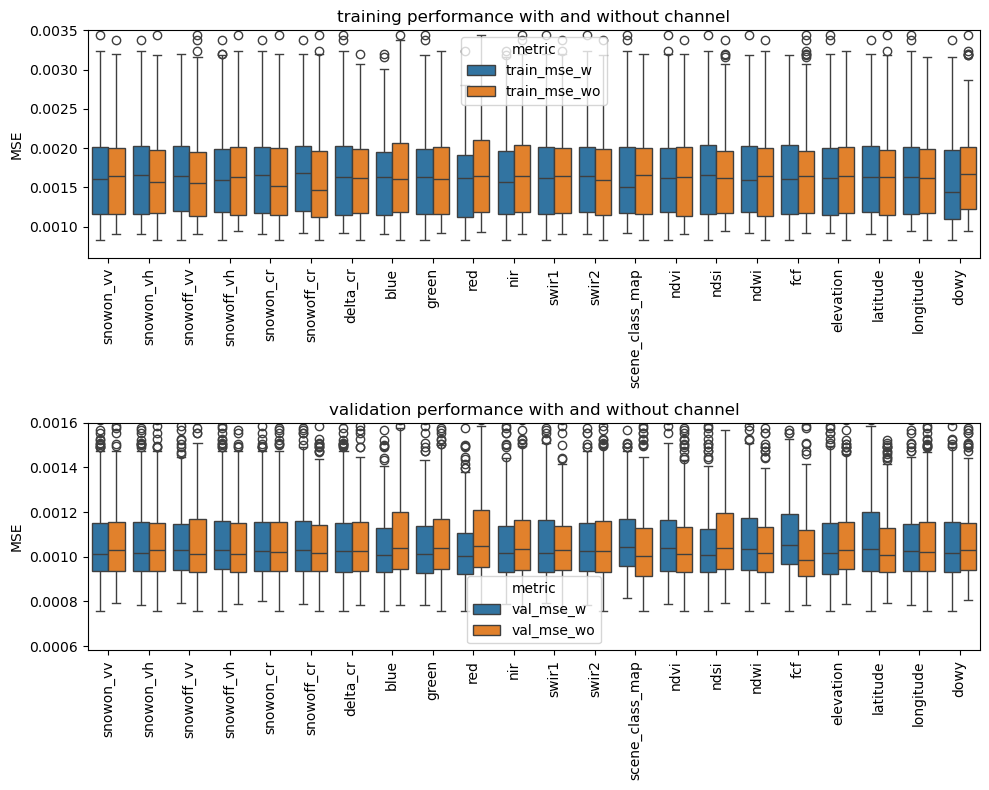

In [20]:
# Create subplots
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Top plot: Performance metrics 1 and 2
sns.boxplot(x='channel', y='value', hue='metric', data=pd.melt(df, id_vars=['channel'], value_vars=['train_mse_w', 'train_mse_wo'], var_name='metric'), ax=ax[0])
ax[0].set_title('training performance with and without channel')
ax[0].set_ylabel('MSE')
ax[0].set_xlabel('')
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_ylim(None, 0.0035)

# Bottom plot: Performance metrics 3 and 4
sns.boxplot(x='channel', y='value', hue='metric', data=pd.melt(df, id_vars=['channel'], value_vars=['val_mse_w', 'val_mse_wo'], var_name='metric'), ax=ax[1])
ax[1].set_title('validation performance with and without channel')
ax[1].set_ylabel('MSE')
ax[1].set_xlabel('')
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_ylim(None, 0.0016)

# Adjust layout
plt.tight_layout()

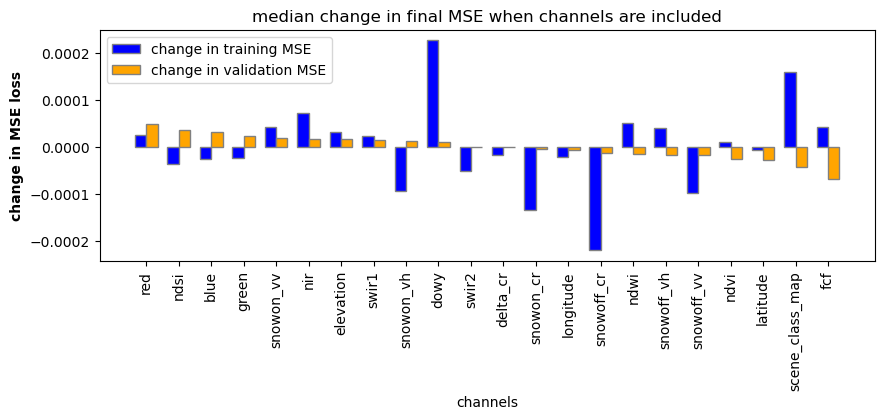

In [18]:
# Set the position of the bars on the x-axis
bar_width = 0.35
r1 = np.arange(len(df_summary['channels']))
r2 = [x + bar_width for x in r1]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 3))
ax.bar(r1, df_summary['train_loss_diff'], color='blue', width=bar_width, edgecolor='grey', label='change in training MSE')
ax.bar(r2, df_summary['val_loss_diff'], color='orange', width=bar_width, edgecolor='grey', label='change in validation MSE')
# Add labels
ax.set_xlabel('channels')
ax.set_xticks([r + bar_width/2 for r in range(len(df_summary['channels']))])
ax.set_xticklabels(df_summary['channels'], rotation=90)
ax.set_ylabel('change in MSE loss', fontweight='bold')
ax.set_title('median change in final MSE when channels are included')
# Add legend
ax.legend()

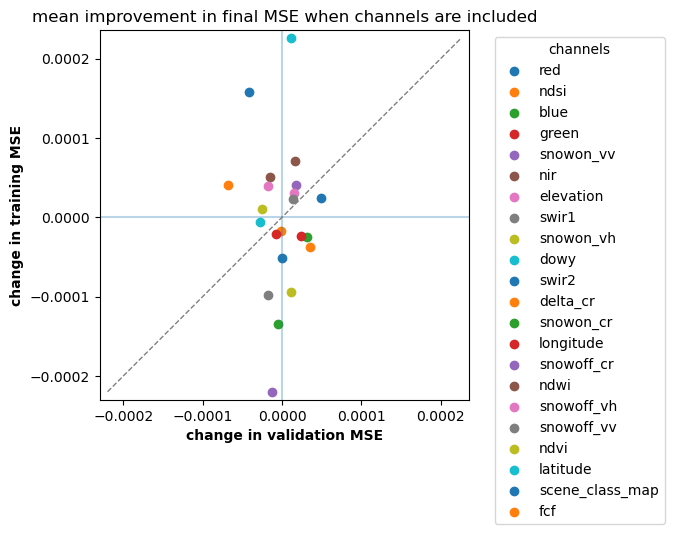

In [21]:
# Create the plot
# Determine the min and max values for the axes
min_value = min(min(df_summary['val_loss_diff']), min(df_summary['train_loss_diff']))
max_value = max(max(df_summary['val_loss_diff']), max(df_summary['train_loss_diff']))

fig, ax = plt.subplots()
ax.axvline(0, alpha=0.3)
ax.axhline(0, alpha=0.3)
ax.plot([min_value, max_value], [min_value, max_value], color='grey', linestyle='--', linewidth=1)

for channel in df_summary['channels']:
    ax.scatter(df_summary.loc[df_summary['channels'] == channel, 'val_loss_diff'], df_summary.loc[df_summary['channels'] == channel, 'train_loss_diff'], label=channel)

# Add labels
ax.set_xlabel('change in validation MSE', fontweight='bold')
ax.set_ylabel('change in training MSE', fontweight='bold')
ax.set_title('mean improvement in final MSE when channels are included')
ax.set_aspect('equal')
padding = 0.00001
ax.set_xlim(min_value-padding, max_value+padding)
ax.set_ylim(min_value-padding, max_value+padding)

# Add legend
ax.legend(title='channels', bbox_to_anchor=(1.05, 1), loc='upper left')